In [1]:
#!pip install nltk
import nltk
import pandas as pd
import geopandas as gpd
from IPython.display import Markdown, display
import shapefile
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import pyLDAvis.gensim_models
import numpy as np
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import pos_tag
from nltk.classify import NaiveBayesClassifier
import matplotlib.font_manager as fm
import gensim
from gensim import corpora, models
from collections import Counter
import seaborn as sns


#font_path = 'C:\\Users\\paton\\Documents\\_Glasgow Univ MSc\\_yr2_dissertation\\python\\Open_Sans\\OpenSans-VariableFont_wdth,wght.ttf'
#fm.fontManager.addfont(font_path)

C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# all functions here

# preprocessing 
def text_preprocessing(text):
    if text is None:
        return []  # Return an empty list if text is None
   
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token) > 1]
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='n') for token in text if len(token) > 1]
    
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    
    return text

# Convert list to string
def to_string(text):
    text = ' '.join(map(str, text))

    return text

# clean text
def clean_text(text, exceptions=[]):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text and filter out short words (length <= n)
    words = text.split()
    cleaned_words = [word for word in words if len(word) > 3 or word in exceptions]
    
    # Join the cleaned words back into a string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

#convert words to numbers
def words_to_numbers(text):
    word_to_number = {
        'one': '1',
        'two': '2',
        'three': '3',
        'four': '4',
        'five': '5',
        'six': '6',
        'seven': '7',
        'eight': '8',
        'nine': '9',
        'ten': '10',
        'single': '1'  
    }

    def replace_word(match):
        word = match.group(0).lower()
        return word_to_number.get(word, '')

    numeric_values = re.findall(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b', str(text), flags=re.IGNORECASE)
    extracted_values = [word_to_number[word.lower()] for word in numeric_values] if numeric_values else None
    cleaned_text = re.sub(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten|single)\b', replace_word, str(text), flags=re.IGNORECASE)
    return (cleaned_text, extracted_values)

# remove specified words
def remove_specific_words_with_word_break(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:class\s\d+|classes(?:\s\d+,)+\d+)\b'
    
    # Replace the matched patterns with an empty string
    cleaned_text = re.sub(pattern, '', str(text), flags=re.IGNORECASE)
    return cleaned_text

# extract and remove numeric with copy to new column

def extract_and_remove_numeric(text):
    def replace_numeric(match):
        return ''
    
    # Pattern to match numbers with word breaks at the start, end, or both
    pattern = r'\b\d+(?:\.\d+)?\b'
    
    # Find numeric values
    numeric_values = re.findall(pattern, str(text))
    extracted_values = ','.join(numeric_values) if numeric_values else None
    
    # Replace standalone numeric values with an empty string
    cleaned_text = re.sub(r'\b(?:{})\b'.format('|'.join(numeric_values)), replace_numeric, str(text))
    return (cleaned_text, extracted_values)

def remove_standalone_numeric(words_list):
    pattern = r'\b\d+(?:\.\d+)?\b'
    return [word for word in words_list if not re.match(pattern, word)]

# extract specific words to new column
def extract_specific_words_with_word_break(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:hectares|ha|units|dwellinghouse|dwellinghouses|dwellings|metres|m|storey)\b'
    
    specific_words = re.findall(pattern, str(text), flags=re.IGNORECASE)
    return ','.join(specific_words) if specific_words else None

In [3]:
#  define stop words
stop_words = set(stopwords.words('english'))


# add additional optional stop words to the set
optional_stop_words = {'and','all','by','for','more','none','not','null','of','or','over','than','with','local','major'}
stop_words.update(optional_stop_words)


## Read in data for Planning Applications with subset option drop year 2020 and 2021 due to covid

In [4]:
#read in planning app data
planapp_gdf_read = gpd.read_file('D:\\_Glasgow Univ MSc\\_dissertation_data\\other\\Planning_Applications_CCF_PREMIUM_-_Scotland-sh_plnapp_premium pub_plnapppol\\pub_plnapppol.shp')



In [5]:
#remove 2020 and 2021 covid years
planapp_gdf = planapp_gdf_read[planapp_gdf_read['year'] != 2020] 
planapp_gdf = planapp_gdf[planapp_gdf['year'] != 2021]
planapp_gdf = planapp_gdf[planapp_gdf['year'] != 3016]

In [6]:
#random selection
subset_size = 20000 
planapp_gdf = planapp_gdf_read.sample(n=subset_size)

## Define columns for Description, Application, Status, Proposal

In [7]:
#create columns for later handling
planapp_gdf["text_proposal"] = planapp_gdf["proposal"].str.lower()
planapp_gdf["text_desc"] = planapp_gdf["dev_desc"].str.lower()
planapp_gdf["text_app"] = planapp_gdf["appl_desc"].str.lower()
planapp_gdf["text_status"] = planapp_gdf["stat_desc"].str.lower()

planapp_gdf["feature"] = planapp_gdf["text_desc"]

## Words to numbers and remove numerics

In [8]:
# Apply the function to the "text_proposal" column to extract numeric values and remove them
planapp_gdf[['feature_cleaned_1', 'numeric_values']] = planapp_gdf['feature'].apply(words_to_numbers).apply(pd.Series)
planapp_gdf[['feature_cleaned_2', 'quantity']] = planapp_gdf['feature_cleaned_1'].apply(extract_and_remove_numeric).apply(pd.Series)
planapp_gdf['feature_cleaned_2'] = planapp_gdf['feature_cleaned_2'].apply(lambda words_list: remove_standalone_numeric(words_list))
planapp_gdf['feature_cleaned_2'] = planapp_gdf['feature_cleaned_2'].apply(lambda words_list: ''.join(words_list))

In [9]:
planapp_gdf['feature_cleaned_2']

230872          .  householder developments
405728    householder developments historic
445606             other developments local
511042             householder developments
19095            other developments - local
                        ...                
566250                                 None
215948                      housing - local
27489          housing - local (less than )
148251             other developments local
402490                                 None
Name: feature_cleaned_2, Length: 20000, dtype: object

### Pull out list of smallest words to identify additional stopwords

In [11]:
# Filter out None values in the 'text_desc' column
stopwords_list = set(stopwords.words('english'))

desc_words = ' '.join(list(planapp_gdf['text_desc'].dropna().values))

# Count and find the 30 most frequent words with 4 characters or less
word_counter = Counter(desc_words.split())
most_frequent = [word for word, count in word_counter.most_common(30) if len(word) <= 4]

# Filter the words with 4 characters or less and not present in NLTK stopwords
filtered_most_frequent = [word for word in most_frequent if word not in stopwords_list]

# Filter the words with 4 characters or less from the original word_counter
word_counter_filtered = {word: count for word, count in word_counter.items() if len(word) <= 4}

# Convert the filtered word_counter dictionary to a DataFrame
df_filtered = pd.DataFrame.from_dict(word_counter_filtered, orient='index', columns=["count"])
df_filtered.index.name = "words"

# Write the DataFrame to a CSV file
df_filtered.to_csv('word_counter_smallest_desc.csv')


## Pre processing

In [12]:
planapp_gdf["feature_cleaned_3"] = list(map(text_preprocessing, planapp_gdf.feature_cleaned_2))
planapp_gdf["feature_cleaned_3"]

230872              [householder, development]
405728    [householder, development, historic]
445606                           [development]
511042              [householder, development]
19095                            [development]
                          ...                 
566250                                  [None]
215948                                 [house]
27489                              [house, le]
148251                           [development]
402490                                  [None]
Name: feature_cleaned_3, Length: 20000, dtype: object

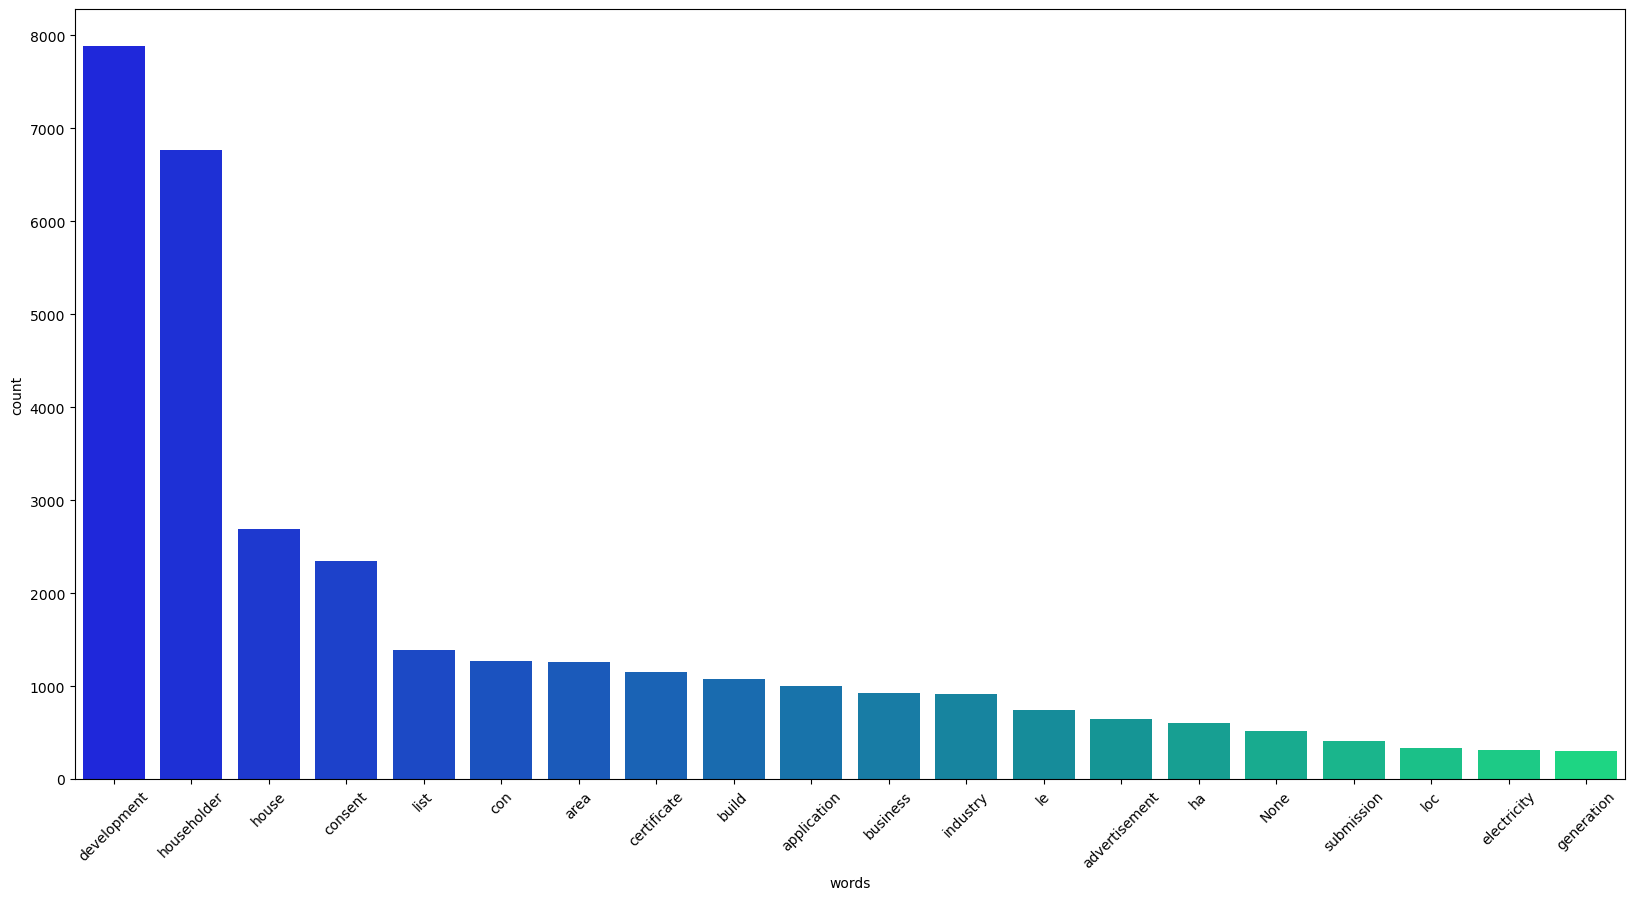

In [13]:
# Flatten the list of lists into a single list of words
desc_words_list = [word for sublist in planapp_gdf['feature_cleaned_3'] for word in sublist]

# Join all word corpus
desc_words = ' '.join(desc_words_list)

# Count and find the 30 most frequent after cleaning
word_counter = Counter(desc_words.split())
most_frequent = word_counter.most_common(20)

# Bar plot of frequent words
fig = plt.figure(1, figsize=(20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
sns.barplot(x='words', y='count', data=_, palette='winter')
plt.xticks(rotation=45)
plt.show()


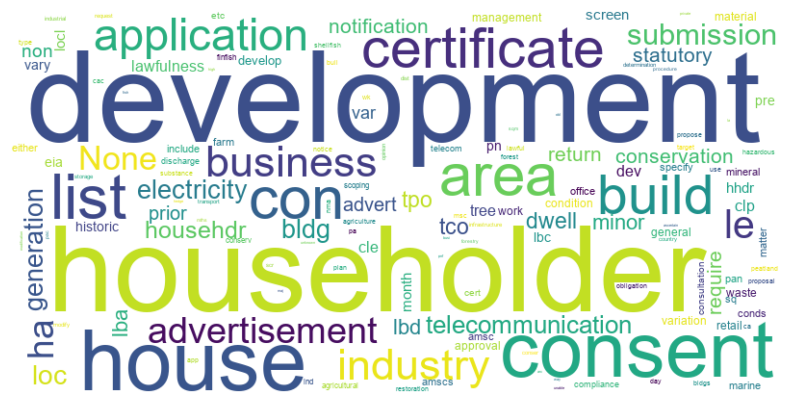

In [14]:
# Combine all words from the 'feature_cleaned_3' column into a single list
desc_words_list = [word for sublist in planapp_gdf['feature_cleaned_3'] for word in sublist]

# Join all words into a single string
data = ' '.join(desc_words_list)

# Specify the TrueType font file
font_path = 'C:\\Windows\\Fonts\\arial.ttf'

# Calculate word frequencies
word_frequencies = {word: desc_words_list.count(word) for word in set(desc_words_list)}

# Generate the word cloud using word frequencies
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate_from_frequencies(word_frequencies)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Tokenisation of phrases to create words 

In [15]:
id2word = gensim.corpora.Dictionary(planapp_gdf["feature_cleaned_3"])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in planapp_gdf["feature_cleaned_3"]]

In [16]:
from gensim.models import CoherenceModel, LdaMulticore

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             iterations=50,
                             num_topics=i,
                             workers=8,
                             passes=2)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=planapp_gdf["feature_cleaned_3"],
                                         dictionary=id2word,
                                         coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)

    # Print coherence score for each iteration
    print(f"Iteration {i}: Coherence Score = {coherence_lda}")


Iteration 1: Coherence Score = -21.99046351206081
Iteration 2: Coherence Score = -21.56314716173596
Iteration 3: Coherence Score = -21.35262500389561
Iteration 4: Coherence Score = -20.86781796087386
Iteration 5: Coherence Score = -21.042443248651445
Iteration 6: Coherence Score = -20.871094962990167
Iteration 7: Coherence Score = -20.969428674796635
Iteration 8: Coherence Score = -20.523519429613742
Iteration 9: Coherence Score = -20.674344827699606
Iteration 10: Coherence Score = -20.666971307008986
Iteration 11: Coherence Score = -20.818045377490115
Iteration 12: Coherence Score = -20.80295924246338
Iteration 13: Coherence Score = -20.7988621855788
Iteration 14: Coherence Score = -20.486849252837807
Iteration 15: Coherence Score = -20.78397452690214
Iteration 16: Coherence Score = -20.702300450338985
Iteration 17: Coherence Score = -20.476484394048654
Iteration 18: Coherence Score = -20.504239587668156
Iteration 19: Coherence Score = -20.59467228177622


## plot using window and smoothing

<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score_smoothed'>

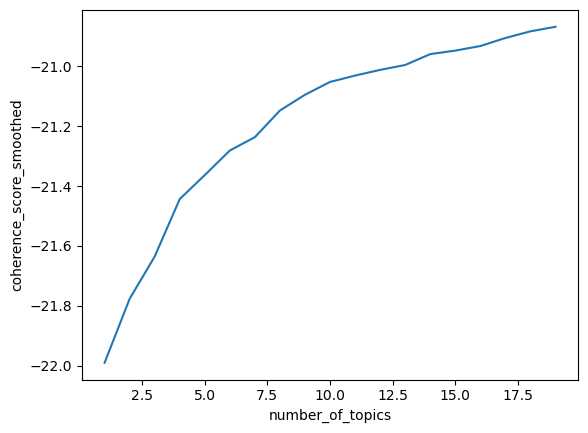

In [17]:
# compute coherence scores
topic_coherence = pd.DataFrame({'number_of_topics': number_of_topics,
                                'coherence_score': coherence_score})

# compute moving average with window size 3 
topic_coherence['coherence_score_smoothed'] = topic_coherence['coherence_score'].rolling(window=50, min_periods=1).mean()

# plot the smoothed coherence scores
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score_smoothed')


## Topic Modelling

In [18]:
import logging

n_topics = 10

# Set logging level to INFO for verbose logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

2023-07-23 19:00:54,324 : INFO : using symmetric alpha at 0.1
2023-07-23 19:00:54,326 : INFO : using symmetric eta at 0.1
2023-07-23 19:00:54,332 : INFO : using serial LDA version on this node
2023-07-23 19:00:54,335 : INFO : running batch LDA training, 10 topics, 10 passes over the supplied corpus of 20000 documents, updating model once every 20000 documents, evaluating perplexity every 100 documents, iterating 100x with a convergence threshold of 0.001000
2023-07-23 19:00:54,338 : INFO : PROGRESS: pass 0, at document #10/20000
2023-07-23 19:00:54,349 : INFO : PROGRESS: pass 0, at document #20/20000
2023-07-23 19:00:54,391 : INFO : PROGRESS: pass 0, at document #30/20000
2023-07-23 19:00:54,404 : INFO : PROGRESS: pass 0, at document #40/20000
2023-07-23 19:00:54,416 : INFO : PROGRESS: pass 0, at document #50/20000
2023-07-23 19:00:54,428 : INFO : PROGRESS: pass 0, at document #60/20000
2023-07-23 19:00:54,454 : INFO : PROGRESS: pass 0, at document #70/20000
2023-07-23 19:00:54,465 : I

2023-07-23 19:00:55,513 : INFO : PROGRESS: pass 0, at document #900/20000
2023-07-23 19:00:55,521 : INFO : PROGRESS: pass 0, at document #910/20000
2023-07-23 19:00:55,532 : INFO : PROGRESS: pass 0, at document #920/20000
2023-07-23 19:00:55,540 : INFO : PROGRESS: pass 0, at document #930/20000
2023-07-23 19:00:55,549 : INFO : PROGRESS: pass 0, at document #940/20000
2023-07-23 19:00:55,558 : INFO : PROGRESS: pass 0, at document #950/20000
2023-07-23 19:00:55,571 : INFO : PROGRESS: pass 0, at document #960/20000
2023-07-23 19:00:55,579 : INFO : PROGRESS: pass 0, at document #970/20000
2023-07-23 19:00:55,588 : INFO : PROGRESS: pass 0, at document #980/20000
2023-07-23 19:00:55,599 : INFO : PROGRESS: pass 0, at document #990/20000
2023-07-23 19:00:55,618 : INFO : -7.228 per-word bound, 149.9 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:00:55,619 : INFO : PROGRESS: pass 0, at document #1000/20000
2023-07-23 19:00:55,631 : INFO : PROGRESS: pas

2023-07-23 19:00:56,589 : INFO : PROGRESS: pass 0, at document #1830/20000
2023-07-23 19:00:56,601 : INFO : PROGRESS: pass 0, at document #1840/20000
2023-07-23 19:00:56,611 : INFO : PROGRESS: pass 0, at document #1850/20000
2023-07-23 19:00:56,619 : INFO : PROGRESS: pass 0, at document #1860/20000
2023-07-23 19:00:56,627 : INFO : PROGRESS: pass 0, at document #1870/20000
2023-07-23 19:00:56,636 : INFO : PROGRESS: pass 0, at document #1880/20000
2023-07-23 19:00:56,648 : INFO : PROGRESS: pass 0, at document #1890/20000
2023-07-23 19:00:56,670 : INFO : -7.331 per-word bound, 161.0 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:00:56,672 : INFO : PROGRESS: pass 0, at document #1900/20000
2023-07-23 19:00:56,682 : INFO : PROGRESS: pass 0, at document #1910/20000
2023-07-23 19:00:56,691 : INFO : PROGRESS: pass 0, at document #1920/20000
2023-07-23 19:00:56,700 : INFO : PROGRESS: pass 0, at document #1930/20000
2023-07-23 19:00:56,710 : INFO : PRO

2023-07-23 19:00:57,708 : INFO : PROGRESS: pass 0, at document #2760/20000
2023-07-23 19:00:57,719 : INFO : PROGRESS: pass 0, at document #2770/20000
2023-07-23 19:00:57,730 : INFO : PROGRESS: pass 0, at document #2780/20000
2023-07-23 19:00:57,744 : INFO : PROGRESS: pass 0, at document #2790/20000
2023-07-23 19:00:57,774 : INFO : -7.091 per-word bound, 136.4 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:00:57,776 : INFO : PROGRESS: pass 0, at document #2800/20000
2023-07-23 19:00:57,788 : INFO : PROGRESS: pass 0, at document #2810/20000
2023-07-23 19:00:57,800 : INFO : PROGRESS: pass 0, at document #2820/20000
2023-07-23 19:00:57,812 : INFO : PROGRESS: pass 0, at document #2830/20000
2023-07-23 19:00:57,823 : INFO : PROGRESS: pass 0, at document #2840/20000
2023-07-23 19:00:57,837 : INFO : PROGRESS: pass 0, at document #2850/20000
2023-07-23 19:00:57,850 : INFO : PROGRESS: pass 0, at document #2860/20000
2023-07-23 19:00:57,863 : INFO : PRO

2023-07-23 19:00:59,074 : INFO : PROGRESS: pass 0, at document #3690/20000
2023-07-23 19:00:59,090 : INFO : -7.179 per-word bound, 144.9 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:00:59,092 : INFO : PROGRESS: pass 0, at document #3700/20000
2023-07-23 19:00:59,102 : INFO : PROGRESS: pass 0, at document #3710/20000
2023-07-23 19:00:59,110 : INFO : PROGRESS: pass 0, at document #3720/20000
2023-07-23 19:00:59,119 : INFO : PROGRESS: pass 0, at document #3730/20000
2023-07-23 19:00:59,129 : INFO : PROGRESS: pass 0, at document #3740/20000
2023-07-23 19:00:59,138 : INFO : PROGRESS: pass 0, at document #3750/20000
2023-07-23 19:00:59,147 : INFO : PROGRESS: pass 0, at document #3760/20000
2023-07-23 19:00:59,154 : INFO : PROGRESS: pass 0, at document #3770/20000
2023-07-23 19:00:59,163 : INFO : PROGRESS: pass 0, at document #3780/20000
2023-07-23 19:00:59,174 : INFO : PROGRESS: pass 0, at document #3790/20000
2023-07-23 19:00:59,197 : INFO : -6.

2023-07-23 19:01:00,081 : INFO : PROGRESS: pass 0, at document #4600/20000
2023-07-23 19:01:00,091 : INFO : PROGRESS: pass 0, at document #4610/20000
2023-07-23 19:01:00,101 : INFO : PROGRESS: pass 0, at document #4620/20000
2023-07-23 19:01:00,111 : INFO : PROGRESS: pass 0, at document #4630/20000
2023-07-23 19:01:00,119 : INFO : PROGRESS: pass 0, at document #4640/20000
2023-07-23 19:01:00,128 : INFO : PROGRESS: pass 0, at document #4650/20000
2023-07-23 19:01:00,138 : INFO : PROGRESS: pass 0, at document #4660/20000
2023-07-23 19:01:00,147 : INFO : PROGRESS: pass 0, at document #4670/20000
2023-07-23 19:01:00,154 : INFO : PROGRESS: pass 0, at document #4680/20000
2023-07-23 19:01:00,164 : INFO : PROGRESS: pass 0, at document #4690/20000
2023-07-23 19:01:00,182 : INFO : -7.180 per-word bound, 145.0 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:00,184 : INFO : PROGRESS: pass 0, at document #4700/20000
2023-07-23 19:01:00,195 : INFO : PRO

2023-07-23 19:01:01,173 : INFO : PROGRESS: pass 0, at document #5530/20000
2023-07-23 19:01:01,184 : INFO : PROGRESS: pass 0, at document #5540/20000
2023-07-23 19:01:01,194 : INFO : PROGRESS: pass 0, at document #5550/20000
2023-07-23 19:01:01,204 : INFO : PROGRESS: pass 0, at document #5560/20000
2023-07-23 19:01:01,214 : INFO : PROGRESS: pass 0, at document #5570/20000
2023-07-23 19:01:01,222 : INFO : PROGRESS: pass 0, at document #5580/20000
2023-07-23 19:01:01,234 : INFO : PROGRESS: pass 0, at document #5590/20000
2023-07-23 19:01:01,253 : INFO : -7.172 per-word bound, 144.2 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:01,255 : INFO : PROGRESS: pass 0, at document #5600/20000
2023-07-23 19:01:01,266 : INFO : PROGRESS: pass 0, at document #5610/20000
2023-07-23 19:01:01,278 : INFO : PROGRESS: pass 0, at document #5620/20000
2023-07-23 19:01:01,290 : INFO : PROGRESS: pass 0, at document #5630/20000
2023-07-23 19:01:01,303 : INFO : PRO

2023-07-23 19:01:02,156 : INFO : PROGRESS: pass 0, at document #6460/20000
2023-07-23 19:01:02,165 : INFO : PROGRESS: pass 0, at document #6470/20000
2023-07-23 19:01:02,172 : INFO : PROGRESS: pass 0, at document #6480/20000
2023-07-23 19:01:02,181 : INFO : PROGRESS: pass 0, at document #6490/20000
2023-07-23 19:01:02,199 : INFO : -6.861 per-word bound, 116.2 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 19:01:02,201 : INFO : PROGRESS: pass 0, at document #6500/20000
2023-07-23 19:01:02,211 : INFO : PROGRESS: pass 0, at document #6510/20000
2023-07-23 19:01:02,219 : INFO : PROGRESS: pass 0, at document #6520/20000
2023-07-23 19:01:02,228 : INFO : PROGRESS: pass 0, at document #6530/20000
2023-07-23 19:01:02,235 : INFO : PROGRESS: pass 0, at document #6540/20000
2023-07-23 19:01:02,243 : INFO : PROGRESS: pass 0, at document #6550/20000
2023-07-23 19:01:02,251 : INFO : PROGRESS: pass 0, at document #6560/20000
2023-07-23 19:01:02,260 : INFO : PRO

2023-07-23 19:01:03,045 : INFO : PROGRESS: pass 0, at document #7390/20000
2023-07-23 19:01:03,064 : INFO : -7.123 per-word bound, 139.4 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:03,066 : INFO : PROGRESS: pass 0, at document #7400/20000
2023-07-23 19:01:03,082 : INFO : PROGRESS: pass 0, at document #7410/20000
2023-07-23 19:01:03,093 : INFO : PROGRESS: pass 0, at document #7420/20000
2023-07-23 19:01:03,105 : INFO : PROGRESS: pass 0, at document #7430/20000
2023-07-23 19:01:03,115 : INFO : PROGRESS: pass 0, at document #7440/20000
2023-07-23 19:01:03,124 : INFO : PROGRESS: pass 0, at document #7450/20000
2023-07-23 19:01:03,132 : INFO : PROGRESS: pass 0, at document #7460/20000
2023-07-23 19:01:03,141 : INFO : PROGRESS: pass 0, at document #7470/20000
2023-07-23 19:01:03,150 : INFO : PROGRESS: pass 0, at document #7480/20000
2023-07-23 19:01:03,160 : INFO : PROGRESS: pass 0, at document #7490/20000
2023-07-23 19:01:03,179 : INFO : -7.

2023-07-23 19:01:04,051 : INFO : PROGRESS: pass 0, at document #8300/20000
2023-07-23 19:01:04,061 : INFO : PROGRESS: pass 0, at document #8310/20000
2023-07-23 19:01:04,069 : INFO : PROGRESS: pass 0, at document #8320/20000
2023-07-23 19:01:04,078 : INFO : PROGRESS: pass 0, at document #8330/20000
2023-07-23 19:01:04,087 : INFO : PROGRESS: pass 0, at document #8340/20000
2023-07-23 19:01:04,097 : INFO : PROGRESS: pass 0, at document #8350/20000
2023-07-23 19:01:04,104 : INFO : PROGRESS: pass 0, at document #8360/20000
2023-07-23 19:01:04,112 : INFO : PROGRESS: pass 0, at document #8370/20000
2023-07-23 19:01:04,119 : INFO : PROGRESS: pass 0, at document #8380/20000
2023-07-23 19:01:04,130 : INFO : PROGRESS: pass 0, at document #8390/20000
2023-07-23 19:01:04,145 : INFO : -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 10 documents with 26 words
2023-07-23 19:01:04,146 : INFO : PROGRESS: pass 0, at document #8400/20000
2023-07-23 19:01:04,157 : INFO : PRO

2023-07-23 19:01:05,084 : INFO : PROGRESS: pass 0, at document #9230/20000
2023-07-23 19:01:05,094 : INFO : PROGRESS: pass 0, at document #9240/20000
2023-07-23 19:01:05,104 : INFO : PROGRESS: pass 0, at document #9250/20000
2023-07-23 19:01:05,115 : INFO : PROGRESS: pass 0, at document #9260/20000
2023-07-23 19:01:05,124 : INFO : PROGRESS: pass 0, at document #9270/20000
2023-07-23 19:01:05,132 : INFO : PROGRESS: pass 0, at document #9280/20000
2023-07-23 19:01:05,142 : INFO : PROGRESS: pass 0, at document #9290/20000
2023-07-23 19:01:05,166 : INFO : -6.845 per-word bound, 115.0 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 19:01:05,168 : INFO : PROGRESS: pass 0, at document #9300/20000
2023-07-23 19:01:05,180 : INFO : PROGRESS: pass 0, at document #9310/20000
2023-07-23 19:01:05,189 : INFO : PROGRESS: pass 0, at document #9320/20000
2023-07-23 19:01:05,198 : INFO : PROGRESS: pass 0, at document #9330/20000
2023-07-23 19:01:05,208 : INFO : PRO

2023-07-23 19:01:06,187 : INFO : PROGRESS: pass 0, at document #10160/20000
2023-07-23 19:01:06,200 : INFO : PROGRESS: pass 0, at document #10170/20000
2023-07-23 19:01:06,211 : INFO : PROGRESS: pass 0, at document #10180/20000
2023-07-23 19:01:06,223 : INFO : PROGRESS: pass 0, at document #10190/20000
2023-07-23 19:01:06,248 : INFO : -7.178 per-word bound, 144.8 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:01:06,250 : INFO : PROGRESS: pass 0, at document #10200/20000
2023-07-23 19:01:06,261 : INFO : PROGRESS: pass 0, at document #10210/20000
2023-07-23 19:01:06,275 : INFO : PROGRESS: pass 0, at document #10220/20000
2023-07-23 19:01:06,286 : INFO : PROGRESS: pass 0, at document #10230/20000
2023-07-23 19:01:06,300 : INFO : PROGRESS: pass 0, at document #10240/20000
2023-07-23 19:01:06,312 : INFO : PROGRESS: pass 0, at document #10250/20000
2023-07-23 19:01:06,322 : INFO : PROGRESS: pass 0, at document #10260/20000
2023-07-23 19:01:06,332 :

2023-07-23 19:01:07,301 : INFO : PROGRESS: pass 0, at document #11080/20000
2023-07-23 19:01:07,318 : INFO : PROGRESS: pass 0, at document #11090/20000
2023-07-23 19:01:07,341 : INFO : -7.202 per-word bound, 147.3 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:01:07,343 : INFO : PROGRESS: pass 0, at document #11100/20000
2023-07-23 19:01:07,354 : INFO : PROGRESS: pass 0, at document #11110/20000
2023-07-23 19:01:07,365 : INFO : PROGRESS: pass 0, at document #11120/20000
2023-07-23 19:01:07,376 : INFO : PROGRESS: pass 0, at document #11130/20000
2023-07-23 19:01:07,388 : INFO : PROGRESS: pass 0, at document #11140/20000
2023-07-23 19:01:07,399 : INFO : PROGRESS: pass 0, at document #11150/20000
2023-07-23 19:01:07,413 : INFO : PROGRESS: pass 0, at document #11160/20000
2023-07-23 19:01:07,425 : INFO : PROGRESS: pass 0, at document #11170/20000
2023-07-23 19:01:07,436 : INFO : PROGRESS: pass 0, at document #11180/20000
2023-07-23 19:01:07,450 :

2023-07-23 19:01:08,578 : INFO : -7.011 per-word bound, 129.0 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:01:08,580 : INFO : PROGRESS: pass 0, at document #12000/20000
2023-07-23 19:01:08,591 : INFO : PROGRESS: pass 0, at document #12010/20000
2023-07-23 19:01:08,600 : INFO : PROGRESS: pass 0, at document #12020/20000
2023-07-23 19:01:08,612 : INFO : PROGRESS: pass 0, at document #12030/20000
2023-07-23 19:01:08,621 : INFO : PROGRESS: pass 0, at document #12040/20000
2023-07-23 19:01:08,634 : INFO : PROGRESS: pass 0, at document #12050/20000
2023-07-23 19:01:08,646 : INFO : PROGRESS: pass 0, at document #12060/20000
2023-07-23 19:01:08,658 : INFO : PROGRESS: pass 0, at document #12070/20000
2023-07-23 19:01:08,668 : INFO : PROGRESS: pass 0, at document #12080/20000
2023-07-23 19:01:08,681 : INFO : PROGRESS: pass 0, at document #12090/20000
2023-07-23 19:01:08,702 : INFO : -7.326 per-word bound, 160.4 perplexity estimate based on a held-out

2023-07-23 19:01:09,625 : INFO : PROGRESS: pass 0, at document #12900/20000
2023-07-23 19:01:09,638 : INFO : PROGRESS: pass 0, at document #12910/20000
2023-07-23 19:01:09,649 : INFO : PROGRESS: pass 0, at document #12920/20000
2023-07-23 19:01:09,660 : INFO : PROGRESS: pass 0, at document #12930/20000
2023-07-23 19:01:09,674 : INFO : PROGRESS: pass 0, at document #12940/20000
2023-07-23 19:01:09,685 : INFO : PROGRESS: pass 0, at document #12950/20000
2023-07-23 19:01:09,696 : INFO : PROGRESS: pass 0, at document #12960/20000
2023-07-23 19:01:09,707 : INFO : PROGRESS: pass 0, at document #12970/20000
2023-07-23 19:01:09,718 : INFO : PROGRESS: pass 0, at document #12980/20000
2023-07-23 19:01:09,730 : INFO : PROGRESS: pass 0, at document #12990/20000
2023-07-23 19:01:09,748 : INFO : -7.266 per-word bound, 153.9 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:01:09,750 : INFO : PROGRESS: pass 0, at document #13000/20000
2023-07-23 19:01:09,760 :

2023-07-23 19:01:10,725 : INFO : PROGRESS: pass 0, at document #13820/20000
2023-07-23 19:01:10,732 : INFO : PROGRESS: pass 0, at document #13830/20000
2023-07-23 19:01:10,743 : INFO : PROGRESS: pass 0, at document #13840/20000
2023-07-23 19:01:10,752 : INFO : PROGRESS: pass 0, at document #13850/20000
2023-07-23 19:01:10,761 : INFO : PROGRESS: pass 0, at document #13860/20000
2023-07-23 19:01:10,770 : INFO : PROGRESS: pass 0, at document #13870/20000
2023-07-23 19:01:10,780 : INFO : PROGRESS: pass 0, at document #13880/20000
2023-07-23 19:01:10,788 : INFO : PROGRESS: pass 0, at document #13890/20000
2023-07-23 19:01:10,808 : INFO : -7.141 per-word bound, 141.1 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:10,809 : INFO : PROGRESS: pass 0, at document #13900/20000
2023-07-23 19:01:10,819 : INFO : PROGRESS: pass 0, at document #13910/20000
2023-07-23 19:01:10,827 : INFO : PROGRESS: pass 0, at document #13920/20000
2023-07-23 19:01:10,836 :

2023-07-23 19:01:11,785 : INFO : PROGRESS: pass 0, at document #14740/20000
2023-07-23 19:01:11,796 : INFO : PROGRESS: pass 0, at document #14750/20000
2023-07-23 19:01:11,806 : INFO : PROGRESS: pass 0, at document #14760/20000
2023-07-23 19:01:11,817 : INFO : PROGRESS: pass 0, at document #14770/20000
2023-07-23 19:01:11,828 : INFO : PROGRESS: pass 0, at document #14780/20000
2023-07-23 19:01:11,840 : INFO : PROGRESS: pass 0, at document #14790/20000
2023-07-23 19:01:11,864 : INFO : -7.261 per-word bound, 153.4 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:01:11,867 : INFO : PROGRESS: pass 0, at document #14800/20000
2023-07-23 19:01:11,882 : INFO : PROGRESS: pass 0, at document #14810/20000
2023-07-23 19:01:11,893 : INFO : PROGRESS: pass 0, at document #14820/20000
2023-07-23 19:01:11,902 : INFO : PROGRESS: pass 0, at document #14830/20000
2023-07-23 19:01:11,914 : INFO : PROGRESS: pass 0, at document #14840/20000
2023-07-23 19:01:11,924 :

2023-07-23 19:01:12,961 : INFO : PROGRESS: pass 0, at document #15660/20000
2023-07-23 19:01:12,973 : INFO : PROGRESS: pass 0, at document #15670/20000
2023-07-23 19:01:12,985 : INFO : PROGRESS: pass 0, at document #15680/20000
2023-07-23 19:01:12,996 : INFO : PROGRESS: pass 0, at document #15690/20000
2023-07-23 19:01:13,015 : INFO : -7.189 per-word bound, 145.9 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:01:13,017 : INFO : PROGRESS: pass 0, at document #15700/20000
2023-07-23 19:01:13,028 : INFO : PROGRESS: pass 0, at document #15710/20000
2023-07-23 19:01:13,036 : INFO : PROGRESS: pass 0, at document #15720/20000
2023-07-23 19:01:13,048 : INFO : PROGRESS: pass 0, at document #15730/20000
2023-07-23 19:01:13,059 : INFO : PROGRESS: pass 0, at document #15740/20000
2023-07-23 19:01:13,073 : INFO : PROGRESS: pass 0, at document #15750/20000
2023-07-23 19:01:13,083 : INFO : PROGRESS: pass 0, at document #15760/20000
2023-07-23 19:01:13,093 :

2023-07-23 19:01:14,174 : INFO : PROGRESS: pass 0, at document #16580/20000
2023-07-23 19:01:14,184 : INFO : PROGRESS: pass 0, at document #16590/20000
2023-07-23 19:01:14,208 : INFO : -7.083 per-word bound, 135.6 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:01:14,210 : INFO : PROGRESS: pass 0, at document #16600/20000
2023-07-23 19:01:14,224 : INFO : PROGRESS: pass 0, at document #16610/20000
2023-07-23 19:01:14,235 : INFO : PROGRESS: pass 0, at document #16620/20000
2023-07-23 19:01:14,246 : INFO : PROGRESS: pass 0, at document #16630/20000
2023-07-23 19:01:14,262 : INFO : PROGRESS: pass 0, at document #16640/20000
2023-07-23 19:01:14,272 : INFO : PROGRESS: pass 0, at document #16650/20000
2023-07-23 19:01:14,283 : INFO : PROGRESS: pass 0, at document #16660/20000
2023-07-23 19:01:14,295 : INFO : PROGRESS: pass 0, at document #16670/20000
2023-07-23 19:01:14,306 : INFO : PROGRESS: pass 0, at document #16680/20000
2023-07-23 19:01:14,315 :

2023-07-23 19:01:15,279 : INFO : -6.956 per-word bound, 124.1 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:01:15,280 : INFO : PROGRESS: pass 0, at document #17500/20000
2023-07-23 19:01:15,292 : INFO : PROGRESS: pass 0, at document #17510/20000
2023-07-23 19:01:15,302 : INFO : PROGRESS: pass 0, at document #17520/20000
2023-07-23 19:01:15,310 : INFO : PROGRESS: pass 0, at document #17530/20000
2023-07-23 19:01:15,318 : INFO : PROGRESS: pass 0, at document #17540/20000
2023-07-23 19:01:15,327 : INFO : PROGRESS: pass 0, at document #17550/20000
2023-07-23 19:01:15,336 : INFO : PROGRESS: pass 0, at document #17560/20000
2023-07-23 19:01:15,344 : INFO : PROGRESS: pass 0, at document #17570/20000
2023-07-23 19:01:15,352 : INFO : PROGRESS: pass 0, at document #17580/20000
2023-07-23 19:01:15,360 : INFO : PROGRESS: pass 0, at document #17590/20000
2023-07-23 19:01:15,377 : INFO : -7.063 per-word bound, 133.7 perplexity estimate based on a held-out

2023-07-23 19:01:16,318 : INFO : PROGRESS: pass 0, at document #18400/20000
2023-07-23 19:01:16,330 : INFO : PROGRESS: pass 0, at document #18410/20000
2023-07-23 19:01:16,340 : INFO : PROGRESS: pass 0, at document #18420/20000
2023-07-23 19:01:16,348 : INFO : PROGRESS: pass 0, at document #18430/20000
2023-07-23 19:01:16,360 : INFO : PROGRESS: pass 0, at document #18440/20000
2023-07-23 19:01:16,373 : INFO : PROGRESS: pass 0, at document #18450/20000
2023-07-23 19:01:16,381 : INFO : PROGRESS: pass 0, at document #18460/20000
2023-07-23 19:01:16,393 : INFO : PROGRESS: pass 0, at document #18470/20000
2023-07-23 19:01:16,401 : INFO : PROGRESS: pass 0, at document #18480/20000
2023-07-23 19:01:16,412 : INFO : PROGRESS: pass 0, at document #18490/20000
2023-07-23 19:01:16,431 : INFO : -7.028 per-word bound, 130.5 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:01:16,433 : INFO : PROGRESS: pass 0, at document #18500/20000
2023-07-23 19:01:16,444 :

2023-07-23 19:01:17,481 : INFO : PROGRESS: pass 0, at document #19320/20000
2023-07-23 19:01:17,496 : INFO : PROGRESS: pass 0, at document #19330/20000
2023-07-23 19:01:17,507 : INFO : PROGRESS: pass 0, at document #19340/20000
2023-07-23 19:01:17,516 : INFO : PROGRESS: pass 0, at document #19350/20000
2023-07-23 19:01:17,528 : INFO : PROGRESS: pass 0, at document #19360/20000
2023-07-23 19:01:17,539 : INFO : PROGRESS: pass 0, at document #19370/20000
2023-07-23 19:01:17,548 : INFO : PROGRESS: pass 0, at document #19380/20000
2023-07-23 19:01:17,559 : INFO : PROGRESS: pass 0, at document #19390/20000
2023-07-23 19:01:17,579 : INFO : -7.097 per-word bound, 136.9 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:17,580 : INFO : PROGRESS: pass 0, at document #19400/20000
2023-07-23 19:01:17,593 : INFO : PROGRESS: pass 0, at document #19410/20000
2023-07-23 19:01:17,602 : INFO : PROGRESS: pass 0, at document #19420/20000
2023-07-23 19:01:17,611 :

2023-07-23 19:01:18,397 : INFO : PROGRESS: pass 1, at document #100/20000
2023-07-23 19:01:18,408 : INFO : PROGRESS: pass 1, at document #110/20000
2023-07-23 19:01:18,418 : INFO : PROGRESS: pass 1, at document #120/20000
2023-07-23 19:01:18,428 : INFO : PROGRESS: pass 1, at document #130/20000
2023-07-23 19:01:18,437 : INFO : PROGRESS: pass 1, at document #140/20000
2023-07-23 19:01:18,447 : INFO : PROGRESS: pass 1, at document #150/20000
2023-07-23 19:01:18,458 : INFO : PROGRESS: pass 1, at document #160/20000
2023-07-23 19:01:18,466 : INFO : PROGRESS: pass 1, at document #170/20000
2023-07-23 19:01:18,476 : INFO : PROGRESS: pass 1, at document #180/20000
2023-07-23 19:01:18,483 : INFO : PROGRESS: pass 1, at document #190/20000
2023-07-23 19:01:18,501 : INFO : -3.840 per-word bound, 14.3 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:01:18,503 : INFO : PROGRESS: pass 1, at document #200/20000
2023-07-23 19:01:18,514 : INFO : PROGRESS: pass 

2023-07-23 19:01:19,252 : INFO : PROGRESS: pass 1, at document #1040/20000
2023-07-23 19:01:19,260 : INFO : PROGRESS: pass 1, at document #1050/20000
2023-07-23 19:01:19,267 : INFO : PROGRESS: pass 1, at document #1060/20000
2023-07-23 19:01:19,274 : INFO : PROGRESS: pass 1, at document #1070/20000
2023-07-23 19:01:19,281 : INFO : PROGRESS: pass 1, at document #1080/20000
2023-07-23 19:01:19,291 : INFO : PROGRESS: pass 1, at document #1090/20000
2023-07-23 19:01:19,306 : INFO : -3.144 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:01:19,307 : INFO : PROGRESS: pass 1, at document #1100/20000
2023-07-23 19:01:19,314 : INFO : PROGRESS: pass 1, at document #1110/20000
2023-07-23 19:01:19,323 : INFO : PROGRESS: pass 1, at document #1120/20000
2023-07-23 19:01:19,330 : INFO : PROGRESS: pass 1, at document #1130/20000
2023-07-23 19:01:19,338 : INFO : PROGRESS: pass 1, at document #1140/20000
2023-07-23 19:01:19,345 : INFO : PROGR

2023-07-23 19:01:20,057 : INFO : PROGRESS: pass 1, at document #1970/20000
2023-07-23 19:01:20,066 : INFO : PROGRESS: pass 1, at document #1980/20000
2023-07-23 19:01:20,074 : INFO : PROGRESS: pass 1, at document #1990/20000
2023-07-23 19:01:20,089 : INFO : -3.374 per-word bound, 10.4 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:20,090 : INFO : PROGRESS: pass 1, at document #2000/20000
2023-07-23 19:01:20,097 : INFO : PROGRESS: pass 1, at document #2010/20000
2023-07-23 19:01:20,105 : INFO : PROGRESS: pass 1, at document #2020/20000
2023-07-23 19:01:20,113 : INFO : PROGRESS: pass 1, at document #2030/20000
2023-07-23 19:01:20,121 : INFO : PROGRESS: pass 1, at document #2040/20000
2023-07-23 19:01:20,128 : INFO : PROGRESS: pass 1, at document #2050/20000
2023-07-23 19:01:20,135 : INFO : PROGRESS: pass 1, at document #2060/20000
2023-07-23 19:01:20,142 : INFO : PROGRESS: pass 1, at document #2070/20000
2023-07-23 19:01:20,152 : INFO : PROG

2023-07-23 19:01:20,881 : INFO : -2.857 per-word bound, 7.2 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:01:20,882 : INFO : PROGRESS: pass 1, at document #2900/20000
2023-07-23 19:01:20,892 : INFO : PROGRESS: pass 1, at document #2910/20000
2023-07-23 19:01:20,899 : INFO : PROGRESS: pass 1, at document #2920/20000
2023-07-23 19:01:20,908 : INFO : PROGRESS: pass 1, at document #2930/20000
2023-07-23 19:01:20,918 : INFO : PROGRESS: pass 1, at document #2940/20000
2023-07-23 19:01:20,925 : INFO : PROGRESS: pass 1, at document #2950/20000
2023-07-23 19:01:20,932 : INFO : PROGRESS: pass 1, at document #2960/20000
2023-07-23 19:01:20,941 : INFO : PROGRESS: pass 1, at document #2970/20000
2023-07-23 19:01:20,950 : INFO : PROGRESS: pass 1, at document #2980/20000
2023-07-23 19:01:20,958 : INFO : PROGRESS: pass 1, at document #2990/20000
2023-07-23 19:01:20,973 : INFO : -3.159 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 10 

2023-07-23 19:01:21,764 : INFO : PROGRESS: pass 1, at document #3810/20000
2023-07-23 19:01:21,774 : INFO : PROGRESS: pass 1, at document #3820/20000
2023-07-23 19:01:21,785 : INFO : PROGRESS: pass 1, at document #3830/20000
2023-07-23 19:01:21,795 : INFO : PROGRESS: pass 1, at document #3840/20000
2023-07-23 19:01:21,804 : INFO : PROGRESS: pass 1, at document #3850/20000
2023-07-23 19:01:21,813 : INFO : PROGRESS: pass 1, at document #3860/20000
2023-07-23 19:01:21,821 : INFO : PROGRESS: pass 1, at document #3870/20000
2023-07-23 19:01:21,831 : INFO : PROGRESS: pass 1, at document #3880/20000
2023-07-23 19:01:21,840 : INFO : PROGRESS: pass 1, at document #3890/20000
2023-07-23 19:01:21,861 : INFO : -3.186 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:21,862 : INFO : PROGRESS: pass 1, at document #3900/20000
2023-07-23 19:01:21,873 : INFO : PROGRESS: pass 1, at document #3910/20000
2023-07-23 19:01:21,881 : INFO : PROGR

2023-07-23 19:01:22,679 : INFO : PROGRESS: pass 1, at document #4740/20000
2023-07-23 19:01:22,688 : INFO : PROGRESS: pass 1, at document #4750/20000
2023-07-23 19:01:22,696 : INFO : PROGRESS: pass 1, at document #4760/20000
2023-07-23 19:01:22,707 : INFO : PROGRESS: pass 1, at document #4770/20000
2023-07-23 19:01:22,715 : INFO : PROGRESS: pass 1, at document #4780/20000
2023-07-23 19:01:22,725 : INFO : PROGRESS: pass 1, at document #4790/20000
2023-07-23 19:01:22,742 : INFO : -3.748 per-word bound, 13.4 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:01:22,743 : INFO : PROGRESS: pass 1, at document #4800/20000
2023-07-23 19:01:22,755 : INFO : PROGRESS: pass 1, at document #4810/20000
2023-07-23 19:01:22,764 : INFO : PROGRESS: pass 1, at document #4820/20000
2023-07-23 19:01:22,774 : INFO : PROGRESS: pass 1, at document #4830/20000
2023-07-23 19:01:22,785 : INFO : PROGRESS: pass 1, at document #4840/20000
2023-07-23 19:01:22,794 : INFO : PROG

2023-07-23 19:01:23,652 : INFO : PROGRESS: pass 1, at document #5670/20000
2023-07-23 19:01:23,661 : INFO : PROGRESS: pass 1, at document #5680/20000
2023-07-23 19:01:23,670 : INFO : PROGRESS: pass 1, at document #5690/20000
2023-07-23 19:01:23,686 : INFO : -4.626 per-word bound, 24.7 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:01:23,687 : INFO : PROGRESS: pass 1, at document #5700/20000
2023-07-23 19:01:23,696 : INFO : PROGRESS: pass 1, at document #5710/20000
2023-07-23 19:01:23,706 : INFO : PROGRESS: pass 1, at document #5720/20000
2023-07-23 19:01:23,714 : INFO : PROGRESS: pass 1, at document #5730/20000
2023-07-23 19:01:23,724 : INFO : PROGRESS: pass 1, at document #5740/20000
2023-07-23 19:01:23,732 : INFO : PROGRESS: pass 1, at document #5750/20000
2023-07-23 19:01:23,744 : INFO : PROGRESS: pass 1, at document #5760/20000
2023-07-23 19:01:23,755 : INFO : PROGRESS: pass 1, at document #5770/20000
2023-07-23 19:01:23,762 : INFO : PROG

2023-07-23 19:01:24,524 : INFO : -3.391 per-word bound, 10.5 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:24,525 : INFO : PROGRESS: pass 1, at document #6600/20000
2023-07-23 19:01:24,537 : INFO : PROGRESS: pass 1, at document #6610/20000
2023-07-23 19:01:24,545 : INFO : PROGRESS: pass 1, at document #6620/20000
2023-07-23 19:01:24,553 : INFO : PROGRESS: pass 1, at document #6630/20000
2023-07-23 19:01:24,561 : INFO : PROGRESS: pass 1, at document #6640/20000
2023-07-23 19:01:24,569 : INFO : PROGRESS: pass 1, at document #6650/20000
2023-07-23 19:01:24,576 : INFO : PROGRESS: pass 1, at document #6660/20000
2023-07-23 19:01:24,583 : INFO : PROGRESS: pass 1, at document #6670/20000
2023-07-23 19:01:24,591 : INFO : PROGRESS: pass 1, at document #6680/20000
2023-07-23 19:01:24,599 : INFO : PROGRESS: pass 1, at document #6690/20000
2023-07-23 19:01:24,616 : INFO : -3.786 per-word bound, 13.8 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:01:25,403 : INFO : PROGRESS: pass 1, at document #7510/20000
2023-07-23 19:01:25,413 : INFO : PROGRESS: pass 1, at document #7520/20000
2023-07-23 19:01:25,421 : INFO : PROGRESS: pass 1, at document #7530/20000
2023-07-23 19:01:25,427 : INFO : PROGRESS: pass 1, at document #7540/20000
2023-07-23 19:01:25,436 : INFO : PROGRESS: pass 1, at document #7550/20000
2023-07-23 19:01:25,447 : INFO : PROGRESS: pass 1, at document #7560/20000
2023-07-23 19:01:25,457 : INFO : PROGRESS: pass 1, at document #7570/20000
2023-07-23 19:01:25,466 : INFO : PROGRESS: pass 1, at document #7580/20000
2023-07-23 19:01:25,477 : INFO : PROGRESS: pass 1, at document #7590/20000
2023-07-23 19:01:25,495 : INFO : -3.570 per-word bound, 11.9 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:25,497 : INFO : PROGRESS: pass 1, at document #7600/20000
2023-07-23 19:01:25,510 : INFO : PROGRESS: pass 1, at document #7610/20000
2023-07-23 19:01:25,516 : INFO : PROG

2023-07-23 19:01:26,301 : INFO : PROGRESS: pass 1, at document #8440/20000
2023-07-23 19:01:26,316 : INFO : PROGRESS: pass 1, at document #8450/20000
2023-07-23 19:01:26,333 : INFO : PROGRESS: pass 1, at document #8460/20000
2023-07-23 19:01:26,348 : INFO : PROGRESS: pass 1, at document #8470/20000
2023-07-23 19:01:26,360 : INFO : PROGRESS: pass 1, at document #8480/20000
2023-07-23 19:01:26,376 : INFO : PROGRESS: pass 1, at document #8490/20000
2023-07-23 19:01:26,400 : INFO : -3.838 per-word bound, 14.3 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:01:26,404 : INFO : PROGRESS: pass 1, at document #8500/20000
2023-07-23 19:01:26,420 : INFO : PROGRESS: pass 1, at document #8510/20000
2023-07-23 19:01:26,429 : INFO : PROGRESS: pass 1, at document #8520/20000
2023-07-23 19:01:26,450 : INFO : PROGRESS: pass 1, at document #8530/20000
2023-07-23 19:01:26,461 : INFO : PROGRESS: pass 1, at document #8540/20000
2023-07-23 19:01:26,476 : INFO : PROG

2023-07-23 19:01:27,422 : INFO : PROGRESS: pass 1, at document #9370/20000
2023-07-23 19:01:27,432 : INFO : PROGRESS: pass 1, at document #9380/20000
2023-07-23 19:01:27,442 : INFO : PROGRESS: pass 1, at document #9390/20000
2023-07-23 19:01:27,466 : INFO : -3.036 per-word bound, 8.2 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:01:27,470 : INFO : PROGRESS: pass 1, at document #9400/20000
2023-07-23 19:01:27,481 : INFO : PROGRESS: pass 1, at document #9410/20000
2023-07-23 19:01:27,492 : INFO : PROGRESS: pass 1, at document #9420/20000
2023-07-23 19:01:27,510 : INFO : PROGRESS: pass 1, at document #9430/20000
2023-07-23 19:01:27,522 : INFO : PROGRESS: pass 1, at document #9440/20000
2023-07-23 19:01:27,532 : INFO : PROGRESS: pass 1, at document #9450/20000
2023-07-23 19:01:27,544 : INFO : PROGRESS: pass 1, at document #9460/20000
2023-07-23 19:01:27,561 : INFO : PROGRESS: pass 1, at document #9470/20000
2023-07-23 19:01:27,575 : INFO : PROGR

2023-07-23 19:01:29,168 : INFO : -3.305 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:29,170 : INFO : PROGRESS: pass 1, at document #10300/20000
2023-07-23 19:01:29,179 : INFO : PROGRESS: pass 1, at document #10310/20000
2023-07-23 19:01:29,188 : INFO : PROGRESS: pass 1, at document #10320/20000
2023-07-23 19:01:29,246 : INFO : PROGRESS: pass 1, at document #10330/20000
2023-07-23 19:01:29,257 : INFO : PROGRESS: pass 1, at document #10340/20000
2023-07-23 19:01:29,265 : INFO : PROGRESS: pass 1, at document #10350/20000
2023-07-23 19:01:29,276 : INFO : PROGRESS: pass 1, at document #10360/20000
2023-07-23 19:01:29,284 : INFO : PROGRESS: pass 1, at document #10370/20000
2023-07-23 19:01:29,343 : INFO : PROGRESS: pass 1, at document #10380/20000
2023-07-23 19:01:29,354 : INFO : PROGRESS: pass 1, at document #10390/20000
2023-07-23 19:01:29,372 : INFO : -4.188 per-word bound, 18.2 perplexity estimate based on a held-out co

2023-07-23 19:01:31,109 : INFO : PROGRESS: pass 1, at document #11200/20000
2023-07-23 19:01:31,121 : INFO : PROGRESS: pass 1, at document #11210/20000
2023-07-23 19:01:31,135 : INFO : PROGRESS: pass 1, at document #11220/20000
2023-07-23 19:01:31,163 : INFO : PROGRESS: pass 1, at document #11230/20000
2023-07-23 19:01:31,176 : INFO : PROGRESS: pass 1, at document #11240/20000
2023-07-23 19:01:31,189 : INFO : PROGRESS: pass 1, at document #11250/20000
2023-07-23 19:01:31,200 : INFO : PROGRESS: pass 1, at document #11260/20000
2023-07-23 19:01:31,219 : INFO : PROGRESS: pass 1, at document #11270/20000
2023-07-23 19:01:31,230 : INFO : PROGRESS: pass 1, at document #11280/20000
2023-07-23 19:01:31,241 : INFO : PROGRESS: pass 1, at document #11290/20000
2023-07-23 19:01:31,275 : INFO : -3.147 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:01:31,277 : INFO : PROGRESS: pass 1, at document #11300/20000
2023-07-23 19:01:31,289 : I

2023-07-23 19:01:32,468 : INFO : PROGRESS: pass 1, at document #12120/20000
2023-07-23 19:01:32,482 : INFO : PROGRESS: pass 1, at document #12130/20000
2023-07-23 19:01:32,491 : INFO : PROGRESS: pass 1, at document #12140/20000
2023-07-23 19:01:32,501 : INFO : PROGRESS: pass 1, at document #12150/20000
2023-07-23 19:01:32,514 : INFO : PROGRESS: pass 1, at document #12160/20000
2023-07-23 19:01:32,526 : INFO : PROGRESS: pass 1, at document #12170/20000
2023-07-23 19:01:32,541 : INFO : PROGRESS: pass 1, at document #12180/20000
2023-07-23 19:01:32,549 : INFO : PROGRESS: pass 1, at document #12190/20000
2023-07-23 19:01:32,571 : INFO : -2.883 per-word bound, 7.4 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:32,573 : INFO : PROGRESS: pass 1, at document #12200/20000
2023-07-23 19:01:32,583 : INFO : PROGRESS: pass 1, at document #12210/20000
2023-07-23 19:01:32,595 : INFO : PROGRESS: pass 1, at document #12220/20000
2023-07-23 19:01:32,606 : I

2023-07-23 19:01:33,706 : INFO : PROGRESS: pass 1, at document #13040/20000
2023-07-23 19:01:33,715 : INFO : PROGRESS: pass 1, at document #13050/20000
2023-07-23 19:01:33,729 : INFO : PROGRESS: pass 1, at document #13060/20000
2023-07-23 19:01:33,741 : INFO : PROGRESS: pass 1, at document #13070/20000
2023-07-23 19:01:33,754 : INFO : PROGRESS: pass 1, at document #13080/20000
2023-07-23 19:01:33,769 : INFO : PROGRESS: pass 1, at document #13090/20000
2023-07-23 19:01:33,793 : INFO : -3.352 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:01:33,794 : INFO : PROGRESS: pass 1, at document #13100/20000
2023-07-23 19:01:33,806 : INFO : PROGRESS: pass 1, at document #13110/20000
2023-07-23 19:01:33,816 : INFO : PROGRESS: pass 1, at document #13120/20000
2023-07-23 19:01:33,828 : INFO : PROGRESS: pass 1, at document #13130/20000
2023-07-23 19:01:33,842 : INFO : PROGRESS: pass 1, at document #13140/20000
2023-07-23 19:01:33,862 : 

2023-07-23 19:01:34,832 : INFO : PROGRESS: pass 1, at document #13960/20000
2023-07-23 19:01:34,844 : INFO : PROGRESS: pass 1, at document #13970/20000
2023-07-23 19:01:34,855 : INFO : PROGRESS: pass 1, at document #13980/20000
2023-07-23 19:01:34,862 : INFO : PROGRESS: pass 1, at document #13990/20000
2023-07-23 19:01:34,880 : INFO : -3.778 per-word bound, 13.7 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:01:34,883 : INFO : PROGRESS: pass 1, at document #14000/20000
2023-07-23 19:01:34,891 : INFO : PROGRESS: pass 1, at document #14010/20000
2023-07-23 19:01:34,900 : INFO : PROGRESS: pass 1, at document #14020/20000
2023-07-23 19:01:34,911 : INFO : PROGRESS: pass 1, at document #14030/20000
2023-07-23 19:01:34,922 : INFO : PROGRESS: pass 1, at document #14040/20000
2023-07-23 19:01:34,932 : INFO : PROGRESS: pass 1, at document #14050/20000
2023-07-23 19:01:34,944 : INFO : PROGRESS: pass 1, at document #14060/20000
2023-07-23 19:01:34,953 : 

2023-07-23 19:01:35,811 : INFO : PROGRESS: pass 1, at document #14880/20000
2023-07-23 19:01:35,820 : INFO : PROGRESS: pass 1, at document #14890/20000
2023-07-23 19:01:35,838 : INFO : -3.295 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:01:35,840 : INFO : PROGRESS: pass 1, at document #14900/20000
2023-07-23 19:01:35,851 : INFO : PROGRESS: pass 1, at document #14910/20000
2023-07-23 19:01:35,860 : INFO : PROGRESS: pass 1, at document #14920/20000
2023-07-23 19:01:35,870 : INFO : PROGRESS: pass 1, at document #14930/20000
2023-07-23 19:01:35,877 : INFO : PROGRESS: pass 1, at document #14940/20000
2023-07-23 19:01:35,888 : INFO : PROGRESS: pass 1, at document #14950/20000
2023-07-23 19:01:35,895 : INFO : PROGRESS: pass 1, at document #14960/20000
2023-07-23 19:01:35,905 : INFO : PROGRESS: pass 1, at document #14970/20000
2023-07-23 19:01:35,913 : INFO : PROGRESS: pass 1, at document #14980/20000
2023-07-23 19:01:35,922 : I

2023-07-23 19:01:36,719 : INFO : -4.227 per-word bound, 18.7 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:01:36,721 : INFO : PROGRESS: pass 1, at document #15800/20000
2023-07-23 19:01:36,731 : INFO : PROGRESS: pass 1, at document #15810/20000
2023-07-23 19:01:36,743 : INFO : PROGRESS: pass 1, at document #15820/20000
2023-07-23 19:01:36,753 : INFO : PROGRESS: pass 1, at document #15830/20000
2023-07-23 19:01:36,761 : INFO : PROGRESS: pass 1, at document #15840/20000
2023-07-23 19:01:36,771 : INFO : PROGRESS: pass 1, at document #15850/20000
2023-07-23 19:01:36,783 : INFO : PROGRESS: pass 1, at document #15860/20000
2023-07-23 19:01:36,791 : INFO : PROGRESS: pass 1, at document #15870/20000
2023-07-23 19:01:36,798 : INFO : PROGRESS: pass 1, at document #15880/20000
2023-07-23 19:01:36,808 : INFO : PROGRESS: pass 1, at document #15890/20000
2023-07-23 19:01:36,823 : INFO : -3.278 per-word bound, 9.7 perplexity estimate based on a held-out co

2023-07-23 19:01:37,897 : INFO : PROGRESS: pass 1, at document #16700/20000
2023-07-23 19:01:37,960 : INFO : PROGRESS: pass 1, at document #16710/20000
2023-07-23 19:01:37,971 : INFO : PROGRESS: pass 1, at document #16720/20000
2023-07-23 19:01:37,982 : INFO : PROGRESS: pass 1, at document #16730/20000
2023-07-23 19:01:37,991 : INFO : PROGRESS: pass 1, at document #16740/20000
2023-07-23 19:01:38,048 : INFO : PROGRESS: pass 1, at document #16750/20000
2023-07-23 19:01:38,059 : INFO : PROGRESS: pass 1, at document #16760/20000
2023-07-23 19:01:38,070 : INFO : PROGRESS: pass 1, at document #16770/20000
2023-07-23 19:01:38,079 : INFO : PROGRESS: pass 1, at document #16780/20000
2023-07-23 19:01:38,092 : INFO : PROGRESS: pass 1, at document #16790/20000
2023-07-23 19:01:38,155 : INFO : -4.292 per-word bound, 19.6 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:38,156 : INFO : PROGRESS: pass 1, at document #16800/20000
2023-07-23 19:01:38,166 : 

2023-07-23 19:01:40,056 : INFO : PROGRESS: pass 1, at document #17620/20000
2023-07-23 19:01:40,067 : INFO : PROGRESS: pass 1, at document #17630/20000
2023-07-23 19:01:40,102 : INFO : PROGRESS: pass 1, at document #17640/20000
2023-07-23 19:01:40,111 : INFO : PROGRESS: pass 1, at document #17650/20000
2023-07-23 19:01:40,121 : INFO : PROGRESS: pass 1, at document #17660/20000
2023-07-23 19:01:40,132 : INFO : PROGRESS: pass 1, at document #17670/20000
2023-07-23 19:01:40,146 : INFO : PROGRESS: pass 1, at document #17680/20000
2023-07-23 19:01:40,204 : INFO : PROGRESS: pass 1, at document #17690/20000
2023-07-23 19:01:40,225 : INFO : -3.551 per-word bound, 11.7 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:01:40,228 : INFO : PROGRESS: pass 1, at document #17700/20000
2023-07-23 19:01:40,241 : INFO : PROGRESS: pass 1, at document #17710/20000
2023-07-23 19:01:40,280 : INFO : PROGRESS: pass 1, at document #17720/20000
2023-07-23 19:01:40,291 : 

2023-07-23 19:01:41,374 : INFO : PROGRESS: pass 1, at document #18540/20000
2023-07-23 19:01:41,384 : INFO : PROGRESS: pass 1, at document #18550/20000
2023-07-23 19:01:41,394 : INFO : PROGRESS: pass 1, at document #18560/20000
2023-07-23 19:01:41,403 : INFO : PROGRESS: pass 1, at document #18570/20000
2023-07-23 19:01:41,414 : INFO : PROGRESS: pass 1, at document #18580/20000
2023-07-23 19:01:41,424 : INFO : PROGRESS: pass 1, at document #18590/20000
2023-07-23 19:01:41,445 : INFO : -3.705 per-word bound, 13.0 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:01:41,446 : INFO : PROGRESS: pass 1, at document #18600/20000
2023-07-23 19:01:41,457 : INFO : PROGRESS: pass 1, at document #18610/20000
2023-07-23 19:01:41,466 : INFO : PROGRESS: pass 1, at document #18620/20000
2023-07-23 19:01:41,475 : INFO : PROGRESS: pass 1, at document #18630/20000
2023-07-23 19:01:41,489 : INFO : PROGRESS: pass 1, at document #18640/20000
2023-07-23 19:01:41,498 : 

2023-07-23 19:01:42,306 : INFO : PROGRESS: pass 1, at document #19460/20000
2023-07-23 19:01:42,316 : INFO : PROGRESS: pass 1, at document #19470/20000
2023-07-23 19:01:42,325 : INFO : PROGRESS: pass 1, at document #19480/20000
2023-07-23 19:01:42,336 : INFO : PROGRESS: pass 1, at document #19490/20000
2023-07-23 19:01:42,351 : INFO : -2.863 per-word bound, 7.3 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:42,353 : INFO : PROGRESS: pass 1, at document #19500/20000
2023-07-23 19:01:42,360 : INFO : PROGRESS: pass 1, at document #19510/20000
2023-07-23 19:01:42,372 : INFO : PROGRESS: pass 1, at document #19520/20000
2023-07-23 19:01:42,378 : INFO : PROGRESS: pass 1, at document #19530/20000
2023-07-23 19:01:42,387 : INFO : PROGRESS: pass 1, at document #19540/20000
2023-07-23 19:01:42,393 : INFO : PROGRESS: pass 1, at document #19550/20000
2023-07-23 19:01:42,403 : INFO : PROGRESS: pass 1, at document #19560/20000
2023-07-23 19:01:42,413 : I

2023-07-23 19:01:43,089 : INFO : PROGRESS: pass 2, at document #250/20000
2023-07-23 19:01:43,096 : INFO : PROGRESS: pass 2, at document #260/20000
2023-07-23 19:01:43,104 : INFO : PROGRESS: pass 2, at document #270/20000
2023-07-23 19:01:43,111 : INFO : PROGRESS: pass 2, at document #280/20000
2023-07-23 19:01:43,121 : INFO : PROGRESS: pass 2, at document #290/20000
2023-07-23 19:01:43,136 : INFO : -4.206 per-word bound, 18.5 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:01:43,137 : INFO : PROGRESS: pass 2, at document #300/20000
2023-07-23 19:01:43,145 : INFO : PROGRESS: pass 2, at document #310/20000
2023-07-23 19:01:43,154 : INFO : PROGRESS: pass 2, at document #320/20000
2023-07-23 19:01:43,160 : INFO : PROGRESS: pass 2, at document #330/20000
2023-07-23 19:01:43,171 : INFO : PROGRESS: pass 2, at document #340/20000
2023-07-23 19:01:43,177 : INFO : PROGRESS: pass 2, at document #350/20000
2023-07-23 19:01:43,186 : INFO : PROGRESS: pass 

2023-07-23 19:01:43,939 : INFO : PROGRESS: pass 2, at document #1190/20000
2023-07-23 19:01:43,955 : INFO : -3.239 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:01:43,956 : INFO : PROGRESS: pass 2, at document #1200/20000
2023-07-23 19:01:43,965 : INFO : PROGRESS: pass 2, at document #1210/20000
2023-07-23 19:01:43,972 : INFO : PROGRESS: pass 2, at document #1220/20000
2023-07-23 19:01:43,979 : INFO : PROGRESS: pass 2, at document #1230/20000
2023-07-23 19:01:43,987 : INFO : PROGRESS: pass 2, at document #1240/20000
2023-07-23 19:01:43,993 : INFO : PROGRESS: pass 2, at document #1250/20000
2023-07-23 19:01:44,002 : INFO : PROGRESS: pass 2, at document #1260/20000
2023-07-23 19:01:44,008 : INFO : PROGRESS: pass 2, at document #1270/20000
2023-07-23 19:01:44,019 : INFO : PROGRESS: pass 2, at document #1280/20000
2023-07-23 19:01:44,026 : INFO : PROGRESS: pass 2, at document #1290/20000
2023-07-23 19:01:44,040 : INFO : -3.43

2023-07-23 19:01:44,951 : INFO : PROGRESS: pass 2, at document #2100/20000
2023-07-23 19:01:44,962 : INFO : PROGRESS: pass 2, at document #2110/20000
2023-07-23 19:01:44,970 : INFO : PROGRESS: pass 2, at document #2120/20000
2023-07-23 19:01:44,987 : INFO : PROGRESS: pass 2, at document #2130/20000
2023-07-23 19:01:45,001 : INFO : PROGRESS: pass 2, at document #2140/20000
2023-07-23 19:01:45,013 : INFO : PROGRESS: pass 2, at document #2150/20000
2023-07-23 19:01:45,024 : INFO : PROGRESS: pass 2, at document #2160/20000
2023-07-23 19:01:45,033 : INFO : PROGRESS: pass 2, at document #2170/20000
2023-07-23 19:01:45,045 : INFO : PROGRESS: pass 2, at document #2180/20000
2023-07-23 19:01:45,054 : INFO : PROGRESS: pass 2, at document #2190/20000
2023-07-23 19:01:45,073 : INFO : -3.722 per-word bound, 13.2 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:01:45,075 : INFO : PROGRESS: pass 2, at document #2200/20000
2023-07-23 19:01:45,086 : INFO : PROG

2023-07-23 19:01:45,938 : INFO : PROGRESS: pass 2, at document #3030/20000
2023-07-23 19:01:45,947 : INFO : PROGRESS: pass 2, at document #3040/20000
2023-07-23 19:01:45,955 : INFO : PROGRESS: pass 2, at document #3050/20000
2023-07-23 19:01:45,964 : INFO : PROGRESS: pass 2, at document #3060/20000
2023-07-23 19:01:45,974 : INFO : PROGRESS: pass 2, at document #3070/20000
2023-07-23 19:01:45,984 : INFO : PROGRESS: pass 2, at document #3080/20000
2023-07-23 19:01:45,993 : INFO : PROGRESS: pass 2, at document #3090/20000
2023-07-23 19:01:46,010 : INFO : -3.308 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:01:46,012 : INFO : PROGRESS: pass 2, at document #3100/20000
2023-07-23 19:01:46,022 : INFO : PROGRESS: pass 2, at document #3110/20000
2023-07-23 19:01:46,032 : INFO : PROGRESS: pass 2, at document #3120/20000
2023-07-23 19:01:46,042 : INFO : PROGRESS: pass 2, at document #3130/20000
2023-07-23 19:01:46,055 : INFO : PROGR

2023-07-23 19:01:46,992 : INFO : PROGRESS: pass 2, at document #3960/20000
2023-07-23 19:01:47,001 : INFO : PROGRESS: pass 2, at document #3970/20000
2023-07-23 19:01:47,010 : INFO : PROGRESS: pass 2, at document #3980/20000
2023-07-23 19:01:47,020 : INFO : PROGRESS: pass 2, at document #3990/20000
2023-07-23 19:01:47,036 : INFO : -3.183 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:01:47,037 : INFO : PROGRESS: pass 2, at document #4000/20000
2023-07-23 19:01:47,047 : INFO : PROGRESS: pass 2, at document #4010/20000
2023-07-23 19:01:47,057 : INFO : PROGRESS: pass 2, at document #4020/20000
2023-07-23 19:01:47,067 : INFO : PROGRESS: pass 2, at document #4030/20000
2023-07-23 19:01:47,078 : INFO : PROGRESS: pass 2, at document #4040/20000
2023-07-23 19:01:47,088 : INFO : PROGRESS: pass 2, at document #4050/20000
2023-07-23 19:01:47,096 : INFO : PROGRESS: pass 2, at document #4060/20000
2023-07-23 19:01:47,106 : INFO : PROGR

2023-07-23 19:01:47,923 : INFO : PROGRESS: pass 2, at document #4890/20000
2023-07-23 19:01:47,937 : INFO : -4.048 per-word bound, 16.5 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:01:47,939 : INFO : PROGRESS: pass 2, at document #4900/20000
2023-07-23 19:01:47,949 : INFO : PROGRESS: pass 2, at document #4910/20000
2023-07-23 19:01:47,957 : INFO : PROGRESS: pass 2, at document #4920/20000
2023-07-23 19:01:47,966 : INFO : PROGRESS: pass 2, at document #4930/20000
2023-07-23 19:01:47,974 : INFO : PROGRESS: pass 2, at document #4940/20000
2023-07-23 19:01:47,983 : INFO : PROGRESS: pass 2, at document #4950/20000
2023-07-23 19:01:47,992 : INFO : PROGRESS: pass 2, at document #4960/20000
2023-07-23 19:01:48,001 : INFO : PROGRESS: pass 2, at document #4970/20000
2023-07-23 19:01:48,009 : INFO : PROGRESS: pass 2, at document #4980/20000
2023-07-23 19:01:48,020 : INFO : PROGRESS: pass 2, at document #4990/20000
2023-07-23 19:01:48,034 : INFO : -3.3

2023-07-23 19:01:48,938 : INFO : PROGRESS: pass 2, at document #5800/20000
2023-07-23 19:01:48,947 : INFO : PROGRESS: pass 2, at document #5810/20000
2023-07-23 19:01:48,956 : INFO : PROGRESS: pass 2, at document #5820/20000
2023-07-23 19:01:48,964 : INFO : PROGRESS: pass 2, at document #5830/20000
2023-07-23 19:01:48,972 : INFO : PROGRESS: pass 2, at document #5840/20000
2023-07-23 19:01:48,979 : INFO : PROGRESS: pass 2, at document #5850/20000
2023-07-23 19:01:48,990 : INFO : PROGRESS: pass 2, at document #5860/20000
2023-07-23 19:01:49,001 : INFO : PROGRESS: pass 2, at document #5870/20000
2023-07-23 19:01:49,018 : INFO : PROGRESS: pass 2, at document #5880/20000
2023-07-23 19:01:49,029 : INFO : PROGRESS: pass 2, at document #5890/20000
2023-07-23 19:01:49,060 : INFO : -3.867 per-word bound, 14.6 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:49,065 : INFO : PROGRESS: pass 2, at document #5900/20000
2023-07-23 19:01:49,073 : INFO : PROG

2023-07-23 19:01:49,963 : INFO : PROGRESS: pass 2, at document #6730/20000
2023-07-23 19:01:49,971 : INFO : PROGRESS: pass 2, at document #6740/20000
2023-07-23 19:01:49,980 : INFO : PROGRESS: pass 2, at document #6750/20000
2023-07-23 19:01:49,989 : INFO : PROGRESS: pass 2, at document #6760/20000
2023-07-23 19:01:49,997 : INFO : PROGRESS: pass 2, at document #6770/20000
2023-07-23 19:01:50,005 : INFO : PROGRESS: pass 2, at document #6780/20000
2023-07-23 19:01:50,013 : INFO : PROGRESS: pass 2, at document #6790/20000
2023-07-23 19:01:50,027 : INFO : -3.180 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:50,029 : INFO : PROGRESS: pass 2, at document #6800/20000
2023-07-23 19:01:50,039 : INFO : PROGRESS: pass 2, at document #6810/20000
2023-07-23 19:01:50,047 : INFO : PROGRESS: pass 2, at document #6820/20000
2023-07-23 19:01:50,054 : INFO : PROGRESS: pass 2, at document #6830/20000
2023-07-23 19:01:50,060 : INFO : PROGR

2023-07-23 19:01:50,868 : INFO : PROGRESS: pass 2, at document #7660/20000
2023-07-23 19:01:50,876 : INFO : PROGRESS: pass 2, at document #7670/20000
2023-07-23 19:01:50,885 : INFO : PROGRESS: pass 2, at document #7680/20000
2023-07-23 19:01:50,892 : INFO : PROGRESS: pass 2, at document #7690/20000
2023-07-23 19:01:50,908 : INFO : -2.951 per-word bound, 7.7 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:50,910 : INFO : PROGRESS: pass 2, at document #7700/20000
2023-07-23 19:01:50,921 : INFO : PROGRESS: pass 2, at document #7710/20000
2023-07-23 19:01:50,930 : INFO : PROGRESS: pass 2, at document #7720/20000
2023-07-23 19:01:50,938 : INFO : PROGRESS: pass 2, at document #7730/20000
2023-07-23 19:01:50,945 : INFO : PROGRESS: pass 2, at document #7740/20000
2023-07-23 19:01:50,954 : INFO : PROGRESS: pass 2, at document #7750/20000
2023-07-23 19:01:50,961 : INFO : PROGRESS: pass 2, at document #7760/20000
2023-07-23 19:01:50,971 : INFO : PROGR

2023-07-23 19:01:51,721 : INFO : PROGRESS: pass 2, at document #8590/20000
2023-07-23 19:01:51,737 : INFO : -4.053 per-word bound, 16.6 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:01:51,739 : INFO : PROGRESS: pass 2, at document #8600/20000
2023-07-23 19:01:51,749 : INFO : PROGRESS: pass 2, at document #8610/20000
2023-07-23 19:01:51,755 : INFO : PROGRESS: pass 2, at document #8620/20000
2023-07-23 19:01:51,762 : INFO : PROGRESS: pass 2, at document #8630/20000
2023-07-23 19:01:51,769 : INFO : PROGRESS: pass 2, at document #8640/20000
2023-07-23 19:01:51,777 : INFO : PROGRESS: pass 2, at document #8650/20000
2023-07-23 19:01:51,785 : INFO : PROGRESS: pass 2, at document #8660/20000
2023-07-23 19:01:51,791 : INFO : PROGRESS: pass 2, at document #8670/20000
2023-07-23 19:01:51,798 : INFO : PROGRESS: pass 2, at document #8680/20000
2023-07-23 19:01:51,805 : INFO : PROGRESS: pass 2, at document #8690/20000
2023-07-23 19:01:51,819 : INFO : -3.1

2023-07-23 19:01:52,517 : INFO : PROGRESS: pass 2, at document #9500/20000
2023-07-23 19:01:52,525 : INFO : PROGRESS: pass 2, at document #9510/20000
2023-07-23 19:01:52,532 : INFO : PROGRESS: pass 2, at document #9520/20000
2023-07-23 19:01:52,540 : INFO : PROGRESS: pass 2, at document #9530/20000
2023-07-23 19:01:52,550 : INFO : PROGRESS: pass 2, at document #9540/20000
2023-07-23 19:01:52,556 : INFO : PROGRESS: pass 2, at document #9550/20000
2023-07-23 19:01:52,564 : INFO : PROGRESS: pass 2, at document #9560/20000
2023-07-23 19:01:52,571 : INFO : PROGRESS: pass 2, at document #9570/20000
2023-07-23 19:01:52,577 : INFO : PROGRESS: pass 2, at document #9580/20000
2023-07-23 19:01:52,585 : INFO : PROGRESS: pass 2, at document #9590/20000
2023-07-23 19:01:52,599 : INFO : -4.367 per-word bound, 20.6 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:01:52,601 : INFO : PROGRESS: pass 2, at document #9600/20000
2023-07-23 19:01:52,608 : INFO : PROG

2023-07-23 19:01:53,319 : INFO : PROGRESS: pass 2, at document #10430/20000
2023-07-23 19:01:53,326 : INFO : PROGRESS: pass 2, at document #10440/20000
2023-07-23 19:01:53,333 : INFO : PROGRESS: pass 2, at document #10450/20000
2023-07-23 19:01:53,340 : INFO : PROGRESS: pass 2, at document #10460/20000
2023-07-23 19:01:53,351 : INFO : PROGRESS: pass 2, at document #10470/20000
2023-07-23 19:01:53,360 : INFO : PROGRESS: pass 2, at document #10480/20000
2023-07-23 19:01:53,368 : INFO : PROGRESS: pass 2, at document #10490/20000
2023-07-23 19:01:53,381 : INFO : -3.316 per-word bound, 10.0 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:01:53,382 : INFO : PROGRESS: pass 2, at document #10500/20000
2023-07-23 19:01:53,390 : INFO : PROGRESS: pass 2, at document #10510/20000
2023-07-23 19:01:53,399 : INFO : PROGRESS: pass 2, at document #10520/20000
2023-07-23 19:01:53,407 : INFO : PROGRESS: pass 2, at document #10530/20000
2023-07-23 19:01:53,414 : 

2023-07-23 19:01:54,098 : INFO : PROGRESS: pass 2, at document #11350/20000
2023-07-23 19:01:54,104 : INFO : PROGRESS: pass 2, at document #11360/20000
2023-07-23 19:01:54,112 : INFO : PROGRESS: pass 2, at document #11370/20000
2023-07-23 19:01:54,121 : INFO : PROGRESS: pass 2, at document #11380/20000
2023-07-23 19:01:54,129 : INFO : PROGRESS: pass 2, at document #11390/20000
2023-07-23 19:01:54,142 : INFO : -3.345 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:01:54,144 : INFO : PROGRESS: pass 2, at document #11400/20000
2023-07-23 19:01:54,153 : INFO : PROGRESS: pass 2, at document #11410/20000
2023-07-23 19:01:54,159 : INFO : PROGRESS: pass 2, at document #11420/20000
2023-07-23 19:01:54,166 : INFO : PROGRESS: pass 2, at document #11430/20000
2023-07-23 19:01:54,172 : INFO : PROGRESS: pass 2, at document #11440/20000
2023-07-23 19:01:54,179 : INFO : PROGRESS: pass 2, at document #11450/20000
2023-07-23 19:01:54,186 : 

2023-07-23 19:01:54,866 : INFO : PROGRESS: pass 2, at document #12270/20000
2023-07-23 19:01:54,872 : INFO : PROGRESS: pass 2, at document #12280/20000
2023-07-23 19:01:54,879 : INFO : PROGRESS: pass 2, at document #12290/20000
2023-07-23 19:01:54,894 : INFO : -3.256 per-word bound, 9.6 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:54,895 : INFO : PROGRESS: pass 2, at document #12300/20000
2023-07-23 19:01:54,902 : INFO : PROGRESS: pass 2, at document #12310/20000
2023-07-23 19:01:54,908 : INFO : PROGRESS: pass 2, at document #12320/20000
2023-07-23 19:01:54,917 : INFO : PROGRESS: pass 2, at document #12330/20000
2023-07-23 19:01:54,923 : INFO : PROGRESS: pass 2, at document #12340/20000
2023-07-23 19:01:54,929 : INFO : PROGRESS: pass 2, at document #12350/20000
2023-07-23 19:01:54,936 : INFO : PROGRESS: pass 2, at document #12360/20000
2023-07-23 19:01:54,942 : INFO : PROGRESS: pass 2, at document #12370/20000
2023-07-23 19:01:54,951 : I

2023-07-23 19:01:55,710 : INFO : PROGRESS: pass 2, at document #13190/20000
2023-07-23 19:01:55,725 : INFO : -3.004 per-word bound, 8.0 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:01:55,729 : INFO : PROGRESS: pass 2, at document #13200/20000
2023-07-23 19:01:55,737 : INFO : PROGRESS: pass 2, at document #13210/20000
2023-07-23 19:01:55,748 : INFO : PROGRESS: pass 2, at document #13220/20000
2023-07-23 19:01:55,758 : INFO : PROGRESS: pass 2, at document #13230/20000
2023-07-23 19:01:55,768 : INFO : PROGRESS: pass 2, at document #13240/20000
2023-07-23 19:01:55,777 : INFO : PROGRESS: pass 2, at document #13250/20000
2023-07-23 19:01:55,788 : INFO : PROGRESS: pass 2, at document #13260/20000
2023-07-23 19:01:55,796 : INFO : PROGRESS: pass 2, at document #13270/20000
2023-07-23 19:01:55,807 : INFO : PROGRESS: pass 2, at document #13280/20000
2023-07-23 19:01:55,814 : INFO : PROGRESS: pass 2, at document #13290/20000
2023-07-23 19:01:55,826 : I

2023-07-23 19:01:56,576 : INFO : PROGRESS: pass 2, at document #14100/20000
2023-07-23 19:01:56,586 : INFO : PROGRESS: pass 2, at document #14110/20000
2023-07-23 19:01:56,594 : INFO : PROGRESS: pass 2, at document #14120/20000
2023-07-23 19:01:56,602 : INFO : PROGRESS: pass 2, at document #14130/20000
2023-07-23 19:01:56,610 : INFO : PROGRESS: pass 2, at document #14140/20000
2023-07-23 19:01:56,617 : INFO : PROGRESS: pass 2, at document #14150/20000
2023-07-23 19:01:56,623 : INFO : PROGRESS: pass 2, at document #14160/20000
2023-07-23 19:01:56,633 : INFO : PROGRESS: pass 2, at document #14170/20000
2023-07-23 19:01:56,639 : INFO : PROGRESS: pass 2, at document #14180/20000
2023-07-23 19:01:56,646 : INFO : PROGRESS: pass 2, at document #14190/20000
2023-07-23 19:01:56,660 : INFO : -3.640 per-word bound, 12.5 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:01:56,661 : INFO : PROGRESS: pass 2, at document #14200/20000
2023-07-23 19:01:56,670 : 

2023-07-23 19:01:57,387 : INFO : PROGRESS: pass 2, at document #15020/20000
2023-07-23 19:01:57,393 : INFO : PROGRESS: pass 2, at document #15030/20000
2023-07-23 19:01:57,401 : INFO : PROGRESS: pass 2, at document #15040/20000
2023-07-23 19:01:57,408 : INFO : PROGRESS: pass 2, at document #15050/20000
2023-07-23 19:01:57,417 : INFO : PROGRESS: pass 2, at document #15060/20000
2023-07-23 19:01:57,424 : INFO : PROGRESS: pass 2, at document #15070/20000
2023-07-23 19:01:57,432 : INFO : PROGRESS: pass 2, at document #15080/20000
2023-07-23 19:01:57,441 : INFO : PROGRESS: pass 2, at document #15090/20000
2023-07-23 19:01:57,457 : INFO : -3.953 per-word bound, 15.5 perplexity estimate based on a held-out corpus of 10 documents with 32 words
2023-07-23 19:01:57,459 : INFO : PROGRESS: pass 2, at document #15100/20000
2023-07-23 19:01:57,470 : INFO : PROGRESS: pass 2, at document #15110/20000
2023-07-23 19:01:57,477 : INFO : PROGRESS: pass 2, at document #15120/20000
2023-07-23 19:01:57,486 : 

2023-07-23 19:01:58,226 : INFO : PROGRESS: pass 2, at document #15940/20000
2023-07-23 19:01:58,234 : INFO : PROGRESS: pass 2, at document #15950/20000
2023-07-23 19:01:58,242 : INFO : PROGRESS: pass 2, at document #15960/20000
2023-07-23 19:01:58,251 : INFO : PROGRESS: pass 2, at document #15970/20000
2023-07-23 19:01:58,258 : INFO : PROGRESS: pass 2, at document #15980/20000
2023-07-23 19:01:58,267 : INFO : PROGRESS: pass 2, at document #15990/20000
2023-07-23 19:01:58,282 : INFO : -3.121 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:01:58,283 : INFO : PROGRESS: pass 2, at document #16000/20000
2023-07-23 19:01:58,290 : INFO : PROGRESS: pass 2, at document #16010/20000
2023-07-23 19:01:58,299 : INFO : PROGRESS: pass 2, at document #16020/20000
2023-07-23 19:01:58,307 : INFO : PROGRESS: pass 2, at document #16030/20000
2023-07-23 19:01:58,316 : INFO : PROGRESS: pass 2, at document #16040/20000
2023-07-23 19:01:58,323 : I

2023-07-23 19:01:59,029 : INFO : PROGRESS: pass 2, at document #16860/20000
2023-07-23 19:01:59,037 : INFO : PROGRESS: pass 2, at document #16870/20000
2023-07-23 19:01:59,047 : INFO : PROGRESS: pass 2, at document #16880/20000
2023-07-23 19:01:59,054 : INFO : PROGRESS: pass 2, at document #16890/20000
2023-07-23 19:01:59,071 : INFO : -3.070 per-word bound, 8.4 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:01:59,072 : INFO : PROGRESS: pass 2, at document #16900/20000
2023-07-23 19:01:59,081 : INFO : PROGRESS: pass 2, at document #16910/20000
2023-07-23 19:01:59,089 : INFO : PROGRESS: pass 2, at document #16920/20000
2023-07-23 19:01:59,096 : INFO : PROGRESS: pass 2, at document #16930/20000
2023-07-23 19:01:59,103 : INFO : PROGRESS: pass 2, at document #16940/20000
2023-07-23 19:01:59,113 : INFO : PROGRESS: pass 2, at document #16950/20000
2023-07-23 19:01:59,120 : INFO : PROGRESS: pass 2, at document #16960/20000
2023-07-23 19:01:59,127 : I

2023-07-23 19:01:59,831 : INFO : PROGRESS: pass 2, at document #17780/20000
2023-07-23 19:01:59,838 : INFO : PROGRESS: pass 2, at document #17790/20000
2023-07-23 19:01:59,859 : INFO : -3.871 per-word bound, 14.6 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:01:59,861 : INFO : PROGRESS: pass 2, at document #17800/20000
2023-07-23 19:01:59,869 : INFO : PROGRESS: pass 2, at document #17810/20000
2023-07-23 19:01:59,877 : INFO : PROGRESS: pass 2, at document #17820/20000
2023-07-23 19:01:59,885 : INFO : PROGRESS: pass 2, at document #17830/20000
2023-07-23 19:01:59,892 : INFO : PROGRESS: pass 2, at document #17840/20000
2023-07-23 19:01:59,901 : INFO : PROGRESS: pass 2, at document #17850/20000
2023-07-23 19:01:59,909 : INFO : PROGRESS: pass 2, at document #17860/20000
2023-07-23 19:01:59,919 : INFO : PROGRESS: pass 2, at document #17870/20000
2023-07-23 19:01:59,925 : INFO : PROGRESS: pass 2, at document #17880/20000
2023-07-23 19:01:59,933 : 

2023-07-23 19:02:00,721 : INFO : -3.422 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:02:00,722 : INFO : PROGRESS: pass 2, at document #18700/20000
2023-07-23 19:02:00,731 : INFO : PROGRESS: pass 2, at document #18710/20000
2023-07-23 19:02:00,741 : INFO : PROGRESS: pass 2, at document #18720/20000
2023-07-23 19:02:00,749 : INFO : PROGRESS: pass 2, at document #18730/20000
2023-07-23 19:02:00,756 : INFO : PROGRESS: pass 2, at document #18740/20000
2023-07-23 19:02:00,763 : INFO : PROGRESS: pass 2, at document #18750/20000
2023-07-23 19:02:00,771 : INFO : PROGRESS: pass 2, at document #18760/20000
2023-07-23 19:02:00,782 : INFO : PROGRESS: pass 2, at document #18770/20000
2023-07-23 19:02:00,789 : INFO : PROGRESS: pass 2, at document #18780/20000
2023-07-23 19:02:00,797 : INFO : PROGRESS: pass 2, at document #18790/20000
2023-07-23 19:02:00,811 : INFO : -3.225 per-word bound, 9.4 perplexity estimate based on a held-out co

2023-07-23 19:02:01,556 : INFO : PROGRESS: pass 2, at document #19600/20000
2023-07-23 19:02:01,564 : INFO : PROGRESS: pass 2, at document #19610/20000
2023-07-23 19:02:01,572 : INFO : PROGRESS: pass 2, at document #19620/20000
2023-07-23 19:02:01,584 : INFO : PROGRESS: pass 2, at document #19630/20000
2023-07-23 19:02:01,593 : INFO : PROGRESS: pass 2, at document #19640/20000
2023-07-23 19:02:01,602 : INFO : PROGRESS: pass 2, at document #19650/20000
2023-07-23 19:02:01,610 : INFO : PROGRESS: pass 2, at document #19660/20000
2023-07-23 19:02:01,620 : INFO : PROGRESS: pass 2, at document #19670/20000
2023-07-23 19:02:01,627 : INFO : PROGRESS: pass 2, at document #19680/20000
2023-07-23 19:02:01,635 : INFO : PROGRESS: pass 2, at document #19690/20000
2023-07-23 19:02:01,651 : INFO : -3.674 per-word bound, 12.8 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:01,652 : INFO : PROGRESS: pass 2, at document #19700/20000
2023-07-23 19:02:01,661 : 

2023-07-23 19:02:02,310 : INFO : PROGRESS: pass 3, at document #400/20000
2023-07-23 19:02:02,318 : INFO : PROGRESS: pass 3, at document #410/20000
2023-07-23 19:02:02,325 : INFO : PROGRESS: pass 3, at document #420/20000
2023-07-23 19:02:02,332 : INFO : PROGRESS: pass 3, at document #430/20000
2023-07-23 19:02:02,340 : INFO : PROGRESS: pass 3, at document #440/20000
2023-07-23 19:02:02,351 : INFO : PROGRESS: pass 3, at document #450/20000
2023-07-23 19:02:02,359 : INFO : PROGRESS: pass 3, at document #460/20000
2023-07-23 19:02:02,368 : INFO : PROGRESS: pass 3, at document #470/20000
2023-07-23 19:02:02,378 : INFO : PROGRESS: pass 3, at document #480/20000
2023-07-23 19:02:02,386 : INFO : PROGRESS: pass 3, at document #490/20000
2023-07-23 19:02:02,401 : INFO : -3.605 per-word bound, 12.2 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:02,402 : INFO : PROGRESS: pass 3, at document #500/20000
2023-07-23 19:02:02,413 : INFO : PROGRESS: pass 

2023-07-23 19:02:03,128 : INFO : PROGRESS: pass 3, at document #1340/20000
2023-07-23 19:02:03,133 : INFO : PROGRESS: pass 3, at document #1350/20000
2023-07-23 19:02:03,142 : INFO : PROGRESS: pass 3, at document #1360/20000
2023-07-23 19:02:03,150 : INFO : PROGRESS: pass 3, at document #1370/20000
2023-07-23 19:02:03,159 : INFO : PROGRESS: pass 3, at document #1380/20000
2023-07-23 19:02:03,167 : INFO : PROGRESS: pass 3, at document #1390/20000
2023-07-23 19:02:03,183 : INFO : -3.241 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:02:03,184 : INFO : PROGRESS: pass 3, at document #1400/20000
2023-07-23 19:02:03,193 : INFO : PROGRESS: pass 3, at document #1410/20000
2023-07-23 19:02:03,200 : INFO : PROGRESS: pass 3, at document #1420/20000
2023-07-23 19:02:03,207 : INFO : PROGRESS: pass 3, at document #1430/20000
2023-07-23 19:02:03,215 : INFO : PROGRESS: pass 3, at document #1440/20000
2023-07-23 19:02:03,223 : INFO : PROGR

2023-07-23 19:02:04,083 : INFO : PROGRESS: pass 3, at document #2270/20000
2023-07-23 19:02:04,092 : INFO : PROGRESS: pass 3, at document #2280/20000
2023-07-23 19:02:04,100 : INFO : PROGRESS: pass 3, at document #2290/20000
2023-07-23 19:02:04,117 : INFO : -2.816 per-word bound, 7.0 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:02:04,118 : INFO : PROGRESS: pass 3, at document #2300/20000
2023-07-23 19:02:04,126 : INFO : PROGRESS: pass 3, at document #2310/20000
2023-07-23 19:02:04,134 : INFO : PROGRESS: pass 3, at document #2320/20000
2023-07-23 19:02:04,142 : INFO : PROGRESS: pass 3, at document #2330/20000
2023-07-23 19:02:04,152 : INFO : PROGRESS: pass 3, at document #2340/20000
2023-07-23 19:02:04,159 : INFO : PROGRESS: pass 3, at document #2350/20000
2023-07-23 19:02:04,167 : INFO : PROGRESS: pass 3, at document #2360/20000
2023-07-23 19:02:04,175 : INFO : PROGRESS: pass 3, at document #2370/20000
2023-07-23 19:02:04,184 : INFO : PROGR

2023-07-23 19:02:05,082 : INFO : -3.338 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:02:05,083 : INFO : PROGRESS: pass 3, at document #3200/20000
2023-07-23 19:02:05,093 : INFO : PROGRESS: pass 3, at document #3210/20000
2023-07-23 19:02:05,102 : INFO : PROGRESS: pass 3, at document #3220/20000
2023-07-23 19:02:05,110 : INFO : PROGRESS: pass 3, at document #3230/20000
2023-07-23 19:02:05,120 : INFO : PROGRESS: pass 3, at document #3240/20000
2023-07-23 19:02:05,132 : INFO : PROGRESS: pass 3, at document #3250/20000
2023-07-23 19:02:05,140 : INFO : PROGRESS: pass 3, at document #3260/20000
2023-07-23 19:02:05,151 : INFO : PROGRESS: pass 3, at document #3270/20000
2023-07-23 19:02:05,162 : INFO : PROGRESS: pass 3, at document #3280/20000
2023-07-23 19:02:05,169 : INFO : PROGRESS: pass 3, at document #3290/20000
2023-07-23 19:02:05,184 : INFO : -3.421 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:02:06,098 : INFO : PROGRESS: pass 3, at document #4110/20000
2023-07-23 19:02:06,106 : INFO : PROGRESS: pass 3, at document #4120/20000
2023-07-23 19:02:06,114 : INFO : PROGRESS: pass 3, at document #4130/20000
2023-07-23 19:02:06,121 : INFO : PROGRESS: pass 3, at document #4140/20000
2023-07-23 19:02:06,128 : INFO : PROGRESS: pass 3, at document #4150/20000
2023-07-23 19:02:06,134 : INFO : PROGRESS: pass 3, at document #4160/20000
2023-07-23 19:02:06,141 : INFO : PROGRESS: pass 3, at document #4170/20000
2023-07-23 19:02:06,148 : INFO : PROGRESS: pass 3, at document #4180/20000
2023-07-23 19:02:06,156 : INFO : PROGRESS: pass 3, at document #4190/20000
2023-07-23 19:02:06,169 : INFO : -3.391 per-word bound, 10.5 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:02:06,171 : INFO : PROGRESS: pass 3, at document #4200/20000
2023-07-23 19:02:06,180 : INFO : PROGRESS: pass 3, at document #4210/20000
2023-07-23 19:02:06,188 : INFO : PROG

2023-07-23 19:02:06,833 : INFO : PROGRESS: pass 3, at document #5040/20000
2023-07-23 19:02:06,841 : INFO : PROGRESS: pass 3, at document #5050/20000
2023-07-23 19:02:06,848 : INFO : PROGRESS: pass 3, at document #5060/20000
2023-07-23 19:02:06,854 : INFO : PROGRESS: pass 3, at document #5070/20000
2023-07-23 19:02:06,860 : INFO : PROGRESS: pass 3, at document #5080/20000
2023-07-23 19:02:06,868 : INFO : PROGRESS: pass 3, at document #5090/20000
2023-07-23 19:02:06,884 : INFO : -3.418 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:02:06,885 : INFO : PROGRESS: pass 3, at document #5100/20000
2023-07-23 19:02:06,897 : INFO : PROGRESS: pass 3, at document #5110/20000
2023-07-23 19:02:06,908 : INFO : PROGRESS: pass 3, at document #5120/20000
2023-07-23 19:02:06,919 : INFO : PROGRESS: pass 3, at document #5130/20000
2023-07-23 19:02:06,929 : INFO : PROGRESS: pass 3, at document #5140/20000
2023-07-23 19:02:06,937 : INFO : PROG

2023-07-23 19:02:07,705 : INFO : PROGRESS: pass 3, at document #5970/20000
2023-07-23 19:02:07,712 : INFO : PROGRESS: pass 3, at document #5980/20000
2023-07-23 19:02:07,720 : INFO : PROGRESS: pass 3, at document #5990/20000
2023-07-23 19:02:07,735 : INFO : -3.621 per-word bound, 12.3 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:02:07,736 : INFO : PROGRESS: pass 3, at document #6000/20000
2023-07-23 19:02:07,744 : INFO : PROGRESS: pass 3, at document #6010/20000
2023-07-23 19:02:07,751 : INFO : PROGRESS: pass 3, at document #6020/20000
2023-07-23 19:02:07,757 : INFO : PROGRESS: pass 3, at document #6030/20000
2023-07-23 19:02:07,763 : INFO : PROGRESS: pass 3, at document #6040/20000
2023-07-23 19:02:07,770 : INFO : PROGRESS: pass 3, at document #6050/20000
2023-07-23 19:02:07,776 : INFO : PROGRESS: pass 3, at document #6060/20000
2023-07-23 19:02:07,784 : INFO : PROGRESS: pass 3, at document #6070/20000
2023-07-23 19:02:07,791 : INFO : PROG

2023-07-23 19:02:08,518 : INFO : -4.075 per-word bound, 16.9 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:02:08,520 : INFO : PROGRESS: pass 3, at document #6900/20000
2023-07-23 19:02:08,531 : INFO : PROGRESS: pass 3, at document #6910/20000
2023-07-23 19:02:08,544 : INFO : PROGRESS: pass 3, at document #6920/20000
2023-07-23 19:02:08,553 : INFO : PROGRESS: pass 3, at document #6930/20000
2023-07-23 19:02:08,561 : INFO : PROGRESS: pass 3, at document #6940/20000
2023-07-23 19:02:08,570 : INFO : PROGRESS: pass 3, at document #6950/20000
2023-07-23 19:02:08,579 : INFO : PROGRESS: pass 3, at document #6960/20000
2023-07-23 19:02:08,588 : INFO : PROGRESS: pass 3, at document #6970/20000
2023-07-23 19:02:08,598 : INFO : PROGRESS: pass 3, at document #6980/20000
2023-07-23 19:02:08,606 : INFO : PROGRESS: pass 3, at document #6990/20000
2023-07-23 19:02:08,624 : INFO : -3.080 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10

2023-07-23 19:02:09,289 : INFO : PROGRESS: pass 3, at document #7810/20000
2023-07-23 19:02:09,295 : INFO : PROGRESS: pass 3, at document #7820/20000
2023-07-23 19:02:09,300 : INFO : PROGRESS: pass 3, at document #7830/20000
2023-07-23 19:02:09,307 : INFO : PROGRESS: pass 3, at document #7840/20000
2023-07-23 19:02:09,313 : INFO : PROGRESS: pass 3, at document #7850/20000
2023-07-23 19:02:09,319 : INFO : PROGRESS: pass 3, at document #7860/20000
2023-07-23 19:02:09,325 : INFO : PROGRESS: pass 3, at document #7870/20000
2023-07-23 19:02:09,332 : INFO : PROGRESS: pass 3, at document #7880/20000
2023-07-23 19:02:09,338 : INFO : PROGRESS: pass 3, at document #7890/20000
2023-07-23 19:02:09,350 : INFO : -3.755 per-word bound, 13.5 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:02:09,352 : INFO : PROGRESS: pass 3, at document #7900/20000
2023-07-23 19:02:09,360 : INFO : PROGRESS: pass 3, at document #7910/20000
2023-07-23 19:02:09,368 : INFO : PROG

2023-07-23 19:02:10,104 : INFO : PROGRESS: pass 3, at document #8740/20000
2023-07-23 19:02:10,112 : INFO : PROGRESS: pass 3, at document #8750/20000
2023-07-23 19:02:10,120 : INFO : PROGRESS: pass 3, at document #8760/20000
2023-07-23 19:02:10,126 : INFO : PROGRESS: pass 3, at document #8770/20000
2023-07-23 19:02:10,133 : INFO : PROGRESS: pass 3, at document #8780/20000
2023-07-23 19:02:10,139 : INFO : PROGRESS: pass 3, at document #8790/20000
2023-07-23 19:02:10,154 : INFO : -3.589 per-word bound, 12.0 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:10,155 : INFO : PROGRESS: pass 3, at document #8800/20000
2023-07-23 19:02:10,162 : INFO : PROGRESS: pass 3, at document #8810/20000
2023-07-23 19:02:10,170 : INFO : PROGRESS: pass 3, at document #8820/20000
2023-07-23 19:02:10,178 : INFO : PROGRESS: pass 3, at document #8830/20000
2023-07-23 19:02:10,185 : INFO : PROGRESS: pass 3, at document #8840/20000
2023-07-23 19:02:10,193 : INFO : PROG

2023-07-23 19:02:10,909 : INFO : PROGRESS: pass 3, at document #9670/20000
2023-07-23 19:02:10,917 : INFO : PROGRESS: pass 3, at document #9680/20000
2023-07-23 19:02:10,926 : INFO : PROGRESS: pass 3, at document #9690/20000
2023-07-23 19:02:10,940 : INFO : -3.880 per-word bound, 14.7 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:10,942 : INFO : PROGRESS: pass 3, at document #9700/20000
2023-07-23 19:02:10,950 : INFO : PROGRESS: pass 3, at document #9710/20000
2023-07-23 19:02:10,958 : INFO : PROGRESS: pass 3, at document #9720/20000
2023-07-23 19:02:10,965 : INFO : PROGRESS: pass 3, at document #9730/20000
2023-07-23 19:02:10,972 : INFO : PROGRESS: pass 3, at document #9740/20000
2023-07-23 19:02:10,979 : INFO : PROGRESS: pass 3, at document #9750/20000
2023-07-23 19:02:10,986 : INFO : PROGRESS: pass 3, at document #9760/20000
2023-07-23 19:02:10,993 : INFO : PROGRESS: pass 3, at document #9770/20000
2023-07-23 19:02:11,000 : INFO : PROG

2023-07-23 19:02:11,704 : INFO : PROGRESS: pass 3, at document #10590/20000
2023-07-23 19:02:11,717 : INFO : -3.273 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:11,719 : INFO : PROGRESS: pass 3, at document #10600/20000
2023-07-23 19:02:11,725 : INFO : PROGRESS: pass 3, at document #10610/20000
2023-07-23 19:02:11,733 : INFO : PROGRESS: pass 3, at document #10620/20000
2023-07-23 19:02:11,740 : INFO : PROGRESS: pass 3, at document #10630/20000
2023-07-23 19:02:11,746 : INFO : PROGRESS: pass 3, at document #10640/20000
2023-07-23 19:02:11,753 : INFO : PROGRESS: pass 3, at document #10650/20000
2023-07-23 19:02:11,760 : INFO : PROGRESS: pass 3, at document #10660/20000
2023-07-23 19:02:11,767 : INFO : PROGRESS: pass 3, at document #10670/20000
2023-07-23 19:02:11,773 : INFO : PROGRESS: pass 3, at document #10680/20000
2023-07-23 19:02:11,780 : INFO : PROGRESS: pass 3, at document #10690/20000
2023-07-23 19:02:11,792 : I

2023-07-23 19:02:12,424 : INFO : PROGRESS: pass 3, at document #11500/20000
2023-07-23 19:02:12,431 : INFO : PROGRESS: pass 3, at document #11510/20000
2023-07-23 19:02:12,437 : INFO : PROGRESS: pass 3, at document #11520/20000
2023-07-23 19:02:12,444 : INFO : PROGRESS: pass 3, at document #11530/20000
2023-07-23 19:02:12,452 : INFO : PROGRESS: pass 3, at document #11540/20000
2023-07-23 19:02:12,458 : INFO : PROGRESS: pass 3, at document #11550/20000
2023-07-23 19:02:12,464 : INFO : PROGRESS: pass 3, at document #11560/20000
2023-07-23 19:02:12,471 : INFO : PROGRESS: pass 3, at document #11570/20000
2023-07-23 19:02:12,478 : INFO : PROGRESS: pass 3, at document #11580/20000
2023-07-23 19:02:12,486 : INFO : PROGRESS: pass 3, at document #11590/20000
2023-07-23 19:02:12,503 : INFO : -3.152 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:12,505 : INFO : PROGRESS: pass 3, at document #11600/20000
2023-07-23 19:02:12,513 : I

2023-07-23 19:02:13,160 : INFO : PROGRESS: pass 3, at document #12420/20000
2023-07-23 19:02:13,167 : INFO : PROGRESS: pass 3, at document #12430/20000
2023-07-23 19:02:13,173 : INFO : PROGRESS: pass 3, at document #12440/20000
2023-07-23 19:02:13,180 : INFO : PROGRESS: pass 3, at document #12450/20000
2023-07-23 19:02:13,186 : INFO : PROGRESS: pass 3, at document #12460/20000
2023-07-23 19:02:13,193 : INFO : PROGRESS: pass 3, at document #12470/20000
2023-07-23 19:02:13,199 : INFO : PROGRESS: pass 3, at document #12480/20000
2023-07-23 19:02:13,206 : INFO : PROGRESS: pass 3, at document #12490/20000
2023-07-23 19:02:13,217 : INFO : -3.048 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:02:13,218 : INFO : PROGRESS: pass 3, at document #12500/20000
2023-07-23 19:02:13,224 : INFO : PROGRESS: pass 3, at document #12510/20000
2023-07-23 19:02:13,231 : INFO : PROGRESS: pass 3, at document #12520/20000
2023-07-23 19:02:13,236 : I

2023-07-23 19:02:13,854 : INFO : PROGRESS: pass 3, at document #13340/20000
2023-07-23 19:02:13,861 : INFO : PROGRESS: pass 3, at document #13350/20000
2023-07-23 19:02:13,867 : INFO : PROGRESS: pass 3, at document #13360/20000
2023-07-23 19:02:13,873 : INFO : PROGRESS: pass 3, at document #13370/20000
2023-07-23 19:02:13,879 : INFO : PROGRESS: pass 3, at document #13380/20000
2023-07-23 19:02:13,884 : INFO : PROGRESS: pass 3, at document #13390/20000
2023-07-23 19:02:13,899 : INFO : -2.972 per-word bound, 7.8 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:13,900 : INFO : PROGRESS: pass 3, at document #13400/20000
2023-07-23 19:02:13,907 : INFO : PROGRESS: pass 3, at document #13410/20000
2023-07-23 19:02:13,913 : INFO : PROGRESS: pass 3, at document #13420/20000
2023-07-23 19:02:13,919 : INFO : PROGRESS: pass 3, at document #13430/20000
2023-07-23 19:02:13,928 : INFO : PROGRESS: pass 3, at document #13440/20000
2023-07-23 19:02:13,934 : I

2023-07-23 19:02:14,534 : INFO : PROGRESS: pass 3, at document #14260/20000
2023-07-23 19:02:14,543 : INFO : PROGRESS: pass 3, at document #14270/20000
2023-07-23 19:02:14,549 : INFO : PROGRESS: pass 3, at document #14280/20000
2023-07-23 19:02:14,556 : INFO : PROGRESS: pass 3, at document #14290/20000
2023-07-23 19:02:14,569 : INFO : -3.892 per-word bound, 14.9 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:14,570 : INFO : PROGRESS: pass 3, at document #14300/20000
2023-07-23 19:02:14,579 : INFO : PROGRESS: pass 3, at document #14310/20000
2023-07-23 19:02:14,584 : INFO : PROGRESS: pass 3, at document #14320/20000
2023-07-23 19:02:14,591 : INFO : PROGRESS: pass 3, at document #14330/20000
2023-07-23 19:02:14,600 : INFO : PROGRESS: pass 3, at document #14340/20000
2023-07-23 19:02:14,607 : INFO : PROGRESS: pass 3, at document #14350/20000
2023-07-23 19:02:14,613 : INFO : PROGRESS: pass 3, at document #14360/20000
2023-07-23 19:02:14,619 : 

2023-07-23 19:02:15,235 : INFO : PROGRESS: pass 3, at document #15180/20000
2023-07-23 19:02:15,242 : INFO : PROGRESS: pass 3, at document #15190/20000
2023-07-23 19:02:15,254 : INFO : -2.935 per-word bound, 7.6 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:02:15,255 : INFO : PROGRESS: pass 3, at document #15200/20000
2023-07-23 19:02:15,264 : INFO : PROGRESS: pass 3, at document #15210/20000
2023-07-23 19:02:15,271 : INFO : PROGRESS: pass 3, at document #15220/20000
2023-07-23 19:02:15,277 : INFO : PROGRESS: pass 3, at document #15230/20000
2023-07-23 19:02:15,284 : INFO : PROGRESS: pass 3, at document #15240/20000
2023-07-23 19:02:15,291 : INFO : PROGRESS: pass 3, at document #15250/20000
2023-07-23 19:02:15,298 : INFO : PROGRESS: pass 3, at document #15260/20000
2023-07-23 19:02:15,304 : INFO : PROGRESS: pass 3, at document #15270/20000
2023-07-23 19:02:15,311 : INFO : PROGRESS: pass 3, at document #15280/20000
2023-07-23 19:02:15,317 : I

2023-07-23 19:02:15,938 : INFO : -3.560 per-word bound, 11.8 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 19:02:15,940 : INFO : PROGRESS: pass 3, at document #16100/20000
2023-07-23 19:02:15,948 : INFO : PROGRESS: pass 3, at document #16110/20000
2023-07-23 19:02:15,954 : INFO : PROGRESS: pass 3, at document #16120/20000
2023-07-23 19:02:15,961 : INFO : PROGRESS: pass 3, at document #16130/20000
2023-07-23 19:02:15,966 : INFO : PROGRESS: pass 3, at document #16140/20000
2023-07-23 19:02:15,973 : INFO : PROGRESS: pass 3, at document #16150/20000
2023-07-23 19:02:15,979 : INFO : PROGRESS: pass 3, at document #16160/20000
2023-07-23 19:02:15,985 : INFO : PROGRESS: pass 3, at document #16170/20000
2023-07-23 19:02:15,992 : INFO : PROGRESS: pass 3, at document #16180/20000
2023-07-23 19:02:16,000 : INFO : PROGRESS: pass 3, at document #16190/20000
2023-07-23 19:02:16,013 : INFO : -3.730 per-word bound, 13.3 perplexity estimate based on a held-out c

2023-07-23 19:02:17,491 : INFO : PROGRESS: pass 3, at document #17000/20000
2023-07-23 19:02:17,503 : INFO : PROGRESS: pass 3, at document #17010/20000
2023-07-23 19:02:17,514 : INFO : PROGRESS: pass 3, at document #17020/20000
2023-07-23 19:02:17,523 : INFO : PROGRESS: pass 3, at document #17030/20000
2023-07-23 19:02:17,532 : INFO : PROGRESS: pass 3, at document #17040/20000
2023-07-23 19:02:17,579 : INFO : PROGRESS: pass 3, at document #17050/20000
2023-07-23 19:02:17,587 : INFO : PROGRESS: pass 3, at document #17060/20000
2023-07-23 19:02:17,597 : INFO : PROGRESS: pass 3, at document #17070/20000
2023-07-23 19:02:17,605 : INFO : PROGRESS: pass 3, at document #17080/20000
2023-07-23 19:02:17,613 : INFO : PROGRESS: pass 3, at document #17090/20000
2023-07-23 19:02:17,662 : INFO : -3.241 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:02:17,664 : INFO : PROGRESS: pass 3, at document #17100/20000
2023-07-23 19:02:17,675 : I

2023-07-23 19:02:18,800 : INFO : PROGRESS: pass 3, at document #17920/20000
2023-07-23 19:02:18,810 : INFO : PROGRESS: pass 3, at document #17930/20000
2023-07-23 19:02:18,820 : INFO : PROGRESS: pass 3, at document #17940/20000
2023-07-23 19:02:18,831 : INFO : PROGRESS: pass 3, at document #17950/20000
2023-07-23 19:02:18,841 : INFO : PROGRESS: pass 3, at document #17960/20000
2023-07-23 19:02:18,850 : INFO : PROGRESS: pass 3, at document #17970/20000
2023-07-23 19:02:18,862 : INFO : PROGRESS: pass 3, at document #17980/20000
2023-07-23 19:02:18,872 : INFO : PROGRESS: pass 3, at document #17990/20000
2023-07-23 19:02:18,890 : INFO : -3.132 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:18,892 : INFO : PROGRESS: pass 3, at document #18000/20000
2023-07-23 19:02:18,904 : INFO : PROGRESS: pass 3, at document #18010/20000
2023-07-23 19:02:18,914 : INFO : PROGRESS: pass 3, at document #18020/20000
2023-07-23 19:02:18,929 : I

2023-07-23 19:02:19,842 : INFO : PROGRESS: pass 3, at document #18840/20000
2023-07-23 19:02:19,850 : INFO : PROGRESS: pass 3, at document #18850/20000
2023-07-23 19:02:19,858 : INFO : PROGRESS: pass 3, at document #18860/20000
2023-07-23 19:02:19,865 : INFO : PROGRESS: pass 3, at document #18870/20000
2023-07-23 19:02:19,873 : INFO : PROGRESS: pass 3, at document #18880/20000
2023-07-23 19:02:19,880 : INFO : PROGRESS: pass 3, at document #18890/20000
2023-07-23 19:02:19,898 : INFO : -3.927 per-word bound, 15.2 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:02:19,899 : INFO : PROGRESS: pass 3, at document #18900/20000
2023-07-23 19:02:19,908 : INFO : PROGRESS: pass 3, at document #18910/20000
2023-07-23 19:02:19,915 : INFO : PROGRESS: pass 3, at document #18920/20000
2023-07-23 19:02:19,922 : INFO : PROGRESS: pass 3, at document #18930/20000
2023-07-23 19:02:19,931 : INFO : PROGRESS: pass 3, at document #18940/20000
2023-07-23 19:02:19,940 : 

2023-07-23 19:02:20,743 : INFO : PROGRESS: pass 3, at document #19760/20000
2023-07-23 19:02:20,751 : INFO : PROGRESS: pass 3, at document #19770/20000
2023-07-23 19:02:20,758 : INFO : PROGRESS: pass 3, at document #19780/20000
2023-07-23 19:02:20,764 : INFO : PROGRESS: pass 3, at document #19790/20000
2023-07-23 19:02:20,779 : INFO : -2.911 per-word bound, 7.5 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:20,780 : INFO : PROGRESS: pass 3, at document #19800/20000
2023-07-23 19:02:20,788 : INFO : PROGRESS: pass 3, at document #19810/20000
2023-07-23 19:02:20,796 : INFO : PROGRESS: pass 3, at document #19820/20000
2023-07-23 19:02:20,803 : INFO : PROGRESS: pass 3, at document #19830/20000
2023-07-23 19:02:20,812 : INFO : PROGRESS: pass 3, at document #19840/20000
2023-07-23 19:02:20,820 : INFO : PROGRESS: pass 3, at document #19850/20000
2023-07-23 19:02:20,828 : INFO : PROGRESS: pass 3, at document #19860/20000
2023-07-23 19:02:20,835 : I

2023-07-23 19:02:21,463 : INFO : PROGRESS: pass 4, at document #560/20000
2023-07-23 19:02:21,472 : INFO : PROGRESS: pass 4, at document #570/20000
2023-07-23 19:02:21,478 : INFO : PROGRESS: pass 4, at document #580/20000
2023-07-23 19:02:21,486 : INFO : PROGRESS: pass 4, at document #590/20000
2023-07-23 19:02:21,506 : INFO : -3.172 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:21,508 : INFO : PROGRESS: pass 4, at document #600/20000
2023-07-23 19:02:21,515 : INFO : PROGRESS: pass 4, at document #610/20000
2023-07-23 19:02:21,525 : INFO : PROGRESS: pass 4, at document #620/20000
2023-07-23 19:02:21,532 : INFO : PROGRESS: pass 4, at document #630/20000
2023-07-23 19:02:21,542 : INFO : PROGRESS: pass 4, at document #640/20000
2023-07-23 19:02:21,550 : INFO : PROGRESS: pass 4, at document #650/20000
2023-07-23 19:02:21,557 : INFO : PROGRESS: pass 4, at document #660/20000
2023-07-23 19:02:21,566 : INFO : PROGRESS: pass 4

2023-07-23 19:02:22,239 : INFO : -3.756 per-word bound, 13.5 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:22,241 : INFO : PROGRESS: pass 4, at document #1500/20000
2023-07-23 19:02:22,247 : INFO : PROGRESS: pass 4, at document #1510/20000
2023-07-23 19:02:22,255 : INFO : PROGRESS: pass 4, at document #1520/20000
2023-07-23 19:02:22,262 : INFO : PROGRESS: pass 4, at document #1530/20000
2023-07-23 19:02:22,271 : INFO : PROGRESS: pass 4, at document #1540/20000
2023-07-23 19:02:22,277 : INFO : PROGRESS: pass 4, at document #1550/20000
2023-07-23 19:02:22,284 : INFO : PROGRESS: pass 4, at document #1560/20000
2023-07-23 19:02:22,292 : INFO : PROGRESS: pass 4, at document #1570/20000
2023-07-23 19:02:22,301 : INFO : PROGRESS: pass 4, at document #1580/20000
2023-07-23 19:02:22,309 : INFO : PROGRESS: pass 4, at document #1590/20000
2023-07-23 19:02:22,324 : INFO : -3.742 per-word bound, 13.4 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:02:23,052 : INFO : PROGRESS: pass 4, at document #2410/20000
2023-07-23 19:02:23,059 : INFO : PROGRESS: pass 4, at document #2420/20000
2023-07-23 19:02:23,065 : INFO : PROGRESS: pass 4, at document #2430/20000
2023-07-23 19:02:23,072 : INFO : PROGRESS: pass 4, at document #2440/20000
2023-07-23 19:02:23,079 : INFO : PROGRESS: pass 4, at document #2450/20000
2023-07-23 19:02:23,085 : INFO : PROGRESS: pass 4, at document #2460/20000
2023-07-23 19:02:23,091 : INFO : PROGRESS: pass 4, at document #2470/20000
2023-07-23 19:02:23,098 : INFO : PROGRESS: pass 4, at document #2480/20000
2023-07-23 19:02:23,105 : INFO : PROGRESS: pass 4, at document #2490/20000
2023-07-23 19:02:23,117 : INFO : -3.495 per-word bound, 11.3 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:02:23,119 : INFO : PROGRESS: pass 4, at document #2500/20000
2023-07-23 19:02:23,127 : INFO : PROGRESS: pass 4, at document #2510/20000
2023-07-23 19:02:23,133 : INFO : PROG

2023-07-23 19:02:24,093 : INFO : PROGRESS: pass 4, at document #3340/20000
2023-07-23 19:02:24,103 : INFO : PROGRESS: pass 4, at document #3350/20000
2023-07-23 19:02:24,155 : INFO : PROGRESS: pass 4, at document #3360/20000
2023-07-23 19:02:24,165 : INFO : PROGRESS: pass 4, at document #3370/20000
2023-07-23 19:02:24,174 : INFO : PROGRESS: pass 4, at document #3380/20000
2023-07-23 19:02:24,183 : INFO : PROGRESS: pass 4, at document #3390/20000
2023-07-23 19:02:24,248 : INFO : -3.762 per-word bound, 13.6 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:02:24,249 : INFO : PROGRESS: pass 4, at document #3400/20000
2023-07-23 19:02:24,259 : INFO : PROGRESS: pass 4, at document #3410/20000
2023-07-23 19:02:24,268 : INFO : PROGRESS: pass 4, at document #3420/20000
2023-07-23 19:02:24,279 : INFO : PROGRESS: pass 4, at document #3430/20000
2023-07-23 19:02:24,287 : INFO : PROGRESS: pass 4, at document #3440/20000
2023-07-23 19:02:24,324 : INFO : PROG

2023-07-23 19:02:25,863 : INFO : PROGRESS: pass 4, at document #4270/20000
2023-07-23 19:02:25,872 : INFO : PROGRESS: pass 4, at document #4280/20000
2023-07-23 19:02:25,882 : INFO : PROGRESS: pass 4, at document #4290/20000
2023-07-23 19:02:25,927 : INFO : -3.932 per-word bound, 15.3 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:25,930 : INFO : PROGRESS: pass 4, at document #4300/20000
2023-07-23 19:02:25,944 : INFO : PROGRESS: pass 4, at document #4310/20000
2023-07-23 19:02:25,953 : INFO : PROGRESS: pass 4, at document #4320/20000
2023-07-23 19:02:25,965 : INFO : PROGRESS: pass 4, at document #4330/20000
2023-07-23 19:02:26,000 : INFO : PROGRESS: pass 4, at document #4340/20000
2023-07-23 19:02:26,011 : INFO : PROGRESS: pass 4, at document #4350/20000
2023-07-23 19:02:26,022 : INFO : PROGRESS: pass 4, at document #4360/20000
2023-07-23 19:02:26,034 : INFO : PROGRESS: pass 4, at document #4370/20000
2023-07-23 19:02:26,086 : INFO : PROG

2023-07-23 19:02:27,050 : INFO : -3.535 per-word bound, 11.6 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:27,052 : INFO : PROGRESS: pass 4, at document #5200/20000
2023-07-23 19:02:27,060 : INFO : PROGRESS: pass 4, at document #5210/20000
2023-07-23 19:02:27,068 : INFO : PROGRESS: pass 4, at document #5220/20000
2023-07-23 19:02:27,076 : INFO : PROGRESS: pass 4, at document #5230/20000
2023-07-23 19:02:27,084 : INFO : PROGRESS: pass 4, at document #5240/20000
2023-07-23 19:02:27,092 : INFO : PROGRESS: pass 4, at document #5250/20000
2023-07-23 19:02:27,100 : INFO : PROGRESS: pass 4, at document #5260/20000
2023-07-23 19:02:27,109 : INFO : PROGRESS: pass 4, at document #5270/20000
2023-07-23 19:02:27,115 : INFO : PROGRESS: pass 4, at document #5280/20000
2023-07-23 19:02:27,123 : INFO : PROGRESS: pass 4, at document #5290/20000
2023-07-23 19:02:27,137 : INFO : -3.644 per-word bound, 12.5 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:02:27,866 : INFO : PROGRESS: pass 4, at document #6110/20000
2023-07-23 19:02:27,875 : INFO : PROGRESS: pass 4, at document #6120/20000
2023-07-23 19:02:27,883 : INFO : PROGRESS: pass 4, at document #6130/20000
2023-07-23 19:02:27,892 : INFO : PROGRESS: pass 4, at document #6140/20000
2023-07-23 19:02:27,900 : INFO : PROGRESS: pass 4, at document #6150/20000
2023-07-23 19:02:27,911 : INFO : PROGRESS: pass 4, at document #6160/20000
2023-07-23 19:02:27,918 : INFO : PROGRESS: pass 4, at document #6170/20000
2023-07-23 19:02:27,928 : INFO : PROGRESS: pass 4, at document #6180/20000
2023-07-23 19:02:27,934 : INFO : PROGRESS: pass 4, at document #6190/20000
2023-07-23 19:02:27,951 : INFO : -4.008 per-word bound, 16.1 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:27,953 : INFO : PROGRESS: pass 4, at document #6200/20000
2023-07-23 19:02:27,962 : INFO : PROGRESS: pass 4, at document #6210/20000
2023-07-23 19:02:27,973 : INFO : PROG

2023-07-23 19:02:28,638 : INFO : PROGRESS: pass 4, at document #7040/20000
2023-07-23 19:02:28,645 : INFO : PROGRESS: pass 4, at document #7050/20000
2023-07-23 19:02:28,653 : INFO : PROGRESS: pass 4, at document #7060/20000
2023-07-23 19:02:28,660 : INFO : PROGRESS: pass 4, at document #7070/20000
2023-07-23 19:02:28,670 : INFO : PROGRESS: pass 4, at document #7080/20000
2023-07-23 19:02:28,679 : INFO : PROGRESS: pass 4, at document #7090/20000
2023-07-23 19:02:28,693 : INFO : -3.440 per-word bound, 10.9 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:28,695 : INFO : PROGRESS: pass 4, at document #7100/20000
2023-07-23 19:02:28,703 : INFO : PROGRESS: pass 4, at document #7110/20000
2023-07-23 19:02:28,710 : INFO : PROGRESS: pass 4, at document #7120/20000
2023-07-23 19:02:28,716 : INFO : PROGRESS: pass 4, at document #7130/20000
2023-07-23 19:02:28,723 : INFO : PROGRESS: pass 4, at document #7140/20000
2023-07-23 19:02:28,730 : INFO : PROG

2023-07-23 19:02:29,365 : INFO : PROGRESS: pass 4, at document #7970/20000
2023-07-23 19:02:29,374 : INFO : PROGRESS: pass 4, at document #7980/20000
2023-07-23 19:02:29,382 : INFO : PROGRESS: pass 4, at document #7990/20000
2023-07-23 19:02:29,394 : INFO : -3.712 per-word bound, 13.1 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:02:29,396 : INFO : PROGRESS: pass 4, at document #8000/20000
2023-07-23 19:02:29,404 : INFO : PROGRESS: pass 4, at document #8010/20000
2023-07-23 19:02:29,414 : INFO : PROGRESS: pass 4, at document #8020/20000
2023-07-23 19:02:29,422 : INFO : PROGRESS: pass 4, at document #8030/20000
2023-07-23 19:02:29,430 : INFO : PROGRESS: pass 4, at document #8040/20000
2023-07-23 19:02:29,438 : INFO : PROGRESS: pass 4, at document #8050/20000
2023-07-23 19:02:29,444 : INFO : PROGRESS: pass 4, at document #8060/20000
2023-07-23 19:02:29,451 : INFO : PROGRESS: pass 4, at document #8070/20000
2023-07-23 19:02:29,457 : INFO : PROG

2023-07-23 19:02:30,084 : INFO : -3.688 per-word bound, 12.9 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:02:30,085 : INFO : PROGRESS: pass 4, at document #8900/20000
2023-07-23 19:02:30,093 : INFO : PROGRESS: pass 4, at document #8910/20000
2023-07-23 19:02:30,102 : INFO : PROGRESS: pass 4, at document #8920/20000
2023-07-23 19:02:30,108 : INFO : PROGRESS: pass 4, at document #8930/20000
2023-07-23 19:02:30,115 : INFO : PROGRESS: pass 4, at document #8940/20000
2023-07-23 19:02:30,124 : INFO : PROGRESS: pass 4, at document #8950/20000
2023-07-23 19:02:30,131 : INFO : PROGRESS: pass 4, at document #8960/20000
2023-07-23 19:02:30,139 : INFO : PROGRESS: pass 4, at document #8970/20000
2023-07-23 19:02:30,147 : INFO : PROGRESS: pass 4, at document #8980/20000
2023-07-23 19:02:30,155 : INFO : PROGRESS: pass 4, at document #8990/20000
2023-07-23 19:02:30,170 : INFO : -3.642 per-word bound, 12.5 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:02:30,882 : INFO : PROGRESS: pass 4, at document #9810/20000
2023-07-23 19:02:30,888 : INFO : PROGRESS: pass 4, at document #9820/20000
2023-07-23 19:02:30,894 : INFO : PROGRESS: pass 4, at document #9830/20000
2023-07-23 19:02:30,901 : INFO : PROGRESS: pass 4, at document #9840/20000
2023-07-23 19:02:30,908 : INFO : PROGRESS: pass 4, at document #9850/20000
2023-07-23 19:02:30,918 : INFO : PROGRESS: pass 4, at document #9860/20000
2023-07-23 19:02:30,928 : INFO : PROGRESS: pass 4, at document #9870/20000
2023-07-23 19:02:30,935 : INFO : PROGRESS: pass 4, at document #9880/20000
2023-07-23 19:02:30,944 : INFO : PROGRESS: pass 4, at document #9890/20000
2023-07-23 19:02:30,956 : INFO : -4.090 per-word bound, 17.0 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:02:30,958 : INFO : PROGRESS: pass 4, at document #9900/20000
2023-07-23 19:02:30,964 : INFO : PROGRESS: pass 4, at document #9910/20000
2023-07-23 19:02:30,970 : INFO : PROG

2023-07-23 19:02:31,638 : INFO : PROGRESS: pass 4, at document #10730/20000
2023-07-23 19:02:31,645 : INFO : PROGRESS: pass 4, at document #10740/20000
2023-07-23 19:02:31,653 : INFO : PROGRESS: pass 4, at document #10750/20000
2023-07-23 19:02:31,659 : INFO : PROGRESS: pass 4, at document #10760/20000
2023-07-23 19:02:31,665 : INFO : PROGRESS: pass 4, at document #10770/20000
2023-07-23 19:02:31,672 : INFO : PROGRESS: pass 4, at document #10780/20000
2023-07-23 19:02:31,682 : INFO : PROGRESS: pass 4, at document #10790/20000
2023-07-23 19:02:31,695 : INFO : -3.392 per-word bound, 10.5 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:02:31,697 : INFO : PROGRESS: pass 4, at document #10800/20000
2023-07-23 19:02:31,705 : INFO : PROGRESS: pass 4, at document #10810/20000
2023-07-23 19:02:31,713 : INFO : PROGRESS: pass 4, at document #10820/20000
2023-07-23 19:02:31,720 : INFO : PROGRESS: pass 4, at document #10830/20000
2023-07-23 19:02:31,728 : 

2023-07-23 19:02:32,517 : INFO : PROGRESS: pass 4, at document #11650/20000
2023-07-23 19:02:32,525 : INFO : PROGRESS: pass 4, at document #11660/20000
2023-07-23 19:02:32,534 : INFO : PROGRESS: pass 4, at document #11670/20000
2023-07-23 19:02:32,544 : INFO : PROGRESS: pass 4, at document #11680/20000
2023-07-23 19:02:32,553 : INFO : PROGRESS: pass 4, at document #11690/20000
2023-07-23 19:02:32,578 : INFO : -4.023 per-word bound, 16.3 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:32,580 : INFO : PROGRESS: pass 4, at document #11700/20000
2023-07-23 19:02:32,592 : INFO : PROGRESS: pass 4, at document #11710/20000
2023-07-23 19:02:32,601 : INFO : PROGRESS: pass 4, at document #11720/20000
2023-07-23 19:02:32,611 : INFO : PROGRESS: pass 4, at document #11730/20000
2023-07-23 19:02:32,622 : INFO : PROGRESS: pass 4, at document #11740/20000
2023-07-23 19:02:32,630 : INFO : PROGRESS: pass 4, at document #11750/20000
2023-07-23 19:02:32,640 : 

2023-07-23 19:02:33,573 : INFO : PROGRESS: pass 4, at document #12570/20000
2023-07-23 19:02:33,581 : INFO : PROGRESS: pass 4, at document #12580/20000
2023-07-23 19:02:33,592 : INFO : PROGRESS: pass 4, at document #12590/20000
2023-07-23 19:02:33,611 : INFO : -3.110 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:33,613 : INFO : PROGRESS: pass 4, at document #12600/20000
2023-07-23 19:02:33,622 : INFO : PROGRESS: pass 4, at document #12610/20000
2023-07-23 19:02:33,630 : INFO : PROGRESS: pass 4, at document #12620/20000
2023-07-23 19:02:33,640 : INFO : PROGRESS: pass 4, at document #12630/20000
2023-07-23 19:02:33,649 : INFO : PROGRESS: pass 4, at document #12640/20000
2023-07-23 19:02:33,658 : INFO : PROGRESS: pass 4, at document #12650/20000
2023-07-23 19:02:33,667 : INFO : PROGRESS: pass 4, at document #12660/20000
2023-07-23 19:02:33,677 : INFO : PROGRESS: pass 4, at document #12670/20000
2023-07-23 19:02:33,691 : I

2023-07-23 19:02:34,479 : INFO : PROGRESS: pass 4, at document #13490/20000
2023-07-23 19:02:34,497 : INFO : -4.214 per-word bound, 18.6 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:02:34,498 : INFO : PROGRESS: pass 4, at document #13500/20000
2023-07-23 19:02:34,510 : INFO : PROGRESS: pass 4, at document #13510/20000
2023-07-23 19:02:34,520 : INFO : PROGRESS: pass 4, at document #13520/20000
2023-07-23 19:02:34,531 : INFO : PROGRESS: pass 4, at document #13530/20000
2023-07-23 19:02:34,542 : INFO : PROGRESS: pass 4, at document #13540/20000
2023-07-23 19:02:34,552 : INFO : PROGRESS: pass 4, at document #13550/20000
2023-07-23 19:02:34,561 : INFO : PROGRESS: pass 4, at document #13560/20000
2023-07-23 19:02:34,569 : INFO : PROGRESS: pass 4, at document #13570/20000
2023-07-23 19:02:34,578 : INFO : PROGRESS: pass 4, at document #13580/20000
2023-07-23 19:02:34,586 : INFO : PROGRESS: pass 4, at document #13590/20000
2023-07-23 19:02:34,603 : 

2023-07-23 19:02:35,386 : INFO : PROGRESS: pass 4, at document #14400/20000
2023-07-23 19:02:35,395 : INFO : PROGRESS: pass 4, at document #14410/20000
2023-07-23 19:02:35,404 : INFO : PROGRESS: pass 4, at document #14420/20000
2023-07-23 19:02:35,414 : INFO : PROGRESS: pass 4, at document #14430/20000
2023-07-23 19:02:35,427 : INFO : PROGRESS: pass 4, at document #14440/20000
2023-07-23 19:02:35,437 : INFO : PROGRESS: pass 4, at document #14450/20000
2023-07-23 19:02:35,446 : INFO : PROGRESS: pass 4, at document #14460/20000
2023-07-23 19:02:35,457 : INFO : PROGRESS: pass 4, at document #14470/20000
2023-07-23 19:02:35,464 : INFO : PROGRESS: pass 4, at document #14480/20000
2023-07-23 19:02:35,474 : INFO : PROGRESS: pass 4, at document #14490/20000
2023-07-23 19:02:35,490 : INFO : -3.134 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:02:35,491 : INFO : PROGRESS: pass 4, at document #14500/20000
2023-07-23 19:02:35,497 : I

2023-07-23 19:02:36,187 : INFO : PROGRESS: pass 4, at document #15320/20000
2023-07-23 19:02:36,193 : INFO : PROGRESS: pass 4, at document #15330/20000
2023-07-23 19:02:36,200 : INFO : PROGRESS: pass 4, at document #15340/20000
2023-07-23 19:02:36,207 : INFO : PROGRESS: pass 4, at document #15350/20000
2023-07-23 19:02:36,213 : INFO : PROGRESS: pass 4, at document #15360/20000
2023-07-23 19:02:36,222 : INFO : PROGRESS: pass 4, at document #15370/20000
2023-07-23 19:02:36,228 : INFO : PROGRESS: pass 4, at document #15380/20000
2023-07-23 19:02:36,236 : INFO : PROGRESS: pass 4, at document #15390/20000
2023-07-23 19:02:36,250 : INFO : -3.276 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:36,252 : INFO : PROGRESS: pass 4, at document #15400/20000
2023-07-23 19:02:36,260 : INFO : PROGRESS: pass 4, at document #15410/20000
2023-07-23 19:02:36,270 : INFO : PROGRESS: pass 4, at document #15420/20000
2023-07-23 19:02:36,277 : I

2023-07-23 19:02:36,947 : INFO : PROGRESS: pass 4, at document #16240/20000
2023-07-23 19:02:36,953 : INFO : PROGRESS: pass 4, at document #16250/20000
2023-07-23 19:02:36,959 : INFO : PROGRESS: pass 4, at document #16260/20000
2023-07-23 19:02:36,966 : INFO : PROGRESS: pass 4, at document #16270/20000
2023-07-23 19:02:36,974 : INFO : PROGRESS: pass 4, at document #16280/20000
2023-07-23 19:02:36,981 : INFO : PROGRESS: pass 4, at document #16290/20000
2023-07-23 19:02:36,996 : INFO : -4.009 per-word bound, 16.1 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:36,997 : INFO : PROGRESS: pass 4, at document #16300/20000
2023-07-23 19:02:37,008 : INFO : PROGRESS: pass 4, at document #16310/20000
2023-07-23 19:02:37,014 : INFO : PROGRESS: pass 4, at document #16320/20000
2023-07-23 19:02:37,022 : INFO : PROGRESS: pass 4, at document #16330/20000
2023-07-23 19:02:37,029 : INFO : PROGRESS: pass 4, at document #16340/20000
2023-07-23 19:02:37,036 : 

2023-07-23 19:02:37,785 : INFO : PROGRESS: pass 4, at document #17160/20000
2023-07-23 19:02:37,794 : INFO : PROGRESS: pass 4, at document #17170/20000
2023-07-23 19:02:37,803 : INFO : PROGRESS: pass 4, at document #17180/20000
2023-07-23 19:02:37,811 : INFO : PROGRESS: pass 4, at document #17190/20000
2023-07-23 19:02:37,825 : INFO : -3.705 per-word bound, 13.0 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:02:37,826 : INFO : PROGRESS: pass 4, at document #17200/20000
2023-07-23 19:02:37,834 : INFO : PROGRESS: pass 4, at document #17210/20000
2023-07-23 19:02:37,845 : INFO : PROGRESS: pass 4, at document #17220/20000
2023-07-23 19:02:37,852 : INFO : PROGRESS: pass 4, at document #17230/20000
2023-07-23 19:02:37,863 : INFO : PROGRESS: pass 4, at document #17240/20000
2023-07-23 19:02:37,873 : INFO : PROGRESS: pass 4, at document #17250/20000
2023-07-23 19:02:37,881 : INFO : PROGRESS: pass 4, at document #17260/20000
2023-07-23 19:02:37,891 : 

2023-07-23 19:02:38,723 : INFO : PROGRESS: pass 4, at document #18080/20000
2023-07-23 19:02:38,731 : INFO : PROGRESS: pass 4, at document #18090/20000
2023-07-23 19:02:38,743 : INFO : -3.491 per-word bound, 11.2 perplexity estimate based on a held-out corpus of 10 documents with 12 words
2023-07-23 19:02:38,744 : INFO : PROGRESS: pass 4, at document #18100/20000
2023-07-23 19:02:38,752 : INFO : PROGRESS: pass 4, at document #18110/20000
2023-07-23 19:02:38,760 : INFO : PROGRESS: pass 4, at document #18120/20000
2023-07-23 19:02:38,767 : INFO : PROGRESS: pass 4, at document #18130/20000
2023-07-23 19:02:38,774 : INFO : PROGRESS: pass 4, at document #18140/20000
2023-07-23 19:02:38,781 : INFO : PROGRESS: pass 4, at document #18150/20000
2023-07-23 19:02:38,789 : INFO : PROGRESS: pass 4, at document #18160/20000
2023-07-23 19:02:38,796 : INFO : PROGRESS: pass 4, at document #18170/20000
2023-07-23 19:02:38,802 : INFO : PROGRESS: pass 4, at document #18180/20000
2023-07-23 19:02:38,811 : 

2023-07-23 19:02:39,469 : INFO : -3.679 per-word bound, 12.8 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:39,471 : INFO : PROGRESS: pass 4, at document #19000/20000
2023-07-23 19:02:39,478 : INFO : PROGRESS: pass 4, at document #19010/20000
2023-07-23 19:02:39,484 : INFO : PROGRESS: pass 4, at document #19020/20000
2023-07-23 19:02:39,491 : INFO : PROGRESS: pass 4, at document #19030/20000
2023-07-23 19:02:39,498 : INFO : PROGRESS: pass 4, at document #19040/20000
2023-07-23 19:02:39,505 : INFO : PROGRESS: pass 4, at document #19050/20000
2023-07-23 19:02:39,511 : INFO : PROGRESS: pass 4, at document #19060/20000
2023-07-23 19:02:39,518 : INFO : PROGRESS: pass 4, at document #19070/20000
2023-07-23 19:02:39,524 : INFO : PROGRESS: pass 4, at document #19080/20000
2023-07-23 19:02:39,530 : INFO : PROGRESS: pass 4, at document #19090/20000
2023-07-23 19:02:39,545 : INFO : -3.294 per-word bound, 9.8 perplexity estimate based on a held-out co

2023-07-23 19:02:40,170 : INFO : PROGRESS: pass 4, at document #19900/20000
2023-07-23 19:02:40,178 : INFO : PROGRESS: pass 4, at document #19910/20000
2023-07-23 19:02:40,184 : INFO : PROGRESS: pass 4, at document #19920/20000
2023-07-23 19:02:40,190 : INFO : PROGRESS: pass 4, at document #19930/20000
2023-07-23 19:02:40,197 : INFO : PROGRESS: pass 4, at document #19940/20000
2023-07-23 19:02:40,204 : INFO : PROGRESS: pass 4, at document #19950/20000
2023-07-23 19:02:40,210 : INFO : PROGRESS: pass 4, at document #19960/20000
2023-07-23 19:02:40,217 : INFO : PROGRESS: pass 4, at document #19970/20000
2023-07-23 19:02:40,222 : INFO : PROGRESS: pass 4, at document #19980/20000
2023-07-23 19:02:40,230 : INFO : PROGRESS: pass 4, at document #19990/20000
2023-07-23 19:02:40,244 : INFO : -3.966 per-word bound, 15.6 perplexity estimate based on a held-out corpus of 10 documents with 12 words
2023-07-23 19:02:40,246 : INFO : PROGRESS: pass 4, at document #20000/20000
2023-07-23 19:02:40,253 : 

2023-07-23 19:02:40,779 : INFO : PROGRESS: pass 5, at document #700/20000
2023-07-23 19:02:40,786 : INFO : PROGRESS: pass 5, at document #710/20000
2023-07-23 19:02:40,793 : INFO : PROGRESS: pass 5, at document #720/20000
2023-07-23 19:02:40,801 : INFO : PROGRESS: pass 5, at document #730/20000
2023-07-23 19:02:40,807 : INFO : PROGRESS: pass 5, at document #740/20000
2023-07-23 19:02:40,813 : INFO : PROGRESS: pass 5, at document #750/20000
2023-07-23 19:02:40,819 : INFO : PROGRESS: pass 5, at document #760/20000
2023-07-23 19:02:40,826 : INFO : PROGRESS: pass 5, at document #770/20000
2023-07-23 19:02:40,833 : INFO : PROGRESS: pass 5, at document #780/20000
2023-07-23 19:02:40,841 : INFO : PROGRESS: pass 5, at document #790/20000
2023-07-23 19:02:40,855 : INFO : -3.409 per-word bound, 10.6 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:40,856 : INFO : PROGRESS: pass 5, at document #800/20000
2023-07-23 19:02:40,863 : INFO : PROGRESS: pass 

2023-07-23 19:02:41,483 : INFO : PROGRESS: pass 5, at document #1640/20000
2023-07-23 19:02:41,490 : INFO : PROGRESS: pass 5, at document #1650/20000
2023-07-23 19:02:41,497 : INFO : PROGRESS: pass 5, at document #1660/20000
2023-07-23 19:02:41,504 : INFO : PROGRESS: pass 5, at document #1670/20000
2023-07-23 19:02:41,511 : INFO : PROGRESS: pass 5, at document #1680/20000
2023-07-23 19:02:41,518 : INFO : PROGRESS: pass 5, at document #1690/20000
2023-07-23 19:02:41,529 : INFO : -3.222 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:41,531 : INFO : PROGRESS: pass 5, at document #1700/20000
2023-07-23 19:02:41,539 : INFO : PROGRESS: pass 5, at document #1710/20000
2023-07-23 19:02:41,546 : INFO : PROGRESS: pass 5, at document #1720/20000
2023-07-23 19:02:41,553 : INFO : PROGRESS: pass 5, at document #1730/20000
2023-07-23 19:02:41,559 : INFO : PROGRESS: pass 5, at document #1740/20000
2023-07-23 19:02:41,566 : INFO : PROGR

2023-07-23 19:02:42,387 : INFO : PROGRESS: pass 5, at document #2570/20000
2023-07-23 19:02:42,396 : INFO : PROGRESS: pass 5, at document #2580/20000
2023-07-23 19:02:42,407 : INFO : PROGRESS: pass 5, at document #2590/20000
2023-07-23 19:02:42,424 : INFO : -3.303 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:02:42,425 : INFO : PROGRESS: pass 5, at document #2600/20000
2023-07-23 19:02:42,434 : INFO : PROGRESS: pass 5, at document #2610/20000
2023-07-23 19:02:42,443 : INFO : PROGRESS: pass 5, at document #2620/20000
2023-07-23 19:02:42,450 : INFO : PROGRESS: pass 5, at document #2630/20000
2023-07-23 19:02:42,459 : INFO : PROGRESS: pass 5, at document #2640/20000
2023-07-23 19:02:42,468 : INFO : PROGRESS: pass 5, at document #2650/20000
2023-07-23 19:02:42,476 : INFO : PROGRESS: pass 5, at document #2660/20000
2023-07-23 19:02:42,484 : INFO : PROGRESS: pass 5, at document #2670/20000
2023-07-23 19:02:42,491 : INFO : PROGR

2023-07-23 19:02:43,214 : INFO : -3.279 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:02:43,216 : INFO : PROGRESS: pass 5, at document #3500/20000
2023-07-23 19:02:43,227 : INFO : PROGRESS: pass 5, at document #3510/20000
2023-07-23 19:02:43,237 : INFO : PROGRESS: pass 5, at document #3520/20000
2023-07-23 19:02:43,244 : INFO : PROGRESS: pass 5, at document #3530/20000
2023-07-23 19:02:43,252 : INFO : PROGRESS: pass 5, at document #3540/20000
2023-07-23 19:02:43,259 : INFO : PROGRESS: pass 5, at document #3550/20000
2023-07-23 19:02:43,266 : INFO : PROGRESS: pass 5, at document #3560/20000
2023-07-23 19:02:43,274 : INFO : PROGRESS: pass 5, at document #3570/20000
2023-07-23 19:02:43,280 : INFO : PROGRESS: pass 5, at document #3580/20000
2023-07-23 19:02:43,287 : INFO : PROGRESS: pass 5, at document #3590/20000
2023-07-23 19:02:43,301 : INFO : -3.730 per-word bound, 13.3 perplexity estimate based on a held-out corpus of 10

2023-07-23 19:02:43,929 : INFO : PROGRESS: pass 5, at document #4410/20000
2023-07-23 19:02:43,936 : INFO : PROGRESS: pass 5, at document #4420/20000
2023-07-23 19:02:43,942 : INFO : PROGRESS: pass 5, at document #4430/20000
2023-07-23 19:02:43,947 : INFO : PROGRESS: pass 5, at document #4440/20000
2023-07-23 19:02:43,953 : INFO : PROGRESS: pass 5, at document #4450/20000
2023-07-23 19:02:43,959 : INFO : PROGRESS: pass 5, at document #4460/20000
2023-07-23 19:02:43,965 : INFO : PROGRESS: pass 5, at document #4470/20000
2023-07-23 19:02:43,973 : INFO : PROGRESS: pass 5, at document #4480/20000
2023-07-23 19:02:43,978 : INFO : PROGRESS: pass 5, at document #4490/20000
2023-07-23 19:02:43,990 : INFO : -3.956 per-word bound, 15.5 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:02:43,991 : INFO : PROGRESS: pass 5, at document #4500/20000
2023-07-23 19:02:43,997 : INFO : PROGRESS: pass 5, at document #4510/20000
2023-07-23 19:02:44,004 : INFO : PROG

2023-07-23 19:02:44,745 : INFO : PROGRESS: pass 5, at document #5340/20000
2023-07-23 19:02:44,758 : INFO : PROGRESS: pass 5, at document #5350/20000
2023-07-23 19:02:44,765 : INFO : PROGRESS: pass 5, at document #5360/20000
2023-07-23 19:02:44,774 : INFO : PROGRESS: pass 5, at document #5370/20000
2023-07-23 19:02:44,785 : INFO : PROGRESS: pass 5, at document #5380/20000
2023-07-23 19:02:44,793 : INFO : PROGRESS: pass 5, at document #5390/20000
2023-07-23 19:02:44,810 : INFO : -3.388 per-word bound, 10.5 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:44,812 : INFO : PROGRESS: pass 5, at document #5400/20000
2023-07-23 19:02:44,821 : INFO : PROGRESS: pass 5, at document #5410/20000
2023-07-23 19:02:44,830 : INFO : PROGRESS: pass 5, at document #5420/20000
2023-07-23 19:02:44,841 : INFO : PROGRESS: pass 5, at document #5430/20000
2023-07-23 19:02:44,855 : INFO : PROGRESS: pass 5, at document #5440/20000
2023-07-23 19:02:44,864 : INFO : PROG

2023-07-23 19:02:45,725 : INFO : PROGRESS: pass 5, at document #6270/20000
2023-07-23 19:02:45,732 : INFO : PROGRESS: pass 5, at document #6280/20000
2023-07-23 19:02:45,738 : INFO : PROGRESS: pass 5, at document #6290/20000
2023-07-23 19:02:45,754 : INFO : -3.878 per-word bound, 14.7 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:45,755 : INFO : PROGRESS: pass 5, at document #6300/20000
2023-07-23 19:02:45,763 : INFO : PROGRESS: pass 5, at document #6310/20000
2023-07-23 19:02:45,771 : INFO : PROGRESS: pass 5, at document #6320/20000
2023-07-23 19:02:45,779 : INFO : PROGRESS: pass 5, at document #6330/20000
2023-07-23 19:02:45,788 : INFO : PROGRESS: pass 5, at document #6340/20000
2023-07-23 19:02:45,797 : INFO : PROGRESS: pass 5, at document #6350/20000
2023-07-23 19:02:45,804 : INFO : PROGRESS: pass 5, at document #6360/20000
2023-07-23 19:02:45,813 : INFO : PROGRESS: pass 5, at document #6370/20000
2023-07-23 19:02:45,821 : INFO : PROG

2023-07-23 19:02:46,549 : INFO : -3.790 per-word bound, 13.8 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:46,551 : INFO : PROGRESS: pass 5, at document #7200/20000
2023-07-23 19:02:46,558 : INFO : PROGRESS: pass 5, at document #7210/20000
2023-07-23 19:02:46,563 : INFO : PROGRESS: pass 5, at document #7220/20000
2023-07-23 19:02:46,570 : INFO : PROGRESS: pass 5, at document #7230/20000
2023-07-23 19:02:46,578 : INFO : PROGRESS: pass 5, at document #7240/20000
2023-07-23 19:02:46,584 : INFO : PROGRESS: pass 5, at document #7250/20000
2023-07-23 19:02:46,590 : INFO : PROGRESS: pass 5, at document #7260/20000
2023-07-23 19:02:46,597 : INFO : PROGRESS: pass 5, at document #7270/20000
2023-07-23 19:02:46,603 : INFO : PROGRESS: pass 5, at document #7280/20000
2023-07-23 19:02:46,609 : INFO : PROGRESS: pass 5, at document #7290/20000
2023-07-23 19:02:46,621 : INFO : -4.639 per-word bound, 24.9 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:02:47,195 : INFO : PROGRESS: pass 5, at document #8110/20000
2023-07-23 19:02:47,201 : INFO : PROGRESS: pass 5, at document #8120/20000
2023-07-23 19:02:47,207 : INFO : PROGRESS: pass 5, at document #8130/20000
2023-07-23 19:02:47,213 : INFO : PROGRESS: pass 5, at document #8140/20000
2023-07-23 19:02:47,219 : INFO : PROGRESS: pass 5, at document #8150/20000
2023-07-23 19:02:47,225 : INFO : PROGRESS: pass 5, at document #8160/20000
2023-07-23 19:02:47,230 : INFO : PROGRESS: pass 5, at document #8170/20000
2023-07-23 19:02:47,236 : INFO : PROGRESS: pass 5, at document #8180/20000
2023-07-23 19:02:47,243 : INFO : PROGRESS: pass 5, at document #8190/20000
2023-07-23 19:02:47,254 : INFO : -3.582 per-word bound, 12.0 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:47,256 : INFO : PROGRESS: pass 5, at document #8200/20000
2023-07-23 19:02:47,262 : INFO : PROGRESS: pass 5, at document #8210/20000
2023-07-23 19:02:47,269 : INFO : PROG

2023-07-23 19:02:47,911 : INFO : PROGRESS: pass 5, at document #9040/20000
2023-07-23 19:02:47,918 : INFO : PROGRESS: pass 5, at document #9050/20000
2023-07-23 19:02:47,925 : INFO : PROGRESS: pass 5, at document #9060/20000
2023-07-23 19:02:47,931 : INFO : PROGRESS: pass 5, at document #9070/20000
2023-07-23 19:02:47,939 : INFO : PROGRESS: pass 5, at document #9080/20000
2023-07-23 19:02:47,948 : INFO : PROGRESS: pass 5, at document #9090/20000
2023-07-23 19:02:47,965 : INFO : -3.398 per-word bound, 10.5 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:02:47,967 : INFO : PROGRESS: pass 5, at document #9100/20000
2023-07-23 19:02:47,978 : INFO : PROGRESS: pass 5, at document #9110/20000
2023-07-23 19:02:47,987 : INFO : PROGRESS: pass 5, at document #9120/20000
2023-07-23 19:02:47,996 : INFO : PROGRESS: pass 5, at document #9130/20000
2023-07-23 19:02:48,006 : INFO : PROGRESS: pass 5, at document #9140/20000
2023-07-23 19:02:48,013 : INFO : PROG

2023-07-23 19:02:48,834 : INFO : PROGRESS: pass 5, at document #9970/20000
2023-07-23 19:02:48,842 : INFO : PROGRESS: pass 5, at document #9980/20000
2023-07-23 19:02:48,851 : INFO : PROGRESS: pass 5, at document #9990/20000
2023-07-23 19:02:48,865 : INFO : -3.226 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:02:48,866 : INFO : PROGRESS: pass 5, at document #10000/20000
2023-07-23 19:02:48,876 : INFO : PROGRESS: pass 5, at document #10010/20000
2023-07-23 19:02:48,884 : INFO : PROGRESS: pass 5, at document #10020/20000
2023-07-23 19:02:48,892 : INFO : PROGRESS: pass 5, at document #10030/20000
2023-07-23 19:02:48,903 : INFO : PROGRESS: pass 5, at document #10040/20000
2023-07-23 19:02:48,912 : INFO : PROGRESS: pass 5, at document #10050/20000
2023-07-23 19:02:48,921 : INFO : PROGRESS: pass 5, at document #10060/20000
2023-07-23 19:02:48,930 : INFO : PROGRESS: pass 5, at document #10070/20000
2023-07-23 19:02:48,940 : INFO

2023-07-23 19:02:49,815 : INFO : PROGRESS: pass 5, at document #10890/20000
2023-07-23 19:02:49,831 : INFO : -3.174 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:49,833 : INFO : PROGRESS: pass 5, at document #10900/20000
2023-07-23 19:02:49,844 : INFO : PROGRESS: pass 5, at document #10910/20000
2023-07-23 19:02:49,855 : INFO : PROGRESS: pass 5, at document #10920/20000
2023-07-23 19:02:49,863 : INFO : PROGRESS: pass 5, at document #10930/20000
2023-07-23 19:02:49,872 : INFO : PROGRESS: pass 5, at document #10940/20000
2023-07-23 19:02:49,879 : INFO : PROGRESS: pass 5, at document #10950/20000
2023-07-23 19:02:49,887 : INFO : PROGRESS: pass 5, at document #10960/20000
2023-07-23 19:02:49,894 : INFO : PROGRESS: pass 5, at document #10970/20000
2023-07-23 19:02:49,903 : INFO : PROGRESS: pass 5, at document #10980/20000
2023-07-23 19:02:49,911 : INFO : PROGRESS: pass 5, at document #10990/20000
2023-07-23 19:02:49,924 : I

2023-07-23 19:02:50,726 : INFO : PROGRESS: pass 5, at document #11800/20000
2023-07-23 19:02:50,735 : INFO : PROGRESS: pass 5, at document #11810/20000
2023-07-23 19:02:50,743 : INFO : PROGRESS: pass 5, at document #11820/20000
2023-07-23 19:02:50,751 : INFO : PROGRESS: pass 5, at document #11830/20000
2023-07-23 19:02:50,759 : INFO : PROGRESS: pass 5, at document #11840/20000
2023-07-23 19:02:50,767 : INFO : PROGRESS: pass 5, at document #11850/20000
2023-07-23 19:02:50,776 : INFO : PROGRESS: pass 5, at document #11860/20000
2023-07-23 19:02:50,785 : INFO : PROGRESS: pass 5, at document #11870/20000
2023-07-23 19:02:50,792 : INFO : PROGRESS: pass 5, at document #11880/20000
2023-07-23 19:02:50,801 : INFO : PROGRESS: pass 5, at document #11890/20000
2023-07-23 19:02:50,819 : INFO : -4.852 per-word bound, 28.9 perplexity estimate based on a held-out corpus of 10 documents with 27 words
2023-07-23 19:02:50,820 : INFO : PROGRESS: pass 5, at document #11900/20000
2023-07-23 19:02:50,828 : 

2023-07-23 19:02:51,411 : INFO : PROGRESS: pass 5, at document #12720/20000
2023-07-23 19:02:51,419 : INFO : PROGRESS: pass 5, at document #12730/20000
2023-07-23 19:02:51,425 : INFO : PROGRESS: pass 5, at document #12740/20000
2023-07-23 19:02:51,431 : INFO : PROGRESS: pass 5, at document #12750/20000
2023-07-23 19:02:51,438 : INFO : PROGRESS: pass 5, at document #12760/20000
2023-07-23 19:02:51,444 : INFO : PROGRESS: pass 5, at document #12770/20000
2023-07-23 19:02:51,450 : INFO : PROGRESS: pass 5, at document #12780/20000
2023-07-23 19:02:51,456 : INFO : PROGRESS: pass 5, at document #12790/20000
2023-07-23 19:02:51,467 : INFO : -3.527 per-word bound, 11.5 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:51,468 : INFO : PROGRESS: pass 5, at document #12800/20000
2023-07-23 19:02:51,475 : INFO : PROGRESS: pass 5, at document #12810/20000
2023-07-23 19:02:51,482 : INFO : PROGRESS: pass 5, at document #12820/20000
2023-07-23 19:02:51,487 : 

2023-07-23 19:02:52,148 : INFO : PROGRESS: pass 5, at document #13640/20000
2023-07-23 19:02:52,156 : INFO : PROGRESS: pass 5, at document #13650/20000
2023-07-23 19:02:52,165 : INFO : PROGRESS: pass 5, at document #13660/20000
2023-07-23 19:02:52,172 : INFO : PROGRESS: pass 5, at document #13670/20000
2023-07-23 19:02:52,179 : INFO : PROGRESS: pass 5, at document #13680/20000
2023-07-23 19:02:52,187 : INFO : PROGRESS: pass 5, at document #13690/20000
2023-07-23 19:02:52,201 : INFO : -3.579 per-word bound, 11.9 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:02:52,203 : INFO : PROGRESS: pass 5, at document #13700/20000
2023-07-23 19:02:52,213 : INFO : PROGRESS: pass 5, at document #13710/20000
2023-07-23 19:02:52,222 : INFO : PROGRESS: pass 5, at document #13720/20000
2023-07-23 19:02:52,230 : INFO : PROGRESS: pass 5, at document #13730/20000
2023-07-23 19:02:52,238 : INFO : PROGRESS: pass 5, at document #13740/20000
2023-07-23 19:02:52,247 : 

2023-07-23 19:02:52,882 : INFO : PROGRESS: pass 5, at document #14560/20000
2023-07-23 19:02:52,889 : INFO : PROGRESS: pass 5, at document #14570/20000
2023-07-23 19:02:52,897 : INFO : PROGRESS: pass 5, at document #14580/20000
2023-07-23 19:02:52,904 : INFO : PROGRESS: pass 5, at document #14590/20000
2023-07-23 19:02:52,917 : INFO : -3.983 per-word bound, 15.8 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:52,919 : INFO : PROGRESS: pass 5, at document #14600/20000
2023-07-23 19:02:52,925 : INFO : PROGRESS: pass 5, at document #14610/20000
2023-07-23 19:02:52,935 : INFO : PROGRESS: pass 5, at document #14620/20000
2023-07-23 19:02:52,941 : INFO : PROGRESS: pass 5, at document #14630/20000
2023-07-23 19:02:52,949 : INFO : PROGRESS: pass 5, at document #14640/20000
2023-07-23 19:02:52,957 : INFO : PROGRESS: pass 5, at document #14650/20000
2023-07-23 19:02:52,964 : INFO : PROGRESS: pass 5, at document #14660/20000
2023-07-23 19:02:52,971 : 

2023-07-23 19:02:53,556 : INFO : PROGRESS: pass 5, at document #15480/20000
2023-07-23 19:02:53,567 : INFO : PROGRESS: pass 5, at document #15490/20000
2023-07-23 19:02:53,585 : INFO : -3.116 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:53,586 : INFO : PROGRESS: pass 5, at document #15500/20000
2023-07-23 19:02:53,593 : INFO : PROGRESS: pass 5, at document #15510/20000
2023-07-23 19:02:53,600 : INFO : PROGRESS: pass 5, at document #15520/20000
2023-07-23 19:02:53,606 : INFO : PROGRESS: pass 5, at document #15530/20000
2023-07-23 19:02:53,613 : INFO : PROGRESS: pass 5, at document #15540/20000
2023-07-23 19:02:53,619 : INFO : PROGRESS: pass 5, at document #15550/20000
2023-07-23 19:02:53,625 : INFO : PROGRESS: pass 5, at document #15560/20000
2023-07-23 19:02:53,633 : INFO : PROGRESS: pass 5, at document #15570/20000
2023-07-23 19:02:53,640 : INFO : PROGRESS: pass 5, at document #15580/20000
2023-07-23 19:02:53,647 : I

2023-07-23 19:02:54,285 : INFO : -3.257 per-word bound, 9.6 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:02:54,287 : INFO : PROGRESS: pass 5, at document #16400/20000
2023-07-23 19:02:54,294 : INFO : PROGRESS: pass 5, at document #16410/20000
2023-07-23 19:02:54,303 : INFO : PROGRESS: pass 5, at document #16420/20000
2023-07-23 19:02:54,309 : INFO : PROGRESS: pass 5, at document #16430/20000
2023-07-23 19:02:54,315 : INFO : PROGRESS: pass 5, at document #16440/20000
2023-07-23 19:02:54,322 : INFO : PROGRESS: pass 5, at document #16450/20000
2023-07-23 19:02:54,331 : INFO : PROGRESS: pass 5, at document #16460/20000
2023-07-23 19:02:54,340 : INFO : PROGRESS: pass 5, at document #16470/20000
2023-07-23 19:02:54,348 : INFO : PROGRESS: pass 5, at document #16480/20000
2023-07-23 19:02:54,355 : INFO : PROGRESS: pass 5, at document #16490/20000
2023-07-23 19:02:54,372 : INFO : -2.969 per-word bound, 7.8 perplexity estimate based on a held-out cor

2023-07-23 19:02:55,112 : INFO : PROGRESS: pass 5, at document #17300/20000
2023-07-23 19:02:55,128 : INFO : PROGRESS: pass 5, at document #17310/20000
2023-07-23 19:02:55,152 : INFO : PROGRESS: pass 5, at document #17320/20000
2023-07-23 19:02:55,165 : INFO : PROGRESS: pass 5, at document #17330/20000
2023-07-23 19:02:55,175 : INFO : PROGRESS: pass 5, at document #17340/20000
2023-07-23 19:02:55,186 : INFO : PROGRESS: pass 5, at document #17350/20000
2023-07-23 19:02:55,203 : INFO : PROGRESS: pass 5, at document #17360/20000
2023-07-23 19:02:55,215 : INFO : PROGRESS: pass 5, at document #17370/20000
2023-07-23 19:02:55,227 : INFO : PROGRESS: pass 5, at document #17380/20000
2023-07-23 19:02:55,241 : INFO : PROGRESS: pass 5, at document #17390/20000
2023-07-23 19:02:55,281 : INFO : -3.622 per-word bound, 12.3 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:02:55,285 : INFO : PROGRESS: pass 5, at document #17400/20000
2023-07-23 19:02:55,296 : 

2023-07-23 19:02:56,045 : INFO : PROGRESS: pass 5, at document #18220/20000
2023-07-23 19:02:56,054 : INFO : PROGRESS: pass 5, at document #18230/20000
2023-07-23 19:02:56,062 : INFO : PROGRESS: pass 5, at document #18240/20000
2023-07-23 19:02:56,069 : INFO : PROGRESS: pass 5, at document #18250/20000
2023-07-23 19:02:56,075 : INFO : PROGRESS: pass 5, at document #18260/20000
2023-07-23 19:02:56,083 : INFO : PROGRESS: pass 5, at document #18270/20000
2023-07-23 19:02:56,090 : INFO : PROGRESS: pass 5, at document #18280/20000
2023-07-23 19:02:56,097 : INFO : PROGRESS: pass 5, at document #18290/20000
2023-07-23 19:02:56,108 : INFO : -3.814 per-word bound, 14.1 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:56,110 : INFO : PROGRESS: pass 5, at document #18300/20000
2023-07-23 19:02:56,117 : INFO : PROGRESS: pass 5, at document #18310/20000
2023-07-23 19:02:56,124 : INFO : PROGRESS: pass 5, at document #18320/20000
2023-07-23 19:02:56,131 : 

2023-07-23 19:02:57,087 : INFO : PROGRESS: pass 5, at document #19140/20000
2023-07-23 19:02:57,093 : INFO : PROGRESS: pass 5, at document #19150/20000
2023-07-23 19:02:57,101 : INFO : PROGRESS: pass 5, at document #19160/20000
2023-07-23 19:02:57,110 : INFO : PROGRESS: pass 5, at document #19170/20000
2023-07-23 19:02:57,117 : INFO : PROGRESS: pass 5, at document #19180/20000
2023-07-23 19:02:57,125 : INFO : PROGRESS: pass 5, at document #19190/20000
2023-07-23 19:02:57,141 : INFO : -3.153 per-word bound, 8.9 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:02:57,142 : INFO : PROGRESS: pass 5, at document #19200/20000
2023-07-23 19:02:57,152 : INFO : PROGRESS: pass 5, at document #19210/20000
2023-07-23 19:02:57,160 : INFO : PROGRESS: pass 5, at document #19220/20000
2023-07-23 19:02:57,168 : INFO : PROGRESS: pass 5, at document #19230/20000
2023-07-23 19:02:57,176 : INFO : PROGRESS: pass 5, at document #19240/20000
2023-07-23 19:02:57,185 : I

2023-07-23 19:02:57,824 : INFO : topic #4 (0.100): 0.172*"application" + 0.099*"householder" + 0.069*"con" + 0.058*"lbd" + 0.058*"lba" + 0.053*"development" + 0.043*"advert" + 0.032*"consent" + 0.023*"certificate" + 0.021*"require"
2023-07-23 19:02:57,826 : INFO : topic #2 (0.100): 0.205*"business" + 0.204*"industry" + 0.076*"consent" + 0.056*"list" + 0.053*"area" + 0.053*"con" + 0.033*"build" + 0.023*"bldg" + 0.022*"certificate" + 0.022*"submission"
2023-07-23 19:02:57,829 : INFO : topic #5 (0.100): 0.249*"development" + 0.093*"industry" + 0.093*"business" + 0.055*"householder" + 0.052*"house" + 0.030*"submission" + 0.029*"clp" + 0.029*"cle" + 0.028*"ha" + 0.027*"generation"
2023-07-23 19:02:57,831 : INFO : topic diff=0.016834, rho=0.022327
2023-07-23 19:02:57,832 : INFO : PROGRESS: pass 6, at document #10/20000
2023-07-23 19:02:57,843 : INFO : PROGRESS: pass 6, at document #20/20000
2023-07-23 19:02:57,850 : INFO : PROGRESS: pass 6, at document #30/20000
2023-07-23 19:02:57,858 : INF

2023-07-23 19:02:58,838 : INFO : PROGRESS: pass 6, at document #870/20000
2023-07-23 19:02:58,856 : INFO : PROGRESS: pass 6, at document #880/20000
2023-07-23 19:02:58,870 : INFO : PROGRESS: pass 6, at document #890/20000
2023-07-23 19:02:58,889 : INFO : -3.418 per-word bound, 10.7 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:02:58,892 : INFO : PROGRESS: pass 6, at document #900/20000
2023-07-23 19:02:58,906 : INFO : PROGRESS: pass 6, at document #910/20000
2023-07-23 19:02:58,917 : INFO : PROGRESS: pass 6, at document #920/20000
2023-07-23 19:02:58,926 : INFO : PROGRESS: pass 6, at document #930/20000
2023-07-23 19:02:58,938 : INFO : PROGRESS: pass 6, at document #940/20000
2023-07-23 19:02:58,952 : INFO : PROGRESS: pass 6, at document #950/20000
2023-07-23 19:02:58,963 : INFO : PROGRESS: pass 6, at document #960/20000
2023-07-23 19:02:58,972 : INFO : PROGRESS: pass 6, at document #970/20000
2023-07-23 19:02:58,983 : INFO : PROGRESS: pass 

2023-07-23 19:03:00,323 : INFO : -3.193 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:00,325 : INFO : PROGRESS: pass 6, at document #1800/20000
2023-07-23 19:03:00,350 : INFO : PROGRESS: pass 6, at document #1810/20000
2023-07-23 19:03:00,365 : INFO : PROGRESS: pass 6, at document #1820/20000
2023-07-23 19:03:00,377 : INFO : PROGRESS: pass 6, at document #1830/20000
2023-07-23 19:03:00,392 : INFO : PROGRESS: pass 6, at document #1840/20000
2023-07-23 19:03:00,410 : INFO : PROGRESS: pass 6, at document #1850/20000
2023-07-23 19:03:00,420 : INFO : PROGRESS: pass 6, at document #1860/20000
2023-07-23 19:03:00,434 : INFO : PROGRESS: pass 6, at document #1870/20000
2023-07-23 19:03:00,448 : INFO : PROGRESS: pass 6, at document #1880/20000
2023-07-23 19:03:00,462 : INFO : PROGRESS: pass 6, at document #1890/20000
2023-07-23 19:03:00,486 : INFO : -3.816 per-word bound, 14.1 perplexity estimate based on a held-out corpus of 10

2023-07-23 19:03:01,692 : INFO : PROGRESS: pass 6, at document #2710/20000
2023-07-23 19:03:01,713 : INFO : PROGRESS: pass 6, at document #2720/20000
2023-07-23 19:03:01,730 : INFO : PROGRESS: pass 6, at document #2730/20000
2023-07-23 19:03:01,746 : INFO : PROGRESS: pass 6, at document #2740/20000
2023-07-23 19:03:01,760 : INFO : PROGRESS: pass 6, at document #2750/20000
2023-07-23 19:03:01,772 : INFO : PROGRESS: pass 6, at document #2760/20000
2023-07-23 19:03:01,787 : INFO : PROGRESS: pass 6, at document #2770/20000
2023-07-23 19:03:01,796 : INFO : PROGRESS: pass 6, at document #2780/20000
2023-07-23 19:03:01,811 : INFO : PROGRESS: pass 6, at document #2790/20000
2023-07-23 19:03:01,851 : INFO : -3.350 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:03:01,856 : INFO : PROGRESS: pass 6, at document #2800/20000
2023-07-23 19:03:01,866 : INFO : PROGRESS: pass 6, at document #2810/20000
2023-07-23 19:03:01,876 : INFO : PROG

2023-07-23 19:03:03,184 : INFO : PROGRESS: pass 6, at document #3640/20000
2023-07-23 19:03:03,196 : INFO : PROGRESS: pass 6, at document #3650/20000
2023-07-23 19:03:03,208 : INFO : PROGRESS: pass 6, at document #3660/20000
2023-07-23 19:03:03,221 : INFO : PROGRESS: pass 6, at document #3670/20000
2023-07-23 19:03:03,236 : INFO : PROGRESS: pass 6, at document #3680/20000
2023-07-23 19:03:03,247 : INFO : PROGRESS: pass 6, at document #3690/20000
2023-07-23 19:03:03,275 : INFO : -3.164 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:03,277 : INFO : PROGRESS: pass 6, at document #3700/20000
2023-07-23 19:03:03,288 : INFO : PROGRESS: pass 6, at document #3710/20000
2023-07-23 19:03:03,298 : INFO : PROGRESS: pass 6, at document #3720/20000
2023-07-23 19:03:03,318 : INFO : PROGRESS: pass 6, at document #3730/20000
2023-07-23 19:03:03,340 : INFO : PROGRESS: pass 6, at document #3740/20000
2023-07-23 19:03:03,352 : INFO : PROGR

2023-07-23 19:03:04,744 : INFO : PROGRESS: pass 6, at document #4570/20000
2023-07-23 19:03:04,755 : INFO : PROGRESS: pass 6, at document #4580/20000
2023-07-23 19:03:04,769 : INFO : PROGRESS: pass 6, at document #4590/20000
2023-07-23 19:03:04,790 : INFO : -3.300 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:03:04,793 : INFO : PROGRESS: pass 6, at document #4600/20000
2023-07-23 19:03:04,810 : INFO : PROGRESS: pass 6, at document #4610/20000
2023-07-23 19:03:04,821 : INFO : PROGRESS: pass 6, at document #4620/20000
2023-07-23 19:03:04,832 : INFO : PROGRESS: pass 6, at document #4630/20000
2023-07-23 19:03:04,845 : INFO : PROGRESS: pass 6, at document #4640/20000
2023-07-23 19:03:04,854 : INFO : PROGRESS: pass 6, at document #4650/20000
2023-07-23 19:03:04,866 : INFO : PROGRESS: pass 6, at document #4660/20000
2023-07-23 19:03:04,876 : INFO : PROGRESS: pass 6, at document #4670/20000
2023-07-23 19:03:04,889 : INFO : PROGR

2023-07-23 19:03:06,879 : INFO : -3.759 per-word bound, 13.5 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:06,881 : INFO : PROGRESS: pass 6, at document #5500/20000
2023-07-23 19:03:06,891 : INFO : PROGRESS: pass 6, at document #5510/20000
2023-07-23 19:03:06,899 : INFO : PROGRESS: pass 6, at document #5520/20000
2023-07-23 19:03:06,911 : INFO : PROGRESS: pass 6, at document #5530/20000
2023-07-23 19:03:07,034 : INFO : PROGRESS: pass 6, at document #5540/20000
2023-07-23 19:03:07,044 : INFO : PROGRESS: pass 6, at document #5550/20000
2023-07-23 19:03:07,052 : INFO : PROGRESS: pass 6, at document #5560/20000
2023-07-23 19:03:07,062 : INFO : PROGRESS: pass 6, at document #5570/20000
2023-07-23 19:03:07,070 : INFO : PROGRESS: pass 6, at document #5580/20000
2023-07-23 19:03:07,141 : INFO : PROGRESS: pass 6, at document #5590/20000
2023-07-23 19:03:07,159 : INFO : -2.995 per-word bound, 8.0 perplexity estimate based on a held-out corpus of 10

2023-07-23 19:03:10,305 : INFO : PROGRESS: pass 6, at document #6410/20000
2023-07-23 19:03:10,319 : INFO : PROGRESS: pass 6, at document #6420/20000
2023-07-23 19:03:10,331 : INFO : PROGRESS: pass 6, at document #6430/20000
2023-07-23 19:03:10,536 : INFO : PROGRESS: pass 6, at document #6440/20000
2023-07-23 19:03:10,551 : INFO : PROGRESS: pass 6, at document #6450/20000
2023-07-23 19:03:10,566 : INFO : PROGRESS: pass 6, at document #6460/20000
2023-07-23 19:03:10,576 : INFO : PROGRESS: pass 6, at document #6470/20000
2023-07-23 19:03:10,790 : INFO : PROGRESS: pass 6, at document #6480/20000
2023-07-23 19:03:10,804 : INFO : PROGRESS: pass 6, at document #6490/20000
2023-07-23 19:03:10,834 : INFO : -3.188 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 19:03:10,840 : INFO : PROGRESS: pass 6, at document #6500/20000
2023-07-23 19:03:10,952 : INFO : PROGRESS: pass 6, at document #6510/20000
2023-07-23 19:03:10,962 : INFO : PROGR

2023-07-23 19:03:13,261 : INFO : PROGRESS: pass 6, at document #7340/20000
2023-07-23 19:03:13,272 : INFO : PROGRESS: pass 6, at document #7350/20000
2023-07-23 19:03:13,280 : INFO : PROGRESS: pass 6, at document #7360/20000
2023-07-23 19:03:13,292 : INFO : PROGRESS: pass 6, at document #7370/20000
2023-07-23 19:03:13,303 : INFO : PROGRESS: pass 6, at document #7380/20000
2023-07-23 19:03:13,325 : INFO : PROGRESS: pass 6, at document #7390/20000
2023-07-23 19:03:13,348 : INFO : -3.354 per-word bound, 10.2 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:13,350 : INFO : PROGRESS: pass 6, at document #7400/20000
2023-07-23 19:03:13,368 : INFO : PROGRESS: pass 6, at document #7410/20000
2023-07-23 19:03:13,379 : INFO : PROGRESS: pass 6, at document #7420/20000
2023-07-23 19:03:13,388 : INFO : PROGRESS: pass 6, at document #7430/20000
2023-07-23 19:03:13,398 : INFO : PROGRESS: pass 6, at document #7440/20000
2023-07-23 19:03:13,408 : INFO : PROG

2023-07-23 19:03:15,128 : INFO : PROGRESS: pass 6, at document #8270/20000
2023-07-23 19:03:15,144 : INFO : PROGRESS: pass 6, at document #8280/20000
2023-07-23 19:03:15,153 : INFO : PROGRESS: pass 6, at document #8290/20000
2023-07-23 19:03:15,197 : INFO : -3.541 per-word bound, 11.6 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:03:15,200 : INFO : PROGRESS: pass 6, at document #8300/20000
2023-07-23 19:03:15,215 : INFO : PROGRESS: pass 6, at document #8310/20000
2023-07-23 19:03:15,230 : INFO : PROGRESS: pass 6, at document #8320/20000
2023-07-23 19:03:15,265 : INFO : PROGRESS: pass 6, at document #8330/20000
2023-07-23 19:03:15,286 : INFO : PROGRESS: pass 6, at document #8340/20000
2023-07-23 19:03:15,300 : INFO : PROGRESS: pass 6, at document #8350/20000
2023-07-23 19:03:15,319 : INFO : PROGRESS: pass 6, at document #8360/20000
2023-07-23 19:03:15,335 : INFO : PROGRESS: pass 6, at document #8370/20000
2023-07-23 19:03:15,347 : INFO : PROG

2023-07-23 19:03:16,945 : INFO : -2.883 per-word bound, 7.4 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:16,948 : INFO : PROGRESS: pass 6, at document #9200/20000
2023-07-23 19:03:16,957 : INFO : PROGRESS: pass 6, at document #9210/20000
2023-07-23 19:03:16,975 : INFO : PROGRESS: pass 6, at document #9220/20000
2023-07-23 19:03:16,985 : INFO : PROGRESS: pass 6, at document #9230/20000
2023-07-23 19:03:16,996 : INFO : PROGRESS: pass 6, at document #9240/20000
2023-07-23 19:03:17,006 : INFO : PROGRESS: pass 6, at document #9250/20000
2023-07-23 19:03:17,016 : INFO : PROGRESS: pass 6, at document #9260/20000
2023-07-23 19:03:17,028 : INFO : PROGRESS: pass 6, at document #9270/20000
2023-07-23 19:03:17,039 : INFO : PROGRESS: pass 6, at document #9280/20000
2023-07-23 19:03:17,049 : INFO : PROGRESS: pass 6, at document #9290/20000
2023-07-23 19:03:17,078 : INFO : -3.142 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 

2023-07-23 19:03:18,173 : INFO : PROGRESS: pass 6, at document #10110/20000
2023-07-23 19:03:18,189 : INFO : PROGRESS: pass 6, at document #10120/20000
2023-07-23 19:03:18,199 : INFO : PROGRESS: pass 6, at document #10130/20000
2023-07-23 19:03:18,224 : INFO : PROGRESS: pass 6, at document #10140/20000
2023-07-23 19:03:18,235 : INFO : PROGRESS: pass 6, at document #10150/20000
2023-07-23 19:03:18,251 : INFO : PROGRESS: pass 6, at document #10160/20000
2023-07-23 19:03:18,262 : INFO : PROGRESS: pass 6, at document #10170/20000
2023-07-23 19:03:18,276 : INFO : PROGRESS: pass 6, at document #10180/20000
2023-07-23 19:03:18,288 : INFO : PROGRESS: pass 6, at document #10190/20000
2023-07-23 19:03:18,319 : INFO : -3.062 per-word bound, 8.3 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:03:18,321 : INFO : PROGRESS: pass 6, at document #10200/20000
2023-07-23 19:03:18,384 : INFO : PROGRESS: pass 6, at document #10210/20000
2023-07-23 19:03:18,399 : I

2023-07-23 19:03:19,859 : INFO : PROGRESS: pass 6, at document #11030/20000
2023-07-23 19:03:19,869 : INFO : PROGRESS: pass 6, at document #11040/20000
2023-07-23 19:03:19,881 : INFO : PROGRESS: pass 6, at document #11050/20000
2023-07-23 19:03:19,892 : INFO : PROGRESS: pass 6, at document #11060/20000
2023-07-23 19:03:19,903 : INFO : PROGRESS: pass 6, at document #11070/20000
2023-07-23 19:03:19,917 : INFO : PROGRESS: pass 6, at document #11080/20000
2023-07-23 19:03:19,935 : INFO : PROGRESS: pass 6, at document #11090/20000
2023-07-23 19:03:19,962 : INFO : -3.003 per-word bound, 8.0 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:03:19,966 : INFO : PROGRESS: pass 6, at document #11100/20000
2023-07-23 19:03:19,981 : INFO : PROGRESS: pass 6, at document #11110/20000
2023-07-23 19:03:19,997 : INFO : PROGRESS: pass 6, at document #11120/20000
2023-07-23 19:03:20,010 : INFO : PROGRESS: pass 6, at document #11130/20000
2023-07-23 19:03:20,027 : I

2023-07-23 19:03:21,354 : INFO : PROGRESS: pass 6, at document #11950/20000
2023-07-23 19:03:21,363 : INFO : PROGRESS: pass 6, at document #11960/20000
2023-07-23 19:03:21,386 : INFO : PROGRESS: pass 6, at document #11970/20000
2023-07-23 19:03:21,394 : INFO : PROGRESS: pass 6, at document #11980/20000
2023-07-23 19:03:21,403 : INFO : PROGRESS: pass 6, at document #11990/20000
2023-07-23 19:03:21,418 : INFO : -3.335 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:21,420 : INFO : PROGRESS: pass 6, at document #12000/20000
2023-07-23 19:03:21,463 : INFO : PROGRESS: pass 6, at document #12010/20000
2023-07-23 19:03:21,473 : INFO : PROGRESS: pass 6, at document #12020/20000
2023-07-23 19:03:21,484 : INFO : PROGRESS: pass 6, at document #12030/20000
2023-07-23 19:03:21,496 : INFO : PROGRESS: pass 6, at document #12040/20000
2023-07-23 19:03:21,507 : INFO : PROGRESS: pass 6, at document #12050/20000
2023-07-23 19:03:21,573 : 

2023-07-23 19:03:23,533 : INFO : PROGRESS: pass 6, at document #12870/20000
2023-07-23 19:03:23,542 : INFO : PROGRESS: pass 6, at document #12880/20000
2023-07-23 19:03:23,551 : INFO : PROGRESS: pass 6, at document #12890/20000
2023-07-23 19:03:23,606 : INFO : -3.145 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:23,608 : INFO : PROGRESS: pass 6, at document #12900/20000
2023-07-23 19:03:23,618 : INFO : PROGRESS: pass 6, at document #12910/20000
2023-07-23 19:03:23,625 : INFO : PROGRESS: pass 6, at document #12920/20000
2023-07-23 19:03:23,652 : INFO : PROGRESS: pass 6, at document #12930/20000
2023-07-23 19:03:23,663 : INFO : PROGRESS: pass 6, at document #12940/20000
2023-07-23 19:03:23,673 : INFO : PROGRESS: pass 6, at document #12950/20000
2023-07-23 19:03:23,683 : INFO : PROGRESS: pass 6, at document #12960/20000
2023-07-23 19:03:23,713 : INFO : PROGRESS: pass 6, at document #12970/20000
2023-07-23 19:03:23,724 : I

2023-07-23 19:03:24,803 : INFO : PROGRESS: pass 6, at document #13790/20000
2023-07-23 19:03:24,823 : INFO : -2.890 per-word bound, 7.4 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:24,825 : INFO : PROGRESS: pass 6, at document #13800/20000
2023-07-23 19:03:24,834 : INFO : PROGRESS: pass 6, at document #13810/20000
2023-07-23 19:03:24,849 : INFO : PROGRESS: pass 6, at document #13820/20000
2023-07-23 19:03:24,860 : INFO : PROGRESS: pass 6, at document #13830/20000
2023-07-23 19:03:24,871 : INFO : PROGRESS: pass 6, at document #13840/20000
2023-07-23 19:03:24,881 : INFO : PROGRESS: pass 6, at document #13850/20000
2023-07-23 19:03:24,892 : INFO : PROGRESS: pass 6, at document #13860/20000
2023-07-23 19:03:24,905 : INFO : PROGRESS: pass 6, at document #13870/20000
2023-07-23 19:03:24,914 : INFO : PROGRESS: pass 6, at document #13880/20000
2023-07-23 19:03:24,926 : INFO : PROGRESS: pass 6, at document #13890/20000
2023-07-23 19:03:24,949 : I

2023-07-23 19:03:25,999 : INFO : PROGRESS: pass 6, at document #14700/20000
2023-07-23 19:03:26,030 : INFO : PROGRESS: pass 6, at document #14710/20000
2023-07-23 19:03:26,045 : INFO : PROGRESS: pass 6, at document #14720/20000
2023-07-23 19:03:26,064 : INFO : PROGRESS: pass 6, at document #14730/20000
2023-07-23 19:03:26,081 : INFO : PROGRESS: pass 6, at document #14740/20000
2023-07-23 19:03:26,101 : INFO : PROGRESS: pass 6, at document #14750/20000
2023-07-23 19:03:26,111 : INFO : PROGRESS: pass 6, at document #14760/20000
2023-07-23 19:03:26,125 : INFO : PROGRESS: pass 6, at document #14770/20000
2023-07-23 19:03:26,134 : INFO : PROGRESS: pass 6, at document #14780/20000
2023-07-23 19:03:26,166 : INFO : PROGRESS: pass 6, at document #14790/20000
2023-07-23 19:03:26,192 : INFO : -3.617 per-word bound, 12.3 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:26,194 : INFO : PROGRESS: pass 6, at document #14800/20000
2023-07-23 19:03:26,205 : 

2023-07-23 19:03:27,101 : INFO : PROGRESS: pass 6, at document #15620/20000
2023-07-23 19:03:27,114 : INFO : PROGRESS: pass 6, at document #15630/20000
2023-07-23 19:03:27,125 : INFO : PROGRESS: pass 6, at document #15640/20000
2023-07-23 19:03:27,137 : INFO : PROGRESS: pass 6, at document #15650/20000
2023-07-23 19:03:27,146 : INFO : PROGRESS: pass 6, at document #15660/20000
2023-07-23 19:03:27,156 : INFO : PROGRESS: pass 6, at document #15670/20000
2023-07-23 19:03:27,164 : INFO : PROGRESS: pass 6, at document #15680/20000
2023-07-23 19:03:27,174 : INFO : PROGRESS: pass 6, at document #15690/20000
2023-07-23 19:03:27,192 : INFO : -3.366 per-word bound, 10.3 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:03:27,194 : INFO : PROGRESS: pass 6, at document #15700/20000
2023-07-23 19:03:27,205 : INFO : PROGRESS: pass 6, at document #15710/20000
2023-07-23 19:03:27,214 : INFO : PROGRESS: pass 6, at document #15720/20000
2023-07-23 19:03:27,221 : 

2023-07-23 19:03:28,171 : INFO : PROGRESS: pass 6, at document #16540/20000
2023-07-23 19:03:28,178 : INFO : PROGRESS: pass 6, at document #16550/20000
2023-07-23 19:03:28,185 : INFO : PROGRESS: pass 6, at document #16560/20000
2023-07-23 19:03:28,194 : INFO : PROGRESS: pass 6, at document #16570/20000
2023-07-23 19:03:28,201 : INFO : PROGRESS: pass 6, at document #16580/20000
2023-07-23 19:03:28,208 : INFO : PROGRESS: pass 6, at document #16590/20000
2023-07-23 19:03:28,222 : INFO : -3.767 per-word bound, 13.6 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:28,223 : INFO : PROGRESS: pass 6, at document #16600/20000
2023-07-23 19:03:28,232 : INFO : PROGRESS: pass 6, at document #16610/20000
2023-07-23 19:03:28,239 : INFO : PROGRESS: pass 6, at document #16620/20000
2023-07-23 19:03:28,247 : INFO : PROGRESS: pass 6, at document #16630/20000
2023-07-23 19:03:28,253 : INFO : PROGRESS: pass 6, at document #16640/20000
2023-07-23 19:03:28,261 : 

2023-07-23 19:03:28,989 : INFO : PROGRESS: pass 6, at document #17460/20000
2023-07-23 19:03:28,996 : INFO : PROGRESS: pass 6, at document #17470/20000
2023-07-23 19:03:29,002 : INFO : PROGRESS: pass 6, at document #17480/20000
2023-07-23 19:03:29,010 : INFO : PROGRESS: pass 6, at document #17490/20000
2023-07-23 19:03:29,023 : INFO : -3.794 per-word bound, 13.9 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:03:29,025 : INFO : PROGRESS: pass 6, at document #17500/20000
2023-07-23 19:03:29,033 : INFO : PROGRESS: pass 6, at document #17510/20000
2023-07-23 19:03:29,042 : INFO : PROGRESS: pass 6, at document #17520/20000
2023-07-23 19:03:29,052 : INFO : PROGRESS: pass 6, at document #17530/20000
2023-07-23 19:03:29,061 : INFO : PROGRESS: pass 6, at document #17540/20000
2023-07-23 19:03:29,069 : INFO : PROGRESS: pass 6, at document #17550/20000
2023-07-23 19:03:29,076 : INFO : PROGRESS: pass 6, at document #17560/20000
2023-07-23 19:03:29,084 : 

2023-07-23 19:03:29,921 : INFO : PROGRESS: pass 6, at document #18380/20000
2023-07-23 19:03:29,934 : INFO : PROGRESS: pass 6, at document #18390/20000
2023-07-23 19:03:29,958 : INFO : -3.602 per-word bound, 12.1 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:29,959 : INFO : PROGRESS: pass 6, at document #18400/20000
2023-07-23 19:03:29,967 : INFO : PROGRESS: pass 6, at document #18410/20000
2023-07-23 19:03:29,975 : INFO : PROGRESS: pass 6, at document #18420/20000
2023-07-23 19:03:29,982 : INFO : PROGRESS: pass 6, at document #18430/20000
2023-07-23 19:03:29,989 : INFO : PROGRESS: pass 6, at document #18440/20000
2023-07-23 19:03:29,995 : INFO : PROGRESS: pass 6, at document #18450/20000
2023-07-23 19:03:30,002 : INFO : PROGRESS: pass 6, at document #18460/20000
2023-07-23 19:03:30,010 : INFO : PROGRESS: pass 6, at document #18470/20000
2023-07-23 19:03:30,018 : INFO : PROGRESS: pass 6, at document #18480/20000
2023-07-23 19:03:30,025 : 

2023-07-23 19:03:30,761 : INFO : -4.023 per-word bound, 16.3 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:03:30,763 : INFO : PROGRESS: pass 6, at document #19300/20000
2023-07-23 19:03:30,773 : INFO : PROGRESS: pass 6, at document #19310/20000
2023-07-23 19:03:30,784 : INFO : PROGRESS: pass 6, at document #19320/20000
2023-07-23 19:03:30,796 : INFO : PROGRESS: pass 6, at document #19330/20000
2023-07-23 19:03:30,807 : INFO : PROGRESS: pass 6, at document #19340/20000
2023-07-23 19:03:30,819 : INFO : PROGRESS: pass 6, at document #19350/20000
2023-07-23 19:03:30,835 : INFO : PROGRESS: pass 6, at document #19360/20000
2023-07-23 19:03:30,847 : INFO : PROGRESS: pass 6, at document #19370/20000
2023-07-23 19:03:30,857 : INFO : PROGRESS: pass 6, at document #19380/20000
2023-07-23 19:03:30,868 : INFO : PROGRESS: pass 6, at document #19390/20000
2023-07-23 19:03:30,890 : INFO : -3.546 per-word bound, 11.7 perplexity estimate based on a held-out c

2023-07-23 19:03:31,546 : INFO : PROGRESS: pass 7, at document #80/20000
2023-07-23 19:03:31,553 : INFO : PROGRESS: pass 7, at document #90/20000
2023-07-23 19:03:31,568 : INFO : -3.297 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:31,570 : INFO : PROGRESS: pass 7, at document #100/20000
2023-07-23 19:03:31,579 : INFO : PROGRESS: pass 7, at document #110/20000
2023-07-23 19:03:31,586 : INFO : PROGRESS: pass 7, at document #120/20000
2023-07-23 19:03:31,595 : INFO : PROGRESS: pass 7, at document #130/20000
2023-07-23 19:03:31,604 : INFO : PROGRESS: pass 7, at document #140/20000
2023-07-23 19:03:31,610 : INFO : PROGRESS: pass 7, at document #150/20000
2023-07-23 19:03:31,618 : INFO : PROGRESS: pass 7, at document #160/20000
2023-07-23 19:03:31,624 : INFO : PROGRESS: pass 7, at document #170/20000
2023-07-23 19:03:31,631 : INFO : PROGRESS: pass 7, at document #180/20000
2023-07-23 19:03:31,638 : INFO : PROGRESS: pass 7, 

2023-07-23 19:03:32,387 : INFO : PROGRESS: pass 7, at document #1010/20000
2023-07-23 19:03:32,396 : INFO : PROGRESS: pass 7, at document #1020/20000
2023-07-23 19:03:32,404 : INFO : PROGRESS: pass 7, at document #1030/20000
2023-07-23 19:03:32,415 : INFO : PROGRESS: pass 7, at document #1040/20000
2023-07-23 19:03:32,423 : INFO : PROGRESS: pass 7, at document #1050/20000
2023-07-23 19:03:32,432 : INFO : PROGRESS: pass 7, at document #1060/20000
2023-07-23 19:03:32,441 : INFO : PROGRESS: pass 7, at document #1070/20000
2023-07-23 19:03:32,451 : INFO : PROGRESS: pass 7, at document #1080/20000
2023-07-23 19:03:32,460 : INFO : PROGRESS: pass 7, at document #1090/20000
2023-07-23 19:03:32,478 : INFO : -3.091 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:03:32,480 : INFO : PROGRESS: pass 7, at document #1100/20000
2023-07-23 19:03:32,490 : INFO : PROGRESS: pass 7, at document #1110/20000
2023-07-23 19:03:32,500 : INFO : PROGR

2023-07-23 19:03:33,206 : INFO : PROGRESS: pass 7, at document #1940/20000
2023-07-23 19:03:33,213 : INFO : PROGRESS: pass 7, at document #1950/20000
2023-07-23 19:03:33,220 : INFO : PROGRESS: pass 7, at document #1960/20000
2023-07-23 19:03:33,227 : INFO : PROGRESS: pass 7, at document #1970/20000
2023-07-23 19:03:33,234 : INFO : PROGRESS: pass 7, at document #1980/20000
2023-07-23 19:03:33,242 : INFO : PROGRESS: pass 7, at document #1990/20000
2023-07-23 19:03:33,255 : INFO : -3.330 per-word bound, 10.1 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:33,256 : INFO : PROGRESS: pass 7, at document #2000/20000
2023-07-23 19:03:33,263 : INFO : PROGRESS: pass 7, at document #2010/20000
2023-07-23 19:03:33,270 : INFO : PROGRESS: pass 7, at document #2020/20000
2023-07-23 19:03:33,277 : INFO : PROGRESS: pass 7, at document #2030/20000
2023-07-23 19:03:33,284 : INFO : PROGRESS: pass 7, at document #2040/20000
2023-07-23 19:03:33,292 : INFO : PROG

2023-07-23 19:03:34,123 : INFO : PROGRESS: pass 7, at document #2870/20000
2023-07-23 19:03:34,133 : INFO : PROGRESS: pass 7, at document #2880/20000
2023-07-23 19:03:34,143 : INFO : PROGRESS: pass 7, at document #2890/20000
2023-07-23 19:03:34,160 : INFO : -2.824 per-word bound, 7.1 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:34,162 : INFO : PROGRESS: pass 7, at document #2900/20000
2023-07-23 19:03:34,172 : INFO : PROGRESS: pass 7, at document #2910/20000
2023-07-23 19:03:34,184 : INFO : PROGRESS: pass 7, at document #2920/20000
2023-07-23 19:03:34,193 : INFO : PROGRESS: pass 7, at document #2930/20000
2023-07-23 19:03:34,204 : INFO : PROGRESS: pass 7, at document #2940/20000
2023-07-23 19:03:34,217 : INFO : PROGRESS: pass 7, at document #2950/20000
2023-07-23 19:03:34,230 : INFO : PROGRESS: pass 7, at document #2960/20000
2023-07-23 19:03:34,240 : INFO : PROGRESS: pass 7, at document #2970/20000
2023-07-23 19:03:34,251 : INFO : PROGR

2023-07-23 19:03:35,049 : INFO : -3.562 per-word bound, 11.8 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:03:35,050 : INFO : PROGRESS: pass 7, at document #3800/20000
2023-07-23 19:03:35,062 : INFO : PROGRESS: pass 7, at document #3810/20000
2023-07-23 19:03:35,072 : INFO : PROGRESS: pass 7, at document #3820/20000
2023-07-23 19:03:35,080 : INFO : PROGRESS: pass 7, at document #3830/20000
2023-07-23 19:03:35,090 : INFO : PROGRESS: pass 7, at document #3840/20000
2023-07-23 19:03:35,097 : INFO : PROGRESS: pass 7, at document #3850/20000
2023-07-23 19:03:35,105 : INFO : PROGRESS: pass 7, at document #3860/20000
2023-07-23 19:03:35,112 : INFO : PROGRESS: pass 7, at document #3870/20000
2023-07-23 19:03:35,119 : INFO : PROGRESS: pass 7, at document #3880/20000
2023-07-23 19:03:35,126 : INFO : PROGRESS: pass 7, at document #3890/20000
2023-07-23 19:03:35,148 : INFO : -3.116 per-word bound, 8.7 perplexity estimate based on a held-out corpus of 10

2023-07-23 19:03:35,908 : INFO : PROGRESS: pass 7, at document #4710/20000
2023-07-23 19:03:35,917 : INFO : PROGRESS: pass 7, at document #4720/20000
2023-07-23 19:03:35,929 : INFO : PROGRESS: pass 7, at document #4730/20000
2023-07-23 19:03:35,937 : INFO : PROGRESS: pass 7, at document #4740/20000
2023-07-23 19:03:35,946 : INFO : PROGRESS: pass 7, at document #4750/20000
2023-07-23 19:03:35,953 : INFO : PROGRESS: pass 7, at document #4760/20000
2023-07-23 19:03:35,959 : INFO : PROGRESS: pass 7, at document #4770/20000
2023-07-23 19:03:35,966 : INFO : PROGRESS: pass 7, at document #4780/20000
2023-07-23 19:03:35,972 : INFO : PROGRESS: pass 7, at document #4790/20000
2023-07-23 19:03:35,984 : INFO : -3.680 per-word bound, 12.8 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:03:35,986 : INFO : PROGRESS: pass 7, at document #4800/20000
2023-07-23 19:03:35,994 : INFO : PROGRESS: pass 7, at document #4810/20000
2023-07-23 19:03:36,001 : INFO : PROG

2023-07-23 19:03:36,759 : INFO : PROGRESS: pass 7, at document #5640/20000
2023-07-23 19:03:36,772 : INFO : PROGRESS: pass 7, at document #5650/20000
2023-07-23 19:03:36,782 : INFO : PROGRESS: pass 7, at document #5660/20000
2023-07-23 19:03:36,794 : INFO : PROGRESS: pass 7, at document #5670/20000
2023-07-23 19:03:36,804 : INFO : PROGRESS: pass 7, at document #5680/20000
2023-07-23 19:03:36,820 : INFO : PROGRESS: pass 7, at document #5690/20000
2023-07-23 19:03:36,842 : INFO : -4.551 per-word bound, 23.4 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:36,843 : INFO : PROGRESS: pass 7, at document #5700/20000
2023-07-23 19:03:36,861 : INFO : PROGRESS: pass 7, at document #5710/20000
2023-07-23 19:03:36,871 : INFO : PROGRESS: pass 7, at document #5720/20000
2023-07-23 19:03:36,882 : INFO : PROGRESS: pass 7, at document #5730/20000
2023-07-23 19:03:36,892 : INFO : PROGRESS: pass 7, at document #5740/20000
2023-07-23 19:03:36,900 : INFO : PROG

2023-07-23 19:03:37,642 : INFO : PROGRESS: pass 7, at document #6570/20000
2023-07-23 19:03:37,651 : INFO : PROGRESS: pass 7, at document #6580/20000
2023-07-23 19:03:37,660 : INFO : PROGRESS: pass 7, at document #6590/20000
2023-07-23 19:03:37,677 : INFO : -3.246 per-word bound, 9.5 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:37,679 : INFO : PROGRESS: pass 7, at document #6600/20000
2023-07-23 19:03:37,689 : INFO : PROGRESS: pass 7, at document #6610/20000
2023-07-23 19:03:37,697 : INFO : PROGRESS: pass 7, at document #6620/20000
2023-07-23 19:03:37,705 : INFO : PROGRESS: pass 7, at document #6630/20000
2023-07-23 19:03:37,713 : INFO : PROGRESS: pass 7, at document #6640/20000
2023-07-23 19:03:37,721 : INFO : PROGRESS: pass 7, at document #6650/20000
2023-07-23 19:03:37,728 : INFO : PROGRESS: pass 7, at document #6660/20000
2023-07-23 19:03:37,734 : INFO : PROGRESS: pass 7, at document #6670/20000
2023-07-23 19:03:37,741 : INFO : PROGR

2023-07-23 19:03:38,406 : INFO : -3.497 per-word bound, 11.3 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:38,408 : INFO : PROGRESS: pass 7, at document #7500/20000
2023-07-23 19:03:38,417 : INFO : PROGRESS: pass 7, at document #7510/20000
2023-07-23 19:03:38,425 : INFO : PROGRESS: pass 7, at document #7520/20000
2023-07-23 19:03:38,432 : INFO : PROGRESS: pass 7, at document #7530/20000
2023-07-23 19:03:38,439 : INFO : PROGRESS: pass 7, at document #7540/20000
2023-07-23 19:03:38,446 : INFO : PROGRESS: pass 7, at document #7550/20000
2023-07-23 19:03:38,453 : INFO : PROGRESS: pass 7, at document #7560/20000
2023-07-23 19:03:38,460 : INFO : PROGRESS: pass 7, at document #7570/20000
2023-07-23 19:03:38,466 : INFO : PROGRESS: pass 7, at document #7580/20000
2023-07-23 19:03:38,474 : INFO : PROGRESS: pass 7, at document #7590/20000
2023-07-23 19:03:38,485 : INFO : -3.467 per-word bound, 11.1 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:03:39,082 : INFO : PROGRESS: pass 7, at document #8410/20000
2023-07-23 19:03:39,089 : INFO : PROGRESS: pass 7, at document #8420/20000
2023-07-23 19:03:39,097 : INFO : PROGRESS: pass 7, at document #8430/20000
2023-07-23 19:03:39,106 : INFO : PROGRESS: pass 7, at document #8440/20000
2023-07-23 19:03:39,116 : INFO : PROGRESS: pass 7, at document #8450/20000
2023-07-23 19:03:39,125 : INFO : PROGRESS: pass 7, at document #8460/20000
2023-07-23 19:03:39,134 : INFO : PROGRESS: pass 7, at document #8470/20000
2023-07-23 19:03:39,143 : INFO : PROGRESS: pass 7, at document #8480/20000
2023-07-23 19:03:39,153 : INFO : PROGRESS: pass 7, at document #8490/20000
2023-07-23 19:03:39,166 : INFO : -3.749 per-word bound, 13.4 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:03:39,168 : INFO : PROGRESS: pass 7, at document #8500/20000
2023-07-23 19:03:39,175 : INFO : PROGRESS: pass 7, at document #8510/20000
2023-07-23 19:03:39,183 : INFO : PROG

2023-07-23 19:03:39,776 : INFO : PROGRESS: pass 7, at document #9340/20000
2023-07-23 19:03:39,783 : INFO : PROGRESS: pass 7, at document #9350/20000
2023-07-23 19:03:39,790 : INFO : PROGRESS: pass 7, at document #9360/20000
2023-07-23 19:03:39,798 : INFO : PROGRESS: pass 7, at document #9370/20000
2023-07-23 19:03:39,806 : INFO : PROGRESS: pass 7, at document #9380/20000
2023-07-23 19:03:39,813 : INFO : PROGRESS: pass 7, at document #9390/20000
2023-07-23 19:03:39,827 : INFO : -2.972 per-word bound, 7.8 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:39,829 : INFO : PROGRESS: pass 7, at document #9400/20000
2023-07-23 19:03:39,836 : INFO : PROGRESS: pass 7, at document #9410/20000
2023-07-23 19:03:39,844 : INFO : PROGRESS: pass 7, at document #9420/20000
2023-07-23 19:03:39,850 : INFO : PROGRESS: pass 7, at document #9430/20000
2023-07-23 19:03:39,857 : INFO : PROGRESS: pass 7, at document #9440/20000
2023-07-23 19:03:39,863 : INFO : PROGR

2023-07-23 19:03:40,437 : INFO : PROGRESS: pass 7, at document #10270/20000
2023-07-23 19:03:40,444 : INFO : PROGRESS: pass 7, at document #10280/20000
2023-07-23 19:03:40,450 : INFO : PROGRESS: pass 7, at document #10290/20000
2023-07-23 19:03:40,462 : INFO : -3.239 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:03:40,463 : INFO : PROGRESS: pass 7, at document #10300/20000
2023-07-23 19:03:40,470 : INFO : PROGRESS: pass 7, at document #10310/20000
2023-07-23 19:03:40,476 : INFO : PROGRESS: pass 7, at document #10320/20000
2023-07-23 19:03:40,481 : INFO : PROGRESS: pass 7, at document #10330/20000
2023-07-23 19:03:40,487 : INFO : PROGRESS: pass 7, at document #10340/20000
2023-07-23 19:03:40,494 : INFO : PROGRESS: pass 7, at document #10350/20000
2023-07-23 19:03:40,501 : INFO : PROGRESS: pass 7, at document #10360/20000
2023-07-23 19:03:40,506 : INFO : PROGRESS: pass 7, at document #10370/20000
2023-07-23 19:03:40,512 : I

2023-07-23 19:03:41,091 : INFO : PROGRESS: pass 7, at document #11190/20000
2023-07-23 19:03:41,101 : INFO : -3.105 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:03:41,102 : INFO : PROGRESS: pass 7, at document #11200/20000
2023-07-23 19:03:41,110 : INFO : PROGRESS: pass 7, at document #11210/20000
2023-07-23 19:03:41,115 : INFO : PROGRESS: pass 7, at document #11220/20000
2023-07-23 19:03:41,121 : INFO : PROGRESS: pass 7, at document #11230/20000
2023-07-23 19:03:41,126 : INFO : PROGRESS: pass 7, at document #11240/20000
2023-07-23 19:03:41,132 : INFO : PROGRESS: pass 7, at document #11250/20000
2023-07-23 19:03:41,138 : INFO : PROGRESS: pass 7, at document #11260/20000
2023-07-23 19:03:41,144 : INFO : PROGRESS: pass 7, at document #11270/20000
2023-07-23 19:03:41,150 : INFO : PROGRESS: pass 7, at document #11280/20000
2023-07-23 19:03:41,156 : INFO : PROGRESS: pass 7, at document #11290/20000
2023-07-23 19:03:41,170 : I

2023-07-23 19:03:41,759 : INFO : PROGRESS: pass 7, at document #12100/20000
2023-07-23 19:03:41,766 : INFO : PROGRESS: pass 7, at document #12110/20000
2023-07-23 19:03:41,772 : INFO : PROGRESS: pass 7, at document #12120/20000
2023-07-23 19:03:41,779 : INFO : PROGRESS: pass 7, at document #12130/20000
2023-07-23 19:03:41,785 : INFO : PROGRESS: pass 7, at document #12140/20000
2023-07-23 19:03:41,791 : INFO : PROGRESS: pass 7, at document #12150/20000
2023-07-23 19:03:41,798 : INFO : PROGRESS: pass 7, at document #12160/20000
2023-07-23 19:03:41,805 : INFO : PROGRESS: pass 7, at document #12170/20000
2023-07-23 19:03:41,812 : INFO : PROGRESS: pass 7, at document #12180/20000
2023-07-23 19:03:41,819 : INFO : PROGRESS: pass 7, at document #12190/20000
2023-07-23 19:03:41,831 : INFO : -2.852 per-word bound, 7.2 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:03:41,833 : INFO : PROGRESS: pass 7, at document #12200/20000
2023-07-23 19:03:41,839 : I

2023-07-23 19:03:42,435 : INFO : PROGRESS: pass 7, at document #13020/20000
2023-07-23 19:03:42,442 : INFO : PROGRESS: pass 7, at document #13030/20000
2023-07-23 19:03:42,449 : INFO : PROGRESS: pass 7, at document #13040/20000
2023-07-23 19:03:42,455 : INFO : PROGRESS: pass 7, at document #13050/20000
2023-07-23 19:03:42,464 : INFO : PROGRESS: pass 7, at document #13060/20000
2023-07-23 19:03:42,471 : INFO : PROGRESS: pass 7, at document #13070/20000
2023-07-23 19:03:42,476 : INFO : PROGRESS: pass 7, at document #13080/20000
2023-07-23 19:03:42,483 : INFO : PROGRESS: pass 7, at document #13090/20000
2023-07-23 19:03:42,497 : INFO : -3.325 per-word bound, 10.0 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:03:42,499 : INFO : PROGRESS: pass 7, at document #13100/20000
2023-07-23 19:03:42,506 : INFO : PROGRESS: pass 7, at document #13110/20000
2023-07-23 19:03:42,512 : INFO : PROGRESS: pass 7, at document #13120/20000
2023-07-23 19:03:42,519 : 

2023-07-23 19:03:43,136 : INFO : PROGRESS: pass 7, at document #13940/20000
2023-07-23 19:03:43,142 : INFO : PROGRESS: pass 7, at document #13950/20000
2023-07-23 19:03:43,149 : INFO : PROGRESS: pass 7, at document #13960/20000
2023-07-23 19:03:43,155 : INFO : PROGRESS: pass 7, at document #13970/20000
2023-07-23 19:03:43,162 : INFO : PROGRESS: pass 7, at document #13980/20000
2023-07-23 19:03:43,167 : INFO : PROGRESS: pass 7, at document #13990/20000
2023-07-23 19:03:43,181 : INFO : -3.727 per-word bound, 13.2 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:03:43,182 : INFO : PROGRESS: pass 7, at document #14000/20000
2023-07-23 19:03:43,189 : INFO : PROGRESS: pass 7, at document #14010/20000
2023-07-23 19:03:43,195 : INFO : PROGRESS: pass 7, at document #14020/20000
2023-07-23 19:03:43,203 : INFO : PROGRESS: pass 7, at document #14030/20000
2023-07-23 19:03:43,209 : INFO : PROGRESS: pass 7, at document #14040/20000
2023-07-23 19:03:43,215 : 

2023-07-23 19:03:43,802 : INFO : PROGRESS: pass 7, at document #14860/20000
2023-07-23 19:03:43,807 : INFO : PROGRESS: pass 7, at document #14870/20000
2023-07-23 19:03:43,814 : INFO : PROGRESS: pass 7, at document #14880/20000
2023-07-23 19:03:43,821 : INFO : PROGRESS: pass 7, at document #14890/20000
2023-07-23 19:03:43,832 : INFO : -3.190 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:03:43,833 : INFO : PROGRESS: pass 7, at document #14900/20000
2023-07-23 19:03:43,839 : INFO : PROGRESS: pass 7, at document #14910/20000
2023-07-23 19:03:43,845 : INFO : PROGRESS: pass 7, at document #14920/20000
2023-07-23 19:03:43,852 : INFO : PROGRESS: pass 7, at document #14930/20000
2023-07-23 19:03:43,857 : INFO : PROGRESS: pass 7, at document #14940/20000
2023-07-23 19:03:43,864 : INFO : PROGRESS: pass 7, at document #14950/20000
2023-07-23 19:03:43,869 : INFO : PROGRESS: pass 7, at document #14960/20000
2023-07-23 19:03:43,876 : I

2023-07-23 19:03:44,424 : INFO : PROGRESS: pass 7, at document #15780/20000
2023-07-23 19:03:44,430 : INFO : PROGRESS: pass 7, at document #15790/20000
2023-07-23 19:03:44,442 : INFO : -4.025 per-word bound, 16.3 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:03:44,443 : INFO : PROGRESS: pass 7, at document #15800/20000
2023-07-23 19:03:44,450 : INFO : PROGRESS: pass 7, at document #15810/20000
2023-07-23 19:03:44,457 : INFO : PROGRESS: pass 7, at document #15820/20000
2023-07-23 19:03:44,463 : INFO : PROGRESS: pass 7, at document #15830/20000
2023-07-23 19:03:44,469 : INFO : PROGRESS: pass 7, at document #15840/20000
2023-07-23 19:03:44,475 : INFO : PROGRESS: pass 7, at document #15850/20000
2023-07-23 19:03:44,481 : INFO : PROGRESS: pass 7, at document #15860/20000
2023-07-23 19:03:44,488 : INFO : PROGRESS: pass 7, at document #15870/20000
2023-07-23 19:03:44,495 : INFO : PROGRESS: pass 7, at document #15880/20000
2023-07-23 19:03:44,501 : 

2023-07-23 19:03:45,099 : INFO : -3.091 per-word bound, 8.5 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:03:45,100 : INFO : PROGRESS: pass 7, at document #16700/20000
2023-07-23 19:03:45,109 : INFO : PROGRESS: pass 7, at document #16710/20000
2023-07-23 19:03:45,117 : INFO : PROGRESS: pass 7, at document #16720/20000
2023-07-23 19:03:45,126 : INFO : PROGRESS: pass 7, at document #16730/20000
2023-07-23 19:03:45,134 : INFO : PROGRESS: pass 7, at document #16740/20000
2023-07-23 19:03:45,141 : INFO : PROGRESS: pass 7, at document #16750/20000
2023-07-23 19:03:45,149 : INFO : PROGRESS: pass 7, at document #16760/20000
2023-07-23 19:03:45,157 : INFO : PROGRESS: pass 7, at document #16770/20000
2023-07-23 19:03:45,163 : INFO : PROGRESS: pass 7, at document #16780/20000
2023-07-23 19:03:45,170 : INFO : PROGRESS: pass 7, at document #16790/20000
2023-07-23 19:03:45,186 : INFO : -4.108 per-word bound, 17.2 perplexity estimate based on a held-out co

2023-07-23 19:03:45,804 : INFO : PROGRESS: pass 7, at document #17600/20000
2023-07-23 19:03:45,812 : INFO : PROGRESS: pass 7, at document #17610/20000
2023-07-23 19:03:45,818 : INFO : PROGRESS: pass 7, at document #17620/20000
2023-07-23 19:03:45,823 : INFO : PROGRESS: pass 7, at document #17630/20000
2023-07-23 19:03:45,829 : INFO : PROGRESS: pass 7, at document #17640/20000
2023-07-23 19:03:45,835 : INFO : PROGRESS: pass 7, at document #17650/20000
2023-07-23 19:03:45,842 : INFO : PROGRESS: pass 7, at document #17660/20000
2023-07-23 19:03:45,848 : INFO : PROGRESS: pass 7, at document #17670/20000
2023-07-23 19:03:45,854 : INFO : PROGRESS: pass 7, at document #17680/20000
2023-07-23 19:03:45,860 : INFO : PROGRESS: pass 7, at document #17690/20000
2023-07-23 19:03:45,871 : INFO : -3.458 per-word bound, 11.0 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:03:45,872 : INFO : PROGRESS: pass 7, at document #17700/20000
2023-07-23 19:03:45,879 : 

2023-07-23 19:03:46,566 : INFO : PROGRESS: pass 7, at document #18520/20000
2023-07-23 19:03:46,572 : INFO : PROGRESS: pass 7, at document #18530/20000
2023-07-23 19:03:46,580 : INFO : PROGRESS: pass 7, at document #18540/20000
2023-07-23 19:03:46,586 : INFO : PROGRESS: pass 7, at document #18550/20000
2023-07-23 19:03:46,594 : INFO : PROGRESS: pass 7, at document #18560/20000
2023-07-23 19:03:46,600 : INFO : PROGRESS: pass 7, at document #18570/20000
2023-07-23 19:03:46,608 : INFO : PROGRESS: pass 7, at document #18580/20000
2023-07-23 19:03:46,616 : INFO : PROGRESS: pass 7, at document #18590/20000
2023-07-23 19:03:46,630 : INFO : -3.548 per-word bound, 11.7 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:46,631 : INFO : PROGRESS: pass 7, at document #18600/20000
2023-07-23 19:03:46,639 : INFO : PROGRESS: pass 7, at document #18610/20000
2023-07-23 19:03:46,646 : INFO : PROGRESS: pass 7, at document #18620/20000
2023-07-23 19:03:46,653 : 

2023-07-23 19:03:47,408 : INFO : PROGRESS: pass 7, at document #19440/20000
2023-07-23 19:03:47,415 : INFO : PROGRESS: pass 7, at document #19450/20000
2023-07-23 19:03:47,426 : INFO : PROGRESS: pass 7, at document #19460/20000
2023-07-23 19:03:47,436 : INFO : PROGRESS: pass 7, at document #19470/20000
2023-07-23 19:03:47,448 : INFO : PROGRESS: pass 7, at document #19480/20000
2023-07-23 19:03:47,459 : INFO : PROGRESS: pass 7, at document #19490/20000
2023-07-23 19:03:47,473 : INFO : -2.813 per-word bound, 7.0 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:03:47,475 : INFO : PROGRESS: pass 7, at document #19500/20000
2023-07-23 19:03:47,485 : INFO : PROGRESS: pass 7, at document #19510/20000
2023-07-23 19:03:47,494 : INFO : PROGRESS: pass 7, at document #19520/20000
2023-07-23 19:03:47,504 : INFO : PROGRESS: pass 7, at document #19530/20000
2023-07-23 19:03:47,512 : INFO : PROGRESS: pass 7, at document #19540/20000
2023-07-23 19:03:47,522 : I

2023-07-23 19:03:48,120 : INFO : PROGRESS: pass 8, at document #220/20000
2023-07-23 19:03:48,127 : INFO : PROGRESS: pass 8, at document #230/20000
2023-07-23 19:03:48,133 : INFO : PROGRESS: pass 8, at document #240/20000
2023-07-23 19:03:48,140 : INFO : PROGRESS: pass 8, at document #250/20000
2023-07-23 19:03:48,146 : INFO : PROGRESS: pass 8, at document #260/20000
2023-07-23 19:03:48,154 : INFO : PROGRESS: pass 8, at document #270/20000
2023-07-23 19:03:48,162 : INFO : PROGRESS: pass 8, at document #280/20000
2023-07-23 19:03:48,170 : INFO : PROGRESS: pass 8, at document #290/20000
2023-07-23 19:03:48,182 : INFO : -4.124 per-word bound, 17.4 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:03:48,184 : INFO : PROGRESS: pass 8, at document #300/20000
2023-07-23 19:03:48,191 : INFO : PROGRESS: pass 8, at document #310/20000
2023-07-23 19:03:48,197 : INFO : PROGRESS: pass 8, at document #320/20000
2023-07-23 19:03:48,203 : INFO : PROGRESS: pass 

2023-07-23 19:03:48,902 : INFO : PROGRESS: pass 8, at document #1160/20000
2023-07-23 19:03:48,913 : INFO : PROGRESS: pass 8, at document #1170/20000
2023-07-23 19:03:48,923 : INFO : PROGRESS: pass 8, at document #1180/20000
2023-07-23 19:03:48,932 : INFO : PROGRESS: pass 8, at document #1190/20000
2023-07-23 19:03:48,945 : INFO : -3.198 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:03:48,946 : INFO : PROGRESS: pass 8, at document #1200/20000
2023-07-23 19:03:48,953 : INFO : PROGRESS: pass 8, at document #1210/20000
2023-07-23 19:03:48,960 : INFO : PROGRESS: pass 8, at document #1220/20000
2023-07-23 19:03:48,967 : INFO : PROGRESS: pass 8, at document #1230/20000
2023-07-23 19:03:48,973 : INFO : PROGRESS: pass 8, at document #1240/20000
2023-07-23 19:03:48,979 : INFO : PROGRESS: pass 8, at document #1250/20000
2023-07-23 19:03:48,987 : INFO : PROGRESS: pass 8, at document #1260/20000
2023-07-23 19:03:48,994 : INFO : PROGR

2023-07-23 19:03:49,631 : INFO : PROGRESS: pass 8, at document #2090/20000
2023-07-23 19:03:49,646 : INFO : -3.141 per-word bound, 8.8 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:49,647 : INFO : PROGRESS: pass 8, at document #2100/20000
2023-07-23 19:03:49,655 : INFO : PROGRESS: pass 8, at document #2110/20000
2023-07-23 19:03:49,662 : INFO : PROGRESS: pass 8, at document #2120/20000
2023-07-23 19:03:49,669 : INFO : PROGRESS: pass 8, at document #2130/20000
2023-07-23 19:03:49,675 : INFO : PROGRESS: pass 8, at document #2140/20000
2023-07-23 19:03:49,682 : INFO : PROGRESS: pass 8, at document #2150/20000
2023-07-23 19:03:49,690 : INFO : PROGRESS: pass 8, at document #2160/20000
2023-07-23 19:03:49,696 : INFO : PROGRESS: pass 8, at document #2170/20000
2023-07-23 19:03:49,704 : INFO : PROGRESS: pass 8, at document #2180/20000
2023-07-23 19:03:49,712 : INFO : PROGRESS: pass 8, at document #2190/20000
2023-07-23 19:03:49,723 : INFO : -3.65

2023-07-23 19:03:50,347 : INFO : PROGRESS: pass 8, at document #3000/20000
2023-07-23 19:03:50,355 : INFO : PROGRESS: pass 8, at document #3010/20000
2023-07-23 19:03:50,363 : INFO : PROGRESS: pass 8, at document #3020/20000
2023-07-23 19:03:50,371 : INFO : PROGRESS: pass 8, at document #3030/20000
2023-07-23 19:03:50,378 : INFO : PROGRESS: pass 8, at document #3040/20000
2023-07-23 19:03:50,384 : INFO : PROGRESS: pass 8, at document #3050/20000
2023-07-23 19:03:50,390 : INFO : PROGRESS: pass 8, at document #3060/20000
2023-07-23 19:03:50,396 : INFO : PROGRESS: pass 8, at document #3070/20000
2023-07-23 19:03:50,403 : INFO : PROGRESS: pass 8, at document #3080/20000
2023-07-23 19:03:50,410 : INFO : PROGRESS: pass 8, at document #3090/20000
2023-07-23 19:03:50,422 : INFO : -3.286 per-word bound, 9.8 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:50,423 : INFO : PROGRESS: pass 8, at document #3100/20000
2023-07-23 19:03:50,431 : INFO : PROGR

2023-07-23 19:03:51,044 : INFO : PROGRESS: pass 8, at document #3930/20000
2023-07-23 19:03:51,051 : INFO : PROGRESS: pass 8, at document #3940/20000
2023-07-23 19:03:51,057 : INFO : PROGRESS: pass 8, at document #3950/20000
2023-07-23 19:03:51,064 : INFO : PROGRESS: pass 8, at document #3960/20000
2023-07-23 19:03:51,071 : INFO : PROGRESS: pass 8, at document #3970/20000
2023-07-23 19:03:51,078 : INFO : PROGRESS: pass 8, at document #3980/20000
2023-07-23 19:03:51,085 : INFO : PROGRESS: pass 8, at document #3990/20000
2023-07-23 19:03:51,098 : INFO : -3.108 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:03:51,099 : INFO : PROGRESS: pass 8, at document #4000/20000
2023-07-23 19:03:51,106 : INFO : PROGRESS: pass 8, at document #4010/20000
2023-07-23 19:03:51,112 : INFO : PROGRESS: pass 8, at document #4020/20000
2023-07-23 19:03:51,120 : INFO : PROGRESS: pass 8, at document #4030/20000
2023-07-23 19:03:51,126 : INFO : PROGR

2023-07-23 19:03:51,725 : INFO : PROGRESS: pass 8, at document #4860/20000
2023-07-23 19:03:51,731 : INFO : PROGRESS: pass 8, at document #4870/20000
2023-07-23 19:03:51,737 : INFO : PROGRESS: pass 8, at document #4880/20000
2023-07-23 19:03:51,744 : INFO : PROGRESS: pass 8, at document #4890/20000
2023-07-23 19:03:51,755 : INFO : -3.937 per-word bound, 15.3 perplexity estimate based on a held-out corpus of 10 documents with 19 words
2023-07-23 19:03:51,756 : INFO : PROGRESS: pass 8, at document #4900/20000
2023-07-23 19:03:51,765 : INFO : PROGRESS: pass 8, at document #4910/20000
2023-07-23 19:03:51,772 : INFO : PROGRESS: pass 8, at document #4920/20000
2023-07-23 19:03:51,779 : INFO : PROGRESS: pass 8, at document #4930/20000
2023-07-23 19:03:51,785 : INFO : PROGRESS: pass 8, at document #4940/20000
2023-07-23 19:03:51,792 : INFO : PROGRESS: pass 8, at document #4950/20000
2023-07-23 19:03:51,798 : INFO : PROGRESS: pass 8, at document #4960/20000
2023-07-23 19:03:51,804 : INFO : PROG

2023-07-23 19:03:52,443 : INFO : PROGRESS: pass 8, at document #5790/20000
2023-07-23 19:03:52,456 : INFO : -2.965 per-word bound, 7.8 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:03:52,457 : INFO : PROGRESS: pass 8, at document #5800/20000
2023-07-23 19:03:52,465 : INFO : PROGRESS: pass 8, at document #5810/20000
2023-07-23 19:03:52,472 : INFO : PROGRESS: pass 8, at document #5820/20000
2023-07-23 19:03:52,480 : INFO : PROGRESS: pass 8, at document #5830/20000
2023-07-23 19:03:52,487 : INFO : PROGRESS: pass 8, at document #5840/20000
2023-07-23 19:03:52,494 : INFO : PROGRESS: pass 8, at document #5850/20000
2023-07-23 19:03:52,500 : INFO : PROGRESS: pass 8, at document #5860/20000
2023-07-23 19:03:52,506 : INFO : PROGRESS: pass 8, at document #5870/20000
2023-07-23 19:03:52,513 : INFO : PROGRESS: pass 8, at document #5880/20000
2023-07-23 19:03:52,520 : INFO : PROGRESS: pass 8, at document #5890/20000
2023-07-23 19:03:52,535 : INFO : -3.79

2023-07-23 19:03:53,166 : INFO : PROGRESS: pass 8, at document #6700/20000
2023-07-23 19:03:53,174 : INFO : PROGRESS: pass 8, at document #6710/20000
2023-07-23 19:03:53,181 : INFO : PROGRESS: pass 8, at document #6720/20000
2023-07-23 19:03:53,189 : INFO : PROGRESS: pass 8, at document #6730/20000
2023-07-23 19:03:53,196 : INFO : PROGRESS: pass 8, at document #6740/20000
2023-07-23 19:03:53,203 : INFO : PROGRESS: pass 8, at document #6750/20000
2023-07-23 19:03:53,210 : INFO : PROGRESS: pass 8, at document #6760/20000
2023-07-23 19:03:53,217 : INFO : PROGRESS: pass 8, at document #6770/20000
2023-07-23 19:03:53,223 : INFO : PROGRESS: pass 8, at document #6780/20000
2023-07-23 19:03:53,229 : INFO : PROGRESS: pass 8, at document #6790/20000
2023-07-23 19:03:53,242 : INFO : -3.110 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:53,244 : INFO : PROGRESS: pass 8, at document #6800/20000
2023-07-23 19:03:53,252 : INFO : PROGR

2023-07-23 19:03:53,873 : INFO : PROGRESS: pass 8, at document #7630/20000
2023-07-23 19:03:53,880 : INFO : PROGRESS: pass 8, at document #7640/20000
2023-07-23 19:03:53,886 : INFO : PROGRESS: pass 8, at document #7650/20000
2023-07-23 19:03:53,893 : INFO : PROGRESS: pass 8, at document #7660/20000
2023-07-23 19:03:53,900 : INFO : PROGRESS: pass 8, at document #7670/20000
2023-07-23 19:03:53,907 : INFO : PROGRESS: pass 8, at document #7680/20000
2023-07-23 19:03:53,913 : INFO : PROGRESS: pass 8, at document #7690/20000
2023-07-23 19:03:53,925 : INFO : -2.926 per-word bound, 7.6 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:53,927 : INFO : PROGRESS: pass 8, at document #7700/20000
2023-07-23 19:03:53,934 : INFO : PROGRESS: pass 8, at document #7710/20000
2023-07-23 19:03:53,941 : INFO : PROGRESS: pass 8, at document #7720/20000
2023-07-23 19:03:53,947 : INFO : PROGRESS: pass 8, at document #7730/20000
2023-07-23 19:03:53,954 : INFO : PROGR

2023-07-23 19:03:54,678 : INFO : PROGRESS: pass 8, at document #8560/20000
2023-07-23 19:03:54,686 : INFO : PROGRESS: pass 8, at document #8570/20000
2023-07-23 19:03:54,692 : INFO : PROGRESS: pass 8, at document #8580/20000
2023-07-23 19:03:54,700 : INFO : PROGRESS: pass 8, at document #8590/20000
2023-07-23 19:03:54,712 : INFO : -3.932 per-word bound, 15.3 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:03:54,714 : INFO : PROGRESS: pass 8, at document #8600/20000
2023-07-23 19:03:54,721 : INFO : PROGRESS: pass 8, at document #8610/20000
2023-07-23 19:03:54,727 : INFO : PROGRESS: pass 8, at document #8620/20000
2023-07-23 19:03:54,733 : INFO : PROGRESS: pass 8, at document #8630/20000
2023-07-23 19:03:54,739 : INFO : PROGRESS: pass 8, at document #8640/20000
2023-07-23 19:03:54,745 : INFO : PROGRESS: pass 8, at document #8650/20000
2023-07-23 19:03:54,752 : INFO : PROGRESS: pass 8, at document #8660/20000
2023-07-23 19:03:54,758 : INFO : PROG

2023-07-23 19:03:55,440 : INFO : PROGRESS: pass 8, at document #9490/20000
2023-07-23 19:03:55,452 : INFO : -3.868 per-word bound, 14.6 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:03:55,454 : INFO : PROGRESS: pass 8, at document #9500/20000
2023-07-23 19:03:55,462 : INFO : PROGRESS: pass 8, at document #9510/20000
2023-07-23 19:03:55,469 : INFO : PROGRESS: pass 8, at document #9520/20000
2023-07-23 19:03:55,475 : INFO : PROGRESS: pass 8, at document #9530/20000
2023-07-23 19:03:55,482 : INFO : PROGRESS: pass 8, at document #9540/20000
2023-07-23 19:03:55,488 : INFO : PROGRESS: pass 8, at document #9550/20000
2023-07-23 19:03:55,495 : INFO : PROGRESS: pass 8, at document #9560/20000
2023-07-23 19:03:55,503 : INFO : PROGRESS: pass 8, at document #9570/20000
2023-07-23 19:03:55,510 : INFO : PROGRESS: pass 8, at document #9580/20000
2023-07-23 19:03:55,516 : INFO : PROGRESS: pass 8, at document #9590/20000
2023-07-23 19:03:55,528 : INFO : -4.3

2023-07-23 19:03:56,314 : INFO : PROGRESS: pass 8, at document #10400/20000
2023-07-23 19:03:56,326 : INFO : PROGRESS: pass 8, at document #10410/20000
2023-07-23 19:03:56,336 : INFO : PROGRESS: pass 8, at document #10420/20000
2023-07-23 19:03:56,345 : INFO : PROGRESS: pass 8, at document #10430/20000
2023-07-23 19:03:56,353 : INFO : PROGRESS: pass 8, at document #10440/20000
2023-07-23 19:03:56,364 : INFO : PROGRESS: pass 8, at document #10450/20000
2023-07-23 19:03:56,373 : INFO : PROGRESS: pass 8, at document #10460/20000
2023-07-23 19:03:56,382 : INFO : PROGRESS: pass 8, at document #10470/20000
2023-07-23 19:03:56,391 : INFO : PROGRESS: pass 8, at document #10480/20000
2023-07-23 19:03:56,399 : INFO : PROGRESS: pass 8, at document #10490/20000
2023-07-23 19:03:56,420 : INFO : -3.262 per-word bound, 9.6 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:03:56,423 : INFO : PROGRESS: pass 8, at document #10500/20000
2023-07-23 19:03:56,434 : I

2023-07-23 19:03:57,106 : INFO : PROGRESS: pass 8, at document #11320/20000
2023-07-23 19:03:57,113 : INFO : PROGRESS: pass 8, at document #11330/20000
2023-07-23 19:03:57,119 : INFO : PROGRESS: pass 8, at document #11340/20000
2023-07-23 19:03:57,125 : INFO : PROGRESS: pass 8, at document #11350/20000
2023-07-23 19:03:57,132 : INFO : PROGRESS: pass 8, at document #11360/20000
2023-07-23 19:03:57,140 : INFO : PROGRESS: pass 8, at document #11370/20000
2023-07-23 19:03:57,148 : INFO : PROGRESS: pass 8, at document #11380/20000
2023-07-23 19:03:57,156 : INFO : PROGRESS: pass 8, at document #11390/20000
2023-07-23 19:03:57,169 : INFO : -3.262 per-word bound, 9.6 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:03:57,170 : INFO : PROGRESS: pass 8, at document #11400/20000
2023-07-23 19:03:57,177 : INFO : PROGRESS: pass 8, at document #11410/20000
2023-07-23 19:03:57,185 : INFO : PROGRESS: pass 8, at document #11420/20000
2023-07-23 19:03:57,192 : I

2023-07-23 19:03:58,190 : INFO : PROGRESS: pass 8, at document #12240/20000
2023-07-23 19:03:58,199 : INFO : PROGRESS: pass 8, at document #12250/20000
2023-07-23 19:03:58,208 : INFO : PROGRESS: pass 8, at document #12260/20000
2023-07-23 19:03:58,216 : INFO : PROGRESS: pass 8, at document #12270/20000
2023-07-23 19:03:58,229 : INFO : PROGRESS: pass 8, at document #12280/20000
2023-07-23 19:03:58,237 : INFO : PROGRESS: pass 8, at document #12290/20000
2023-07-23 19:03:58,254 : INFO : -3.196 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:03:58,256 : INFO : PROGRESS: pass 8, at document #12300/20000
2023-07-23 19:03:58,265 : INFO : PROGRESS: pass 8, at document #12310/20000
2023-07-23 19:03:58,282 : INFO : PROGRESS: pass 8, at document #12320/20000
2023-07-23 19:03:58,290 : INFO : PROGRESS: pass 8, at document #12330/20000
2023-07-23 19:03:58,297 : INFO : PROGRESS: pass 8, at document #12340/20000
2023-07-23 19:03:58,304 : I

2023-07-23 19:03:59,553 : INFO : PROGRESS: pass 8, at document #13160/20000
2023-07-23 19:03:59,562 : INFO : PROGRESS: pass 8, at document #13170/20000
2023-07-23 19:03:59,571 : INFO : PROGRESS: pass 8, at document #13180/20000
2023-07-23 19:03:59,601 : INFO : PROGRESS: pass 8, at document #13190/20000
2023-07-23 19:03:59,617 : INFO : -2.953 per-word bound, 7.7 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:03:59,618 : INFO : PROGRESS: pass 8, at document #13200/20000
2023-07-23 19:03:59,627 : INFO : PROGRESS: pass 8, at document #13210/20000
2023-07-23 19:03:59,634 : INFO : PROGRESS: pass 8, at document #13220/20000
2023-07-23 19:03:59,660 : INFO : PROGRESS: pass 8, at document #13230/20000
2023-07-23 19:03:59,668 : INFO : PROGRESS: pass 8, at document #13240/20000
2023-07-23 19:03:59,676 : INFO : PROGRESS: pass 8, at document #13250/20000
2023-07-23 19:03:59,684 : INFO : PROGRESS: pass 8, at document #13260/20000
2023-07-23 19:03:59,694 : I

2023-07-23 19:04:00,538 : INFO : PROGRESS: pass 8, at document #14080/20000
2023-07-23 19:04:00,545 : INFO : PROGRESS: pass 8, at document #14090/20000
2023-07-23 19:04:00,562 : INFO : -3.574 per-word bound, 11.9 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:04:00,564 : INFO : PROGRESS: pass 8, at document #14100/20000
2023-07-23 19:04:00,573 : INFO : PROGRESS: pass 8, at document #14110/20000
2023-07-23 19:04:00,582 : INFO : PROGRESS: pass 8, at document #14120/20000
2023-07-23 19:04:00,591 : INFO : PROGRESS: pass 8, at document #14130/20000
2023-07-23 19:04:00,599 : INFO : PROGRESS: pass 8, at document #14140/20000
2023-07-23 19:04:00,607 : INFO : PROGRESS: pass 8, at document #14150/20000
2023-07-23 19:04:00,614 : INFO : PROGRESS: pass 8, at document #14160/20000
2023-07-23 19:04:00,622 : INFO : PROGRESS: pass 8, at document #14170/20000
2023-07-23 19:04:00,629 : INFO : PROGRESS: pass 8, at document #14180/20000
2023-07-23 19:04:00,636 : 

2023-07-23 19:04:01,309 : INFO : -3.637 per-word bound, 12.4 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:04:01,311 : INFO : PROGRESS: pass 8, at document #15000/20000
2023-07-23 19:04:01,326 : INFO : PROGRESS: pass 8, at document #15010/20000
2023-07-23 19:04:01,334 : INFO : PROGRESS: pass 8, at document #15020/20000
2023-07-23 19:04:01,342 : INFO : PROGRESS: pass 8, at document #15030/20000
2023-07-23 19:04:01,348 : INFO : PROGRESS: pass 8, at document #15040/20000
2023-07-23 19:04:01,354 : INFO : PROGRESS: pass 8, at document #15050/20000
2023-07-23 19:04:01,362 : INFO : PROGRESS: pass 8, at document #15060/20000
2023-07-23 19:04:01,373 : INFO : PROGRESS: pass 8, at document #15070/20000
2023-07-23 19:04:01,385 : INFO : PROGRESS: pass 8, at document #15080/20000
2023-07-23 19:04:01,394 : INFO : PROGRESS: pass 8, at document #15090/20000
2023-07-23 19:04:01,409 : INFO : -3.814 per-word bound, 14.1 perplexity estimate based on a held-out c

2023-07-23 19:04:02,006 : INFO : PROGRESS: pass 8, at document #15900/20000
2023-07-23 19:04:02,013 : INFO : PROGRESS: pass 8, at document #15910/20000
2023-07-23 19:04:02,019 : INFO : PROGRESS: pass 8, at document #15920/20000
2023-07-23 19:04:02,024 : INFO : PROGRESS: pass 8, at document #15930/20000
2023-07-23 19:04:02,031 : INFO : PROGRESS: pass 8, at document #15940/20000
2023-07-23 19:04:02,036 : INFO : PROGRESS: pass 8, at document #15950/20000
2023-07-23 19:04:02,042 : INFO : PROGRESS: pass 8, at document #15960/20000
2023-07-23 19:04:02,050 : INFO : PROGRESS: pass 8, at document #15970/20000
2023-07-23 19:04:02,055 : INFO : PROGRESS: pass 8, at document #15980/20000
2023-07-23 19:04:02,062 : INFO : PROGRESS: pass 8, at document #15990/20000
2023-07-23 19:04:02,073 : INFO : -3.069 per-word bound, 8.4 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:04:02,075 : INFO : PROGRESS: pass 8, at document #16000/20000
2023-07-23 19:04:02,083 : I

2023-07-23 19:04:02,803 : INFO : PROGRESS: pass 8, at document #16820/20000
2023-07-23 19:04:02,809 : INFO : PROGRESS: pass 8, at document #16830/20000
2023-07-23 19:04:02,816 : INFO : PROGRESS: pass 8, at document #16840/20000
2023-07-23 19:04:02,822 : INFO : PROGRESS: pass 8, at document #16850/20000
2023-07-23 19:04:02,829 : INFO : PROGRESS: pass 8, at document #16860/20000
2023-07-23 19:04:02,836 : INFO : PROGRESS: pass 8, at document #16870/20000
2023-07-23 19:04:02,842 : INFO : PROGRESS: pass 8, at document #16880/20000
2023-07-23 19:04:02,850 : INFO : PROGRESS: pass 8, at document #16890/20000
2023-07-23 19:04:02,861 : INFO : -3.024 per-word bound, 8.1 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:04:02,862 : INFO : PROGRESS: pass 8, at document #16900/20000
2023-07-23 19:04:02,871 : INFO : PROGRESS: pass 8, at document #16910/20000
2023-07-23 19:04:02,877 : INFO : PROGRESS: pass 8, at document #16920/20000
2023-07-23 19:04:02,884 : I

2023-07-23 19:04:03,518 : INFO : PROGRESS: pass 8, at document #17740/20000
2023-07-23 19:04:03,526 : INFO : PROGRESS: pass 8, at document #17750/20000
2023-07-23 19:04:03,534 : INFO : PROGRESS: pass 8, at document #17760/20000
2023-07-23 19:04:03,542 : INFO : PROGRESS: pass 8, at document #17770/20000
2023-07-23 19:04:03,551 : INFO : PROGRESS: pass 8, at document #17780/20000
2023-07-23 19:04:03,560 : INFO : PROGRESS: pass 8, at document #17790/20000
2023-07-23 19:04:03,582 : INFO : -3.747 per-word bound, 13.4 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:04:03,586 : INFO : PROGRESS: pass 8, at document #17800/20000
2023-07-23 19:04:03,595 : INFO : PROGRESS: pass 8, at document #17810/20000
2023-07-23 19:04:03,606 : INFO : PROGRESS: pass 8, at document #17820/20000
2023-07-23 19:04:03,617 : INFO : PROGRESS: pass 8, at document #17830/20000
2023-07-23 19:04:03,627 : INFO : PROGRESS: pass 8, at document #17840/20000
2023-07-23 19:04:03,635 : 

2023-07-23 19:04:04,267 : INFO : PROGRESS: pass 8, at document #18660/20000
2023-07-23 19:04:04,273 : INFO : PROGRESS: pass 8, at document #18670/20000
2023-07-23 19:04:04,280 : INFO : PROGRESS: pass 8, at document #18680/20000
2023-07-23 19:04:04,287 : INFO : PROGRESS: pass 8, at document #18690/20000
2023-07-23 19:04:04,302 : INFO : -3.312 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:04:04,303 : INFO : PROGRESS: pass 8, at document #18700/20000
2023-07-23 19:04:04,313 : INFO : PROGRESS: pass 8, at document #18710/20000
2023-07-23 19:04:04,322 : INFO : PROGRESS: pass 8, at document #18720/20000
2023-07-23 19:04:04,331 : INFO : PROGRESS: pass 8, at document #18730/20000
2023-07-23 19:04:04,340 : INFO : PROGRESS: pass 8, at document #18740/20000
2023-07-23 19:04:04,347 : INFO : PROGRESS: pass 8, at document #18750/20000
2023-07-23 19:04:04,355 : INFO : PROGRESS: pass 8, at document #18760/20000
2023-07-23 19:04:04,363 : I

2023-07-23 19:04:05,314 : INFO : PROGRESS: pass 8, at document #19580/20000
2023-07-23 19:04:05,322 : INFO : PROGRESS: pass 8, at document #19590/20000
2023-07-23 19:04:05,338 : INFO : -3.197 per-word bound, 9.2 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:04:05,339 : INFO : PROGRESS: pass 8, at document #19600/20000
2023-07-23 19:04:05,349 : INFO : PROGRESS: pass 8, at document #19610/20000
2023-07-23 19:04:05,376 : INFO : PROGRESS: pass 8, at document #19620/20000
2023-07-23 19:04:05,383 : INFO : PROGRESS: pass 8, at document #19630/20000
2023-07-23 19:04:05,391 : INFO : PROGRESS: pass 8, at document #19640/20000
2023-07-23 19:04:05,400 : INFO : PROGRESS: pass 8, at document #19650/20000
2023-07-23 19:04:05,408 : INFO : PROGRESS: pass 8, at document #19660/20000
2023-07-23 19:04:05,416 : INFO : PROGRESS: pass 8, at document #19670/20000
2023-07-23 19:04:05,455 : INFO : PROGRESS: pass 8, at document #19680/20000
2023-07-23 19:04:05,466 : I

2023-07-23 19:04:06,442 : INFO : PROGRESS: pass 9, at document #370/20000
2023-07-23 19:04:06,450 : INFO : PROGRESS: pass 9, at document #380/20000
2023-07-23 19:04:06,469 : INFO : PROGRESS: pass 9, at document #390/20000
2023-07-23 19:04:06,484 : INFO : -3.511 per-word bound, 11.4 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:04:06,486 : INFO : PROGRESS: pass 9, at document #400/20000
2023-07-23 19:04:06,494 : INFO : PROGRESS: pass 9, at document #410/20000
2023-07-23 19:04:06,503 : INFO : PROGRESS: pass 9, at document #420/20000
2023-07-23 19:04:06,511 : INFO : PROGRESS: pass 9, at document #430/20000
2023-07-23 19:04:06,519 : INFO : PROGRESS: pass 9, at document #440/20000
2023-07-23 19:04:06,526 : INFO : PROGRESS: pass 9, at document #450/20000
2023-07-23 19:04:06,533 : INFO : PROGRESS: pass 9, at document #460/20000
2023-07-23 19:04:06,541 : INFO : PROGRESS: pass 9, at document #470/20000
2023-07-23 19:04:06,550 : INFO : PROGRESS: pass 

2023-07-23 19:04:07,372 : INFO : PROGRESS: pass 9, at document #1300/20000
2023-07-23 19:04:07,381 : INFO : PROGRESS: pass 9, at document #1310/20000
2023-07-23 19:04:07,388 : INFO : PROGRESS: pass 9, at document #1320/20000
2023-07-23 19:04:07,394 : INFO : PROGRESS: pass 9, at document #1330/20000
2023-07-23 19:04:07,402 : INFO : PROGRESS: pass 9, at document #1340/20000
2023-07-23 19:04:07,410 : INFO : PROGRESS: pass 9, at document #1350/20000
2023-07-23 19:04:07,418 : INFO : PROGRESS: pass 9, at document #1360/20000
2023-07-23 19:04:07,426 : INFO : PROGRESS: pass 9, at document #1370/20000
2023-07-23 19:04:07,435 : INFO : PROGRESS: pass 9, at document #1380/20000
2023-07-23 19:04:07,443 : INFO : PROGRESS: pass 9, at document #1390/20000
2023-07-23 19:04:07,459 : INFO : -3.191 per-word bound, 9.1 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:04:07,461 : INFO : PROGRESS: pass 9, at document #1400/20000
2023-07-23 19:04:07,471 : INFO : PROGR

2023-07-23 19:04:08,143 : INFO : PROGRESS: pass 9, at document #2230/20000
2023-07-23 19:04:08,149 : INFO : PROGRESS: pass 9, at document #2240/20000
2023-07-23 19:04:08,154 : INFO : PROGRESS: pass 9, at document #2250/20000
2023-07-23 19:04:08,163 : INFO : PROGRESS: pass 9, at document #2260/20000
2023-07-23 19:04:08,169 : INFO : PROGRESS: pass 9, at document #2270/20000
2023-07-23 19:04:08,176 : INFO : PROGRESS: pass 9, at document #2280/20000
2023-07-23 19:04:08,184 : INFO : PROGRESS: pass 9, at document #2290/20000
2023-07-23 19:04:08,195 : INFO : -2.787 per-word bound, 6.9 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:04:08,197 : INFO : PROGRESS: pass 9, at document #2300/20000
2023-07-23 19:04:08,203 : INFO : PROGRESS: pass 9, at document #2310/20000
2023-07-23 19:04:08,210 : INFO : PROGRESS: pass 9, at document #2320/20000
2023-07-23 19:04:08,217 : INFO : PROGRESS: pass 9, at document #2330/20000
2023-07-23 19:04:08,223 : INFO : PROGR

2023-07-23 19:04:08,869 : INFO : PROGRESS: pass 9, at document #3160/20000
2023-07-23 19:04:08,877 : INFO : PROGRESS: pass 9, at document #3170/20000
2023-07-23 19:04:08,885 : INFO : PROGRESS: pass 9, at document #3180/20000
2023-07-23 19:04:08,893 : INFO : PROGRESS: pass 9, at document #3190/20000
2023-07-23 19:04:08,909 : INFO : -3.284 per-word bound, 9.7 perplexity estimate based on a held-out corpus of 10 documents with 15 words
2023-07-23 19:04:08,911 : INFO : PROGRESS: pass 9, at document #3200/20000
2023-07-23 19:04:08,920 : INFO : PROGRESS: pass 9, at document #3210/20000
2023-07-23 19:04:08,927 : INFO : PROGRESS: pass 9, at document #3220/20000
2023-07-23 19:04:08,935 : INFO : PROGRESS: pass 9, at document #3230/20000
2023-07-23 19:04:08,943 : INFO : PROGRESS: pass 9, at document #3240/20000
2023-07-23 19:04:08,951 : INFO : PROGRESS: pass 9, at document #3250/20000
2023-07-23 19:04:08,958 : INFO : PROGRESS: pass 9, at document #3260/20000
2023-07-23 19:04:08,966 : INFO : PROGR

2023-07-23 19:04:09,608 : INFO : PROGRESS: pass 9, at document #4090/20000
2023-07-23 19:04:09,620 : INFO : -3.177 per-word bound, 9.0 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:04:09,622 : INFO : PROGRESS: pass 9, at document #4100/20000
2023-07-23 19:04:09,629 : INFO : PROGRESS: pass 9, at document #4110/20000
2023-07-23 19:04:09,636 : INFO : PROGRESS: pass 9, at document #4120/20000
2023-07-23 19:04:09,643 : INFO : PROGRESS: pass 9, at document #4130/20000
2023-07-23 19:04:09,650 : INFO : PROGRESS: pass 9, at document #4140/20000
2023-07-23 19:04:09,657 : INFO : PROGRESS: pass 9, at document #4150/20000
2023-07-23 19:04:09,663 : INFO : PROGRESS: pass 9, at document #4160/20000
2023-07-23 19:04:09,669 : INFO : PROGRESS: pass 9, at document #4170/20000
2023-07-23 19:04:09,676 : INFO : PROGRESS: pass 9, at document #4180/20000
2023-07-23 19:04:09,683 : INFO : PROGRESS: pass 9, at document #4190/20000
2023-07-23 19:04:09,695 : INFO : -3.30

2023-07-23 19:04:10,318 : INFO : PROGRESS: pass 9, at document #5000/20000
2023-07-23 19:04:10,324 : INFO : PROGRESS: pass 9, at document #5010/20000
2023-07-23 19:04:10,331 : INFO : PROGRESS: pass 9, at document #5020/20000
2023-07-23 19:04:10,338 : INFO : PROGRESS: pass 9, at document #5030/20000
2023-07-23 19:04:10,346 : INFO : PROGRESS: pass 9, at document #5040/20000
2023-07-23 19:04:10,352 : INFO : PROGRESS: pass 9, at document #5050/20000
2023-07-23 19:04:10,360 : INFO : PROGRESS: pass 9, at document #5060/20000
2023-07-23 19:04:10,367 : INFO : PROGRESS: pass 9, at document #5070/20000
2023-07-23 19:04:10,374 : INFO : PROGRESS: pass 9, at document #5080/20000
2023-07-23 19:04:10,382 : INFO : PROGRESS: pass 9, at document #5090/20000
2023-07-23 19:04:10,396 : INFO : -3.302 per-word bound, 9.9 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:04:10,397 : INFO : PROGRESS: pass 9, at document #5100/20000
2023-07-23 19:04:10,405 : INFO : PROGR

2023-07-23 19:04:11,027 : INFO : PROGRESS: pass 9, at document #5930/20000
2023-07-23 19:04:11,037 : INFO : PROGRESS: pass 9, at document #5940/20000
2023-07-23 19:04:11,046 : INFO : PROGRESS: pass 9, at document #5950/20000
2023-07-23 19:04:11,052 : INFO : PROGRESS: pass 9, at document #5960/20000
2023-07-23 19:04:11,061 : INFO : PROGRESS: pass 9, at document #5970/20000
2023-07-23 19:04:11,072 : INFO : PROGRESS: pass 9, at document #5980/20000
2023-07-23 19:04:11,085 : INFO : PROGRESS: pass 9, at document #5990/20000
2023-07-23 19:04:11,109 : INFO : -3.552 per-word bound, 11.7 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:04:11,111 : INFO : PROGRESS: pass 9, at document #6000/20000
2023-07-23 19:04:11,120 : INFO : PROGRESS: pass 9, at document #6010/20000
2023-07-23 19:04:11,132 : INFO : PROGRESS: pass 9, at document #6020/20000
2023-07-23 19:04:11,141 : INFO : PROGRESS: pass 9, at document #6030/20000
2023-07-23 19:04:11,151 : INFO : PROG

2023-07-23 19:04:11,905 : INFO : PROGRESS: pass 9, at document #6860/20000
2023-07-23 19:04:11,913 : INFO : PROGRESS: pass 9, at document #6870/20000
2023-07-23 19:04:11,921 : INFO : PROGRESS: pass 9, at document #6880/20000
2023-07-23 19:04:11,928 : INFO : PROGRESS: pass 9, at document #6890/20000
2023-07-23 19:04:11,945 : INFO : -3.946 per-word bound, 15.4 perplexity estimate based on a held-out corpus of 10 documents with 24 words
2023-07-23 19:04:11,947 : INFO : PROGRESS: pass 9, at document #6900/20000
2023-07-23 19:04:11,955 : INFO : PROGRESS: pass 9, at document #6910/20000
2023-07-23 19:04:11,962 : INFO : PROGRESS: pass 9, at document #6920/20000
2023-07-23 19:04:11,971 : INFO : PROGRESS: pass 9, at document #6930/20000
2023-07-23 19:04:11,978 : INFO : PROGRESS: pass 9, at document #6940/20000
2023-07-23 19:04:11,985 : INFO : PROGRESS: pass 9, at document #6950/20000
2023-07-23 19:04:11,992 : INFO : PROGRESS: pass 9, at document #6960/20000
2023-07-23 19:04:12,000 : INFO : PROG

2023-07-23 19:04:12,709 : INFO : PROGRESS: pass 9, at document #7790/20000
2023-07-23 19:04:12,723 : INFO : -3.216 per-word bound, 9.3 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:04:12,724 : INFO : PROGRESS: pass 9, at document #7800/20000
2023-07-23 19:04:12,732 : INFO : PROGRESS: pass 9, at document #7810/20000
2023-07-23 19:04:12,739 : INFO : PROGRESS: pass 9, at document #7820/20000
2023-07-23 19:04:12,745 : INFO : PROGRESS: pass 9, at document #7830/20000
2023-07-23 19:04:12,751 : INFO : PROGRESS: pass 9, at document #7840/20000
2023-07-23 19:04:12,756 : INFO : PROGRESS: pass 9, at document #7850/20000
2023-07-23 19:04:12,763 : INFO : PROGRESS: pass 9, at document #7860/20000
2023-07-23 19:04:12,768 : INFO : PROGRESS: pass 9, at document #7870/20000
2023-07-23 19:04:12,775 : INFO : PROGRESS: pass 9, at document #7880/20000
2023-07-23 19:04:12,781 : INFO : PROGRESS: pass 9, at document #7890/20000
2023-07-23 19:04:12,793 : INFO : -3.67

2023-07-23 19:04:13,382 : INFO : PROGRESS: pass 9, at document #8700/20000
2023-07-23 19:04:13,388 : INFO : PROGRESS: pass 9, at document #8710/20000
2023-07-23 19:04:13,394 : INFO : PROGRESS: pass 9, at document #8720/20000
2023-07-23 19:04:13,399 : INFO : PROGRESS: pass 9, at document #8730/20000
2023-07-23 19:04:13,405 : INFO : PROGRESS: pass 9, at document #8740/20000
2023-07-23 19:04:13,414 : INFO : PROGRESS: pass 9, at document #8750/20000
2023-07-23 19:04:13,421 : INFO : PROGRESS: pass 9, at document #8760/20000
2023-07-23 19:04:13,428 : INFO : PROGRESS: pass 9, at document #8770/20000
2023-07-23 19:04:13,434 : INFO : PROGRESS: pass 9, at document #8780/20000
2023-07-23 19:04:13,440 : INFO : PROGRESS: pass 9, at document #8790/20000
2023-07-23 19:04:13,453 : INFO : -3.522 per-word bound, 11.5 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:04:13,455 : INFO : PROGRESS: pass 9, at document #8800/20000
2023-07-23 19:04:13,462 : INFO : PROG

2023-07-23 19:04:14,096 : INFO : PROGRESS: pass 9, at document #9630/20000
2023-07-23 19:04:14,103 : INFO : PROGRESS: pass 9, at document #9640/20000
2023-07-23 19:04:14,110 : INFO : PROGRESS: pass 9, at document #9650/20000
2023-07-23 19:04:14,116 : INFO : PROGRESS: pass 9, at document #9660/20000
2023-07-23 19:04:14,122 : INFO : PROGRESS: pass 9, at document #9670/20000
2023-07-23 19:04:14,128 : INFO : PROGRESS: pass 9, at document #9680/20000
2023-07-23 19:04:14,134 : INFO : PROGRESS: pass 9, at document #9690/20000
2023-07-23 19:04:14,145 : INFO : -3.798 per-word bound, 13.9 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:04:14,146 : INFO : PROGRESS: pass 9, at document #9700/20000
2023-07-23 19:04:14,153 : INFO : PROGRESS: pass 9, at document #9710/20000
2023-07-23 19:04:14,161 : INFO : PROGRESS: pass 9, at document #9720/20000
2023-07-23 19:04:14,167 : INFO : PROGRESS: pass 9, at document #9730/20000
2023-07-23 19:04:14,173 : INFO : PROG

2023-07-23 19:04:14,746 : INFO : PROGRESS: pass 9, at document #10560/20000
2023-07-23 19:04:14,754 : INFO : PROGRESS: pass 9, at document #10570/20000
2023-07-23 19:04:14,759 : INFO : PROGRESS: pass 9, at document #10580/20000
2023-07-23 19:04:14,765 : INFO : PROGRESS: pass 9, at document #10590/20000
2023-07-23 19:04:14,777 : INFO : -3.229 per-word bound, 9.4 perplexity estimate based on a held-out corpus of 10 documents with 18 words
2023-07-23 19:04:14,778 : INFO : PROGRESS: pass 9, at document #10600/20000
2023-07-23 19:04:14,785 : INFO : PROGRESS: pass 9, at document #10610/20000
2023-07-23 19:04:14,791 : INFO : PROGRESS: pass 9, at document #10620/20000
2023-07-23 19:04:14,797 : INFO : PROGRESS: pass 9, at document #10630/20000
2023-07-23 19:04:14,803 : INFO : PROGRESS: pass 9, at document #10640/20000
2023-07-23 19:04:14,809 : INFO : PROGRESS: pass 9, at document #10650/20000
2023-07-23 19:04:14,815 : INFO : PROGRESS: pass 9, at document #10660/20000
2023-07-23 19:04:14,823 : I

2023-07-23 19:04:15,373 : INFO : PROGRESS: pass 9, at document #11480/20000
2023-07-23 19:04:15,379 : INFO : PROGRESS: pass 9, at document #11490/20000
2023-07-23 19:04:15,391 : INFO : -3.514 per-word bound, 11.4 perplexity estimate based on a held-out corpus of 10 documents with 22 words
2023-07-23 19:04:15,392 : INFO : PROGRESS: pass 9, at document #11500/20000
2023-07-23 19:04:15,399 : INFO : PROGRESS: pass 9, at document #11510/20000
2023-07-23 19:04:15,405 : INFO : PROGRESS: pass 9, at document #11520/20000
2023-07-23 19:04:15,411 : INFO : PROGRESS: pass 9, at document #11530/20000
2023-07-23 19:04:15,418 : INFO : PROGRESS: pass 9, at document #11540/20000
2023-07-23 19:04:15,425 : INFO : PROGRESS: pass 9, at document #11550/20000
2023-07-23 19:04:15,431 : INFO : PROGRESS: pass 9, at document #11560/20000
2023-07-23 19:04:15,439 : INFO : PROGRESS: pass 9, at document #11570/20000
2023-07-23 19:04:15,446 : INFO : PROGRESS: pass 9, at document #11580/20000
2023-07-23 19:04:15,452 : 

2023-07-23 19:04:16,047 : INFO : -3.964 per-word bound, 15.6 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:04:16,049 : INFO : PROGRESS: pass 9, at document #12400/20000
2023-07-23 19:04:16,055 : INFO : PROGRESS: pass 9, at document #12410/20000
2023-07-23 19:04:16,062 : INFO : PROGRESS: pass 9, at document #12420/20000
2023-07-23 19:04:16,069 : INFO : PROGRESS: pass 9, at document #12430/20000
2023-07-23 19:04:16,074 : INFO : PROGRESS: pass 9, at document #12440/20000
2023-07-23 19:04:16,081 : INFO : PROGRESS: pass 9, at document #12450/20000
2023-07-23 19:04:16,087 : INFO : PROGRESS: pass 9, at document #12460/20000
2023-07-23 19:04:16,092 : INFO : PROGRESS: pass 9, at document #12470/20000
2023-07-23 19:04:16,098 : INFO : PROGRESS: pass 9, at document #12480/20000
2023-07-23 19:04:16,103 : INFO : PROGRESS: pass 9, at document #12490/20000
2023-07-23 19:04:16,115 : INFO : -2.985 per-word bound, 7.9 perplexity estimate based on a held-out co

2023-07-23 19:04:16,666 : INFO : PROGRESS: pass 9, at document #13300/20000
2023-07-23 19:04:16,672 : INFO : PROGRESS: pass 9, at document #13310/20000
2023-07-23 19:04:16,678 : INFO : PROGRESS: pass 9, at document #13320/20000
2023-07-23 19:04:16,685 : INFO : PROGRESS: pass 9, at document #13330/20000
2023-07-23 19:04:16,691 : INFO : PROGRESS: pass 9, at document #13340/20000
2023-07-23 19:04:16,699 : INFO : PROGRESS: pass 9, at document #13350/20000
2023-07-23 19:04:16,704 : INFO : PROGRESS: pass 9, at document #13360/20000
2023-07-23 19:04:16,710 : INFO : PROGRESS: pass 9, at document #13370/20000
2023-07-23 19:04:16,716 : INFO : PROGRESS: pass 9, at document #13380/20000
2023-07-23 19:04:16,722 : INFO : PROGRESS: pass 9, at document #13390/20000
2023-07-23 19:04:16,734 : INFO : -2.944 per-word bound, 7.7 perplexity estimate based on a held-out corpus of 10 documents with 20 words
2023-07-23 19:04:16,735 : INFO : PROGRESS: pass 9, at document #13400/20000
2023-07-23 19:04:16,742 : I

2023-07-23 19:04:17,300 : INFO : PROGRESS: pass 9, at document #14220/20000
2023-07-23 19:04:17,305 : INFO : PROGRESS: pass 9, at document #14230/20000
2023-07-23 19:04:17,312 : INFO : PROGRESS: pass 9, at document #14240/20000
2023-07-23 19:04:17,318 : INFO : PROGRESS: pass 9, at document #14250/20000
2023-07-23 19:04:17,324 : INFO : PROGRESS: pass 9, at document #14260/20000
2023-07-23 19:04:17,331 : INFO : PROGRESS: pass 9, at document #14270/20000
2023-07-23 19:04:17,337 : INFO : PROGRESS: pass 9, at document #14280/20000
2023-07-23 19:04:17,343 : INFO : PROGRESS: pass 9, at document #14290/20000
2023-07-23 19:04:17,354 : INFO : -3.717 per-word bound, 13.2 perplexity estimate based on a held-out corpus of 10 documents with 17 words
2023-07-23 19:04:17,355 : INFO : PROGRESS: pass 9, at document #14300/20000
2023-07-23 19:04:17,363 : INFO : PROGRESS: pass 9, at document #14310/20000
2023-07-23 19:04:17,370 : INFO : PROGRESS: pass 9, at document #14320/20000
2023-07-23 19:04:17,376 : 

2023-07-23 19:04:17,924 : INFO : PROGRESS: pass 9, at document #15140/20000
2023-07-23 19:04:17,929 : INFO : PROGRESS: pass 9, at document #15150/20000
2023-07-23 19:04:17,935 : INFO : PROGRESS: pass 9, at document #15160/20000
2023-07-23 19:04:17,940 : INFO : PROGRESS: pass 9, at document #15170/20000
2023-07-23 19:04:17,946 : INFO : PROGRESS: pass 9, at document #15180/20000
2023-07-23 19:04:17,952 : INFO : PROGRESS: pass 9, at document #15190/20000
2023-07-23 19:04:17,965 : INFO : -2.874 per-word bound, 7.3 perplexity estimate based on a held-out corpus of 10 documents with 23 words
2023-07-23 19:04:17,966 : INFO : PROGRESS: pass 9, at document #15200/20000
2023-07-23 19:04:17,972 : INFO : PROGRESS: pass 9, at document #15210/20000
2023-07-23 19:04:17,979 : INFO : PROGRESS: pass 9, at document #15220/20000
2023-07-23 19:04:17,986 : INFO : PROGRESS: pass 9, at document #15230/20000
2023-07-23 19:04:17,992 : INFO : PROGRESS: pass 9, at document #15240/20000
2023-07-23 19:04:17,997 : I

2023-07-23 19:04:18,571 : INFO : PROGRESS: pass 9, at document #16060/20000
2023-07-23 19:04:18,577 : INFO : PROGRESS: pass 9, at document #16070/20000
2023-07-23 19:04:18,583 : INFO : PROGRESS: pass 9, at document #16080/20000
2023-07-23 19:04:18,590 : INFO : PROGRESS: pass 9, at document #16090/20000
2023-07-23 19:04:18,601 : INFO : -3.451 per-word bound, 10.9 perplexity estimate based on a held-out corpus of 10 documents with 29 words
2023-07-23 19:04:18,602 : INFO : PROGRESS: pass 9, at document #16100/20000
2023-07-23 19:04:18,609 : INFO : PROGRESS: pass 9, at document #16110/20000
2023-07-23 19:04:18,615 : INFO : PROGRESS: pass 9, at document #16120/20000
2023-07-23 19:04:18,621 : INFO : PROGRESS: pass 9, at document #16130/20000
2023-07-23 19:04:18,627 : INFO : PROGRESS: pass 9, at document #16140/20000
2023-07-23 19:04:18,633 : INFO : PROGRESS: pass 9, at document #16150/20000
2023-07-23 19:04:18,639 : INFO : PROGRESS: pass 9, at document #16160/20000
2023-07-23 19:04:18,645 : 

2023-07-23 19:04:19,194 : INFO : PROGRESS: pass 9, at document #16980/20000
2023-07-23 19:04:19,200 : INFO : PROGRESS: pass 9, at document #16990/20000
2023-07-23 19:04:19,214 : INFO : -3.828 per-word bound, 14.2 perplexity estimate based on a held-out corpus of 10 documents with 28 words
2023-07-23 19:04:19,216 : INFO : PROGRESS: pass 9, at document #17000/20000
2023-07-23 19:04:19,223 : INFO : PROGRESS: pass 9, at document #17010/20000
2023-07-23 19:04:19,229 : INFO : PROGRESS: pass 9, at document #17020/20000
2023-07-23 19:04:19,235 : INFO : PROGRESS: pass 9, at document #17030/20000
2023-07-23 19:04:19,241 : INFO : PROGRESS: pass 9, at document #17040/20000
2023-07-23 19:04:19,247 : INFO : PROGRESS: pass 9, at document #17050/20000
2023-07-23 19:04:19,254 : INFO : PROGRESS: pass 9, at document #17060/20000
2023-07-23 19:04:19,261 : INFO : PROGRESS: pass 9, at document #17070/20000
2023-07-23 19:04:19,268 : INFO : PROGRESS: pass 9, at document #17080/20000
2023-07-23 19:04:19,275 : 

2023-07-23 19:04:19,842 : INFO : -3.385 per-word bound, 10.4 perplexity estimate based on a held-out corpus of 10 documents with 16 words
2023-07-23 19:04:19,844 : INFO : PROGRESS: pass 9, at document #17900/20000
2023-07-23 19:04:19,849 : INFO : PROGRESS: pass 9, at document #17910/20000
2023-07-23 19:04:19,856 : INFO : PROGRESS: pass 9, at document #17920/20000
2023-07-23 19:04:19,862 : INFO : PROGRESS: pass 9, at document #17930/20000
2023-07-23 19:04:19,869 : INFO : PROGRESS: pass 9, at document #17940/20000
2023-07-23 19:04:19,874 : INFO : PROGRESS: pass 9, at document #17950/20000
2023-07-23 19:04:19,880 : INFO : PROGRESS: pass 9, at document #17960/20000
2023-07-23 19:04:19,886 : INFO : PROGRESS: pass 9, at document #17970/20000
2023-07-23 19:04:19,892 : INFO : PROGRESS: pass 9, at document #17980/20000
2023-07-23 19:04:19,899 : INFO : PROGRESS: pass 9, at document #17990/20000
2023-07-23 19:04:19,910 : INFO : -3.045 per-word bound, 8.3 perplexity estimate based on a held-out co

2023-07-23 19:04:20,572 : INFO : PROGRESS: pass 9, at document #18800/20000
2023-07-23 19:04:20,578 : INFO : PROGRESS: pass 9, at document #18810/20000
2023-07-23 19:04:20,584 : INFO : PROGRESS: pass 9, at document #18820/20000
2023-07-23 19:04:20,590 : INFO : PROGRESS: pass 9, at document #18830/20000
2023-07-23 19:04:20,596 : INFO : PROGRESS: pass 9, at document #18840/20000
2023-07-23 19:04:20,602 : INFO : PROGRESS: pass 9, at document #18850/20000
2023-07-23 19:04:20,607 : INFO : PROGRESS: pass 9, at document #18860/20000
2023-07-23 19:04:20,613 : INFO : PROGRESS: pass 9, at document #18870/20000
2023-07-23 19:04:20,619 : INFO : PROGRESS: pass 9, at document #18880/20000
2023-07-23 19:04:20,625 : INFO : PROGRESS: pass 9, at document #18890/20000
2023-07-23 19:04:20,637 : INFO : -3.834 per-word bound, 14.3 perplexity estimate based on a held-out corpus of 10 documents with 25 words
2023-07-23 19:04:20,639 : INFO : PROGRESS: pass 9, at document #18900/20000
2023-07-23 19:04:20,647 : 

2023-07-23 19:04:21,261 : INFO : PROGRESS: pass 9, at document #19720/20000
2023-07-23 19:04:21,268 : INFO : PROGRESS: pass 9, at document #19730/20000
2023-07-23 19:04:21,274 : INFO : PROGRESS: pass 9, at document #19740/20000
2023-07-23 19:04:21,281 : INFO : PROGRESS: pass 9, at document #19750/20000
2023-07-23 19:04:21,289 : INFO : PROGRESS: pass 9, at document #19760/20000
2023-07-23 19:04:21,295 : INFO : PROGRESS: pass 9, at document #19770/20000
2023-07-23 19:04:21,304 : INFO : PROGRESS: pass 9, at document #19780/20000
2023-07-23 19:04:21,310 : INFO : PROGRESS: pass 9, at document #19790/20000
2023-07-23 19:04:21,322 : INFO : -2.871 per-word bound, 7.3 perplexity estimate based on a held-out corpus of 10 documents with 21 words
2023-07-23 19:04:21,323 : INFO : PROGRESS: pass 9, at document #19800/20000
2023-07-23 19:04:21,330 : INFO : PROGRESS: pass 9, at document #19810/20000
2023-07-23 19:04:21,338 : INFO : PROGRESS: pass 9, at document #19820/20000
2023-07-23 19:04:21,347 : I

In [19]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

2023-07-23 19:04:21,533 : INFO : topic #0 (0.100): 0.163*"area" + 0.162*"list" + 0.155*"consent" + 0.149*"con" + 0.121*"build" + 0.037*"bldg" + 0.032*"house" + 0.015*"loc" + 0.014*"conservation" + 0.011*"householder"
2023-07-23 19:04:21,536 : INFO : topic #1 (0.100): 0.236*"certificate" + 0.213*"consent" + 0.097*"development" + 0.076*"le" + 0.071*"house" + 0.063*"ha" + 0.028*"lawfulness" + 0.025*"minor" + 0.017*"dwell" + 0.014*"include"
2023-07-23 19:04:21,538 : INFO : topic #2 (0.100): 0.221*"business" + 0.221*"industry" + 0.071*"consent" + 0.052*"list" + 0.050*"area" + 0.049*"con" + 0.031*"build" + 0.021*"bldg" + 0.021*"certificate" + 0.021*"submission"
2023-07-23 19:04:21,541 : INFO : topic #3 (0.100): 0.220*"None" + 0.164*"advertisement" + 0.108*"development" + 0.039*"householder" + 0.035*"require" + 0.034*"return" + 0.034*"statutory" + 0.033*"application" + 0.029*"var" + 0.025*"consent"
2023-07-23 19:04:21,543 : INFO : topic #4 (0.100): 0.176*"application" + 0.094*"householder" + 

Topic: 0 Word: 0.163*"area" + 0.162*"list" + 0.155*"consent" + 0.149*"con" + 0.121*"build" + 0.037*"bldg" + 0.032*"house" + 0.015*"loc" + 0.014*"conservation" + 0.011*"householder"
Topic: 1 Word: 0.236*"certificate" + 0.213*"consent" + 0.097*"development" + 0.076*"le" + 0.071*"house" + 0.063*"ha" + 0.028*"lawfulness" + 0.025*"minor" + 0.017*"dwell" + 0.014*"include"
Topic: 2 Word: 0.221*"business" + 0.221*"industry" + 0.071*"consent" + 0.052*"list" + 0.050*"area" + 0.049*"con" + 0.031*"build" + 0.021*"bldg" + 0.021*"certificate" + 0.021*"submission"
Topic: 3 Word: 0.220*"None" + 0.164*"advertisement" + 0.108*"development" + 0.039*"householder" + 0.035*"require" + 0.034*"return" + 0.034*"statutory" + 0.033*"application" + 0.029*"var" + 0.025*"consent"
Topic: 4 Word: 0.176*"application" + 0.094*"householder" + 0.072*"con" + 0.061*"lbd" + 0.061*"lba" + 0.049*"development" + 0.046*"advert" + 0.031*"consent" + 0.022*"certificate" + 0.020*"require"
Topic: 5 Word: 0.239*"development" + 0.089*

## Visualisation using pyLDAvis

In [20]:
pyLDAvis.enable_notebook()

# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Convert topic_info to a DataFrame
topic_info_df = pd.DataFrame(vis_data.topic_info)

# Convert token_table to a DataFrame
token_table_df = pd.DataFrame(vis_data.token_table)

# Convert topic_coordinates to a DataFrame and replace complex numbers with real values
topic_coords_df = pd.DataFrame(vis_data.topic_coordinates.applymap(np.real))

# Convert any remaining NaN values to 0
topic_coords_df = topic_coords_df.fillna(0)

# Create a new PreparedData object with the updated data
updated_data = pyLDAvis.PreparedData(topic_coordinates=topic_coords_df,
                                    topic_info=topic_info_df,
                                    token_table=token_table_df,
                                    R=vis_data.R,
                                    lambda_step=vis_data.lambda_step,
                                    plot_opts=vis_data.plot_opts,
                                    topic_order=vis_data.topic_order)

# Display the visualization
pyLDAvis.display(updated_data)


### Next step is classification modelling

In [36]:
# Get the topic distribution for each document
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Assign topics to documents based on the highest probability
document_topics = [max(topic_dist, key=lambda x: x[1])[0] for topic_dist in document_topic_distribution]

In [39]:
planapp_gdf["proposal"]

465183          Install 4 No.conservation style roof-lights
136252           Alterations and extension to dwellinghouse
406208             Erection of porch and extension to house
392595    Erection of 78 Dwellinghouses, Formation of Ro...
454440    Conservation area consent for demolition of pa...
                                ...                        
184900    Internal and external alterations and proposed...
539225    Screening/scoping for new fish farm in Loch Ei...
188976    Change of Use from Class 4 (Business) to Class...
122492    Internal alterations; erection of partition to...
59344     Creation of additional car parking with a 2.4 ...
Name: proposal, Length: 20000, dtype: object

In [37]:
document_topic_distribution 

[[(0, 0.011905463),
  (1, 0.011905418),
  (2, 0.011905254),
  (3, 0.01190535),
  (4, 0.011905356),
  (5, 0.8690398),
  (6, 0.0119054),
  (7, 0.011905688),
  (8, 0.011905287),
  (9, 0.0119053805),
  (10, 0.011906462),
  (11, 0.011905178)],
 [(0, 0.016668947),
  (1, 0.016668882),
  (2, 0.016668757),
  (3, 0.8166418),
  (4, 0.016668675),
  (5, 0.016669415),
  (6, 0.016668694),
  (7, 0.016669221),
  (8, 0.01666895),
  (9, 0.016668763),
  (10, 0.016668975),
  (11, 0.016668938)],
 [(6, 0.8980807)],
 [(1, 0.306381), (4, 0.32043853), (7, 0.32630166)],
 [(0, 0.013890143),
  (1, 0.013889901),
  (2, 0.013890032),
  (3, 0.013890091),
  (4, 0.013890483),
  (5, 0.013889967),
  (6, 0.013890092),
  (7, 0.013890061),
  (8, 0.013890073),
  (9, 0.013890113),
  (10, 0.84720904),
  (11, 0.01388999)],
 [(6, 0.8981419)],
 [(0, 0.010417367),
  (1, 0.010417182),
  (2, 0.010417451),
  (3, 0.010417282),
  (4, 0.010417231),
  (5, 0.010417029),
  (6, 0.010417212),
  (7, 0.010417533),
  (8, 0.010417125),
  (9, 0.01

In [38]:
# Label topics (based on top words)
topic_labels = []
for topic_id in range(n_topics):
    top_words = [word for word, prob in lda_model.show_topic(topic_id)]
    topic_label = ' '.join(top_words[:2])  # Using the top 5 words to label each topic
    topic_labels.append(topic_label)

# Classify new documents (unseen data)
new_document = "Your new document goes here."  # Replace this with your new document
new_document_tokens = preprocess_text(new_document)
new_document_bow = id2word.doc2bow(new_document_tokens)
new_document_topic_dist = lda_model.get_document_topics(new_document_bow)
new_document_topic = max(new_document_topic_dist, key=lambda x: x[1])[0]
new_document_label = topic_labels[new_document_topic]

print(f"New document belongs to Topic {new_document_topic}: {new_document_label}")



NameError: name 'preprocess_text' is not defined

In [141]:
new_document

'Your new document goes here.'

In [181]:
topic_labels

['consent installation householder windows area',
 'householder rear extension erection developments',
 'householder extension development dwellinghouse alterations',
 'local list build area consent',
 'local erection developments business householder',
 'householder erection developments extension local',
 'local developments householder erection dwellinghouse',
 'sign tree local exist illuminate',
 'house local erection developments less',
 'local build alterations erection extension']